In [1]:
# https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph()
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


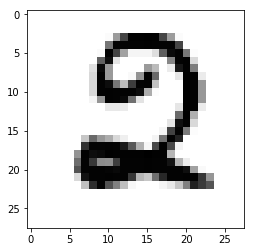

In [3]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [4]:
def discriminator(images, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
    return d4

In [5]:
def generator(z, batch_size, z_dim, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [6]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
z_batch = np.random.normal(0, 1, [1, z_dimensions])

In [7]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)

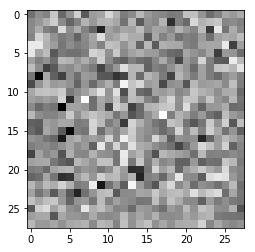

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [9]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

with tf.variable_scope(tf.get_variable_scope()):
    Gz = generator(z_placeholder, batch_size, z_dimensions) 
    # Gz holds the generated images

    Dx = discriminator(x_placeholder) 
    # Dx will hold discriminator prediction probabilities
    # for the real MNIST images

    Dg = discriminator(Gz, reuse=True)
    # Dg will hold discriminator prediction probabilities for generated images

In [10]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [11]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [12]:
tvars = tf.trainable_variables()

d
print([v.name for v in d_vars])
print([v.name for v in g_vars])

[u'd_w1:0', u'd_b1:0', u'd_w2:0', u'd_b2:0', u'd_w3:0', u'd_b3:0', u'd_w4:0', u'd_b4:0']
[u'g_w1:0', u'g_b1:0', u'g_w2:0', u'g_b2:0', u'g_w3:0', u'g_b3:0', u'g_w4:0', u'g_b4:0']


In [13]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [14]:
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions, True)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

('dLossReal:', 0.69379634, 'dLossFake:', 0.71384013)
('dLossReal:', 0.044535205, 'dLossFake:', 0.18378258)
('dLossReal:', 0.00065816834, 'dLossFake:', 0.001376335)
('Iteration:', 0, 'at', datetime.datetime(2017, 10, 22, 19, 21, 41, 27175))


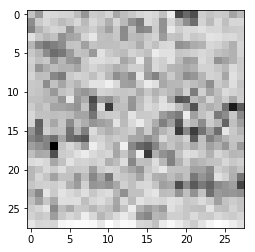

('Estimate:', array([[-7.38414288]], dtype=float32))
('Iteration:', 100, 'at', datetime.datetime(2017, 10, 22, 19, 22, 47, 562967))


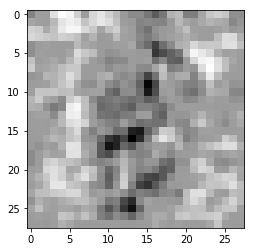

('Estimate:', array([[-7.49534512]], dtype=float32))
('Iteration:', 200, 'at', datetime.datetime(2017, 10, 22, 19, 23, 57, 991358))


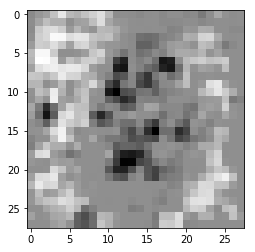

('Estimate:', array([[-6.44347858]], dtype=float32))
('Iteration:', 300, 'at', datetime.datetime(2017, 10, 22, 19, 25, 4, 603312))


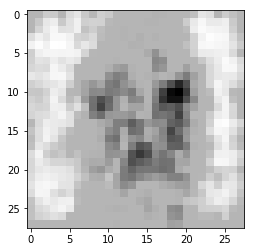

('Estimate:', array([[-8.51772213]], dtype=float32))
('Iteration:', 400, 'at', datetime.datetime(2017, 10, 22, 19, 26, 11, 153793))


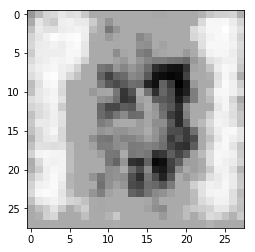

('Estimate:', array([[-7.55798197]], dtype=float32))
('Iteration:', 500, 'at', datetime.datetime(2017, 10, 22, 19, 27, 16, 137806))


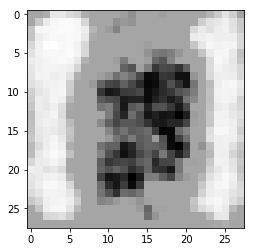

('Estimate:', array([[-7.88161278]], dtype=float32))
('Iteration:', 600, 'at', datetime.datetime(2017, 10, 22, 19, 28, 26, 235439))


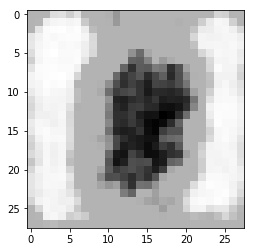

('Estimate:', array([[-8.83077908]], dtype=float32))
('Iteration:', 700, 'at', datetime.datetime(2017, 10, 22, 19, 29, 39, 763428))


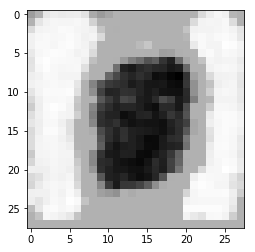

('Estimate:', array([[-8.62012863]], dtype=float32))
('Iteration:', 800, 'at', datetime.datetime(2017, 10, 22, 19, 30, 50, 302308))


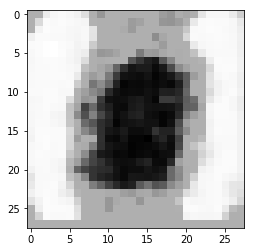

('Estimate:', array([[-7.63554096]], dtype=float32))
('Iteration:', 900, 'at', datetime.datetime(2017, 10, 22, 19, 32, 13, 359920))


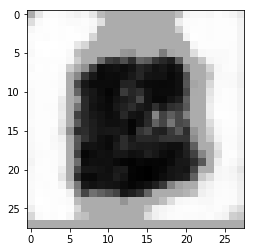

('Estimate:', array([[-7.46763468]], dtype=float32))
('Iteration:', 1000, 'at', datetime.datetime(2017, 10, 22, 19, 33, 31, 866905))


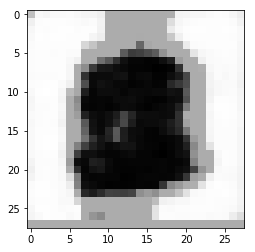

('Estimate:', array([[-7.23749256]], dtype=float32))
('Iteration:', 1100, 'at', datetime.datetime(2017, 10, 22, 19, 34, 53, 360757))


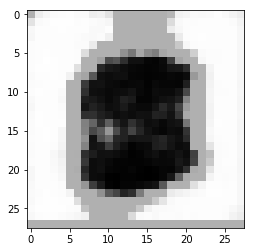

('Estimate:', array([[-7.07117939]], dtype=float32))
('Iteration:', 1200, 'at', datetime.datetime(2017, 10, 22, 19, 36, 4, 970837))


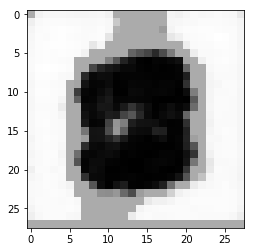

('Estimate:', array([[-7.55153847]], dtype=float32))
('Iteration:', 1300, 'at', datetime.datetime(2017, 10, 22, 19, 37, 9, 470498))


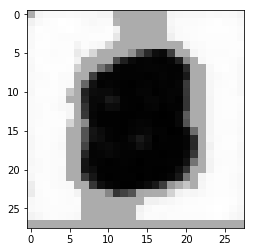

('Estimate:', array([[-7.25279093]], dtype=float32))
('Iteration:', 1400, 'at', datetime.datetime(2017, 10, 22, 19, 38, 12, 833364))


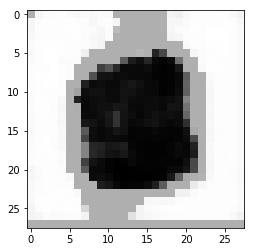

('Estimate:', array([[-7.94307947]], dtype=float32))
('Iteration:', 1500, 'at', datetime.datetime(2017, 10, 22, 19, 39, 15, 984958))


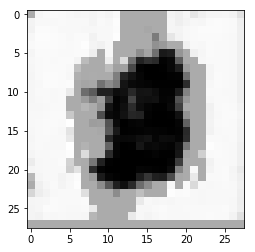

('Estimate:', array([[-20.4323101]], dtype=float32))
('Iteration:', 1600, 'at', datetime.datetime(2017, 10, 22, 19, 40, 19, 691401))


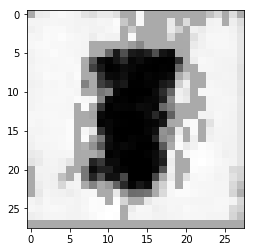

('Estimate:', array([[-8.63736153]], dtype=float32))
('Iteration:', 1700, 'at', datetime.datetime(2017, 10, 22, 19, 41, 23, 509571))


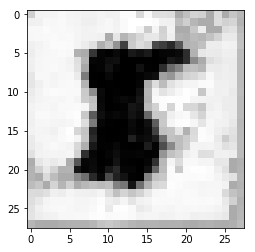

('Estimate:', array([[-7.32052088]], dtype=float32))
('Iteration:', 1800, 'at', datetime.datetime(2017, 10, 22, 19, 42, 30, 190727))


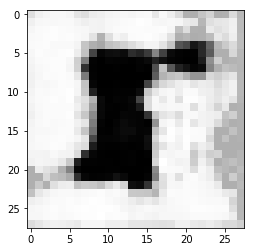

('Estimate:', array([[-5.78317451]], dtype=float32))
('Iteration:', 1900, 'at', datetime.datetime(2017, 10, 22, 19, 43, 35, 261053))


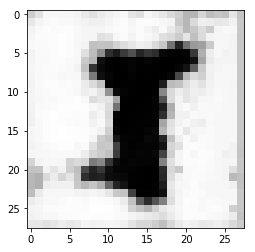

('Estimate:', array([[-6.7819171]], dtype=float32))
('Iteration:', 2000, 'at', datetime.datetime(2017, 10, 22, 19, 44, 40, 114475))


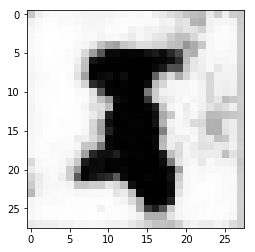

('Estimate:', array([[-7.8370409]], dtype=float32))
('Iteration:', 2100, 'at', datetime.datetime(2017, 10, 22, 19, 45, 44, 183519))


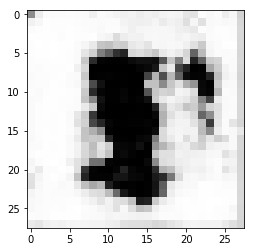

('Estimate:', array([[-31.77844048]], dtype=float32))
('Iteration:', 2200, 'at', datetime.datetime(2017, 10, 22, 19, 46, 48, 119722))


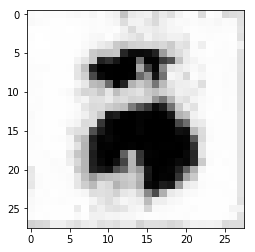

('Estimate:', array([[-47.47853851]], dtype=float32))
('Iteration:', 2300, 'at', datetime.datetime(2017, 10, 22, 19, 47, 51, 960334))


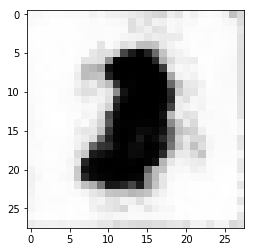

('Estimate:', array([[-91.28728485]], dtype=float32))
('Iteration:', 2400, 'at', datetime.datetime(2017, 10, 22, 19, 48, 55, 726479))


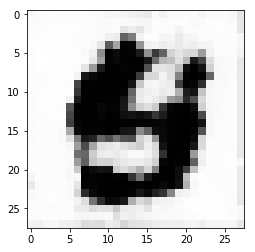

('Estimate:', array([[-15.21652412]], dtype=float32))
('Iteration:', 2500, 'at', datetime.datetime(2017, 10, 22, 19, 50, 0, 166133))


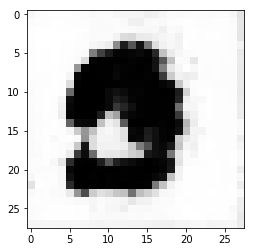

('Estimate:', array([[-21.76048279]], dtype=float32))
('Iteration:', 2600, 'at', datetime.datetime(2017, 10, 22, 19, 51, 3, 919818))


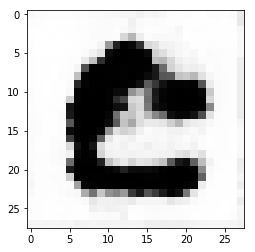

('Estimate:', array([[-9.36385345]], dtype=float32))
('Iteration:', 2700, 'at', datetime.datetime(2017, 10, 22, 19, 52, 8, 275670))


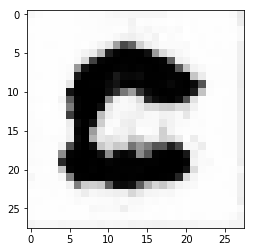

('Estimate:', array([[-19.27296257]], dtype=float32))
('Iteration:', 2800, 'at', datetime.datetime(2017, 10, 22, 19, 53, 12, 656848))


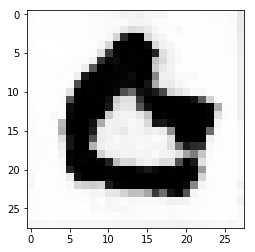

('Estimate:', array([[-12.12089825]], dtype=float32))
('Iteration:', 2900, 'at', datetime.datetime(2017, 10, 22, 19, 54, 17, 557668))


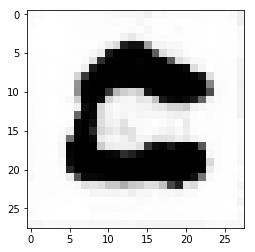

('Estimate:', array([[-21.0544548]], dtype=float32))
('Iteration:', 3000, 'at', datetime.datetime(2017, 10, 22, 19, 55, 21, 334474))


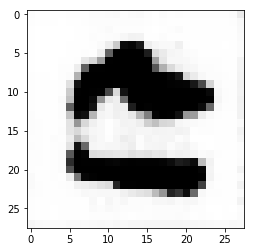

('Estimate:', array([[-4.28701258]], dtype=float32))
('Iteration:', 3100, 'at', datetime.datetime(2017, 10, 22, 19, 56, 25, 141059))


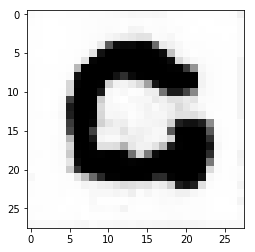

('Estimate:', array([[-11.03503609]], dtype=float32))
('Iteration:', 3200, 'at', datetime.datetime(2017, 10, 22, 19, 57, 29, 60414))


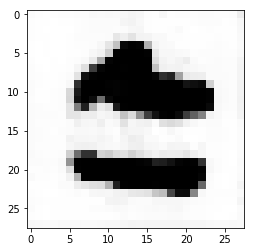

('Estimate:', array([[-10.79782295]], dtype=float32))
('Iteration:', 3300, 'at', datetime.datetime(2017, 10, 22, 19, 58, 32, 761110))


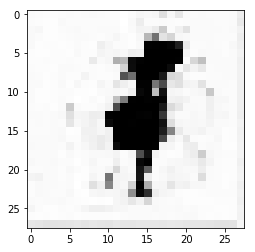

('Estimate:', array([[-24.80645943]], dtype=float32))
('Iteration:', 3400, 'at', datetime.datetime(2017, 10, 22, 19, 59, 36, 595619))


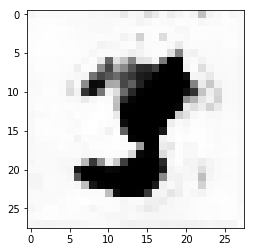

('Estimate:', array([[-36.68167496]], dtype=float32))
('Iteration:', 3500, 'at', datetime.datetime(2017, 10, 22, 20, 0, 40, 180009))


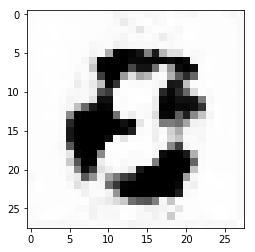

('Estimate:', array([[-44.6209259]], dtype=float32))
('Iteration:', 3600, 'at', datetime.datetime(2017, 10, 22, 20, 1, 44, 80403))


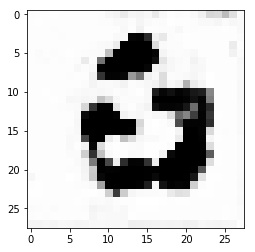

('Estimate:', array([[-54.48130798]], dtype=float32))
('Iteration:', 3700, 'at', datetime.datetime(2017, 10, 22, 20, 2, 47, 791350))


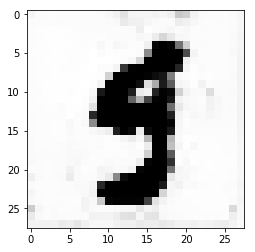

('Estimate:', array([[-45.86614609]], dtype=float32))
('Iteration:', 3800, 'at', datetime.datetime(2017, 10, 22, 20, 3, 51, 632941))


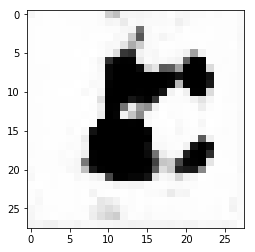

('Estimate:', array([[-74.26583862]], dtype=float32))
('Iteration:', 3900, 'at', datetime.datetime(2017, 10, 22, 20, 4, 55, 331110))


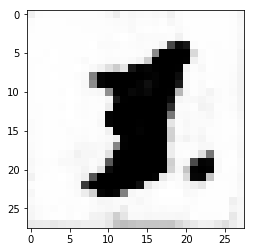

('Estimate:', array([[-28.04379272]], dtype=float32))
('Iteration:', 4000, 'at', datetime.datetime(2017, 10, 22, 20, 6, 0, 645044))


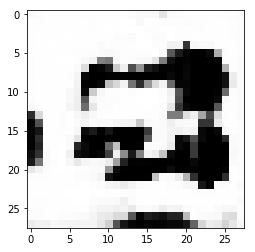

('Estimate:', array([[-22.11040306]], dtype=float32))
('Iteration:', 4100, 'at', datetime.datetime(2017, 10, 22, 20, 7, 4, 733090))


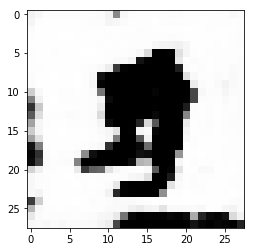

('Estimate:', array([[-23.42289162]], dtype=float32))
('Iteration:', 4200, 'at', datetime.datetime(2017, 10, 22, 20, 8, 8, 562331))


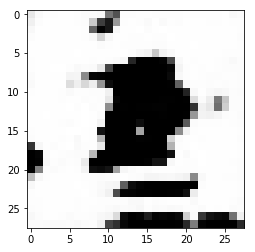

('Estimate:', array([[-22.30648804]], dtype=float32))
('Iteration:', 4300, 'at', datetime.datetime(2017, 10, 22, 20, 9, 15, 593233))


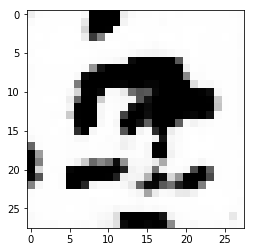

('Estimate:', array([[-26.3735199]], dtype=float32))
('Iteration:', 4400, 'at', datetime.datetime(2017, 10, 22, 20, 10, 22, 836376))


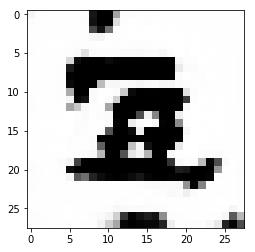

('Estimate:', array([[-16.05859184]], dtype=float32))
('Iteration:', 4500, 'at', datetime.datetime(2017, 10, 22, 20, 11, 36, 879460))


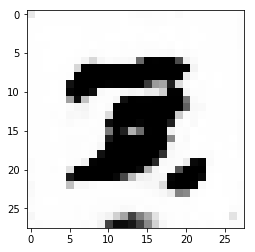

('Estimate:', array([[-29.80023766]], dtype=float32))
('Iteration:', 4600, 'at', datetime.datetime(2017, 10, 22, 20, 12, 45, 420634))


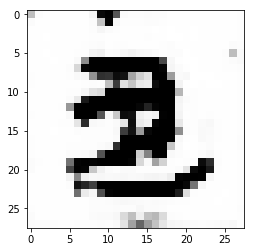

('Estimate:', array([[-67.90370178]], dtype=float32))
('Iteration:', 4700, 'at', datetime.datetime(2017, 10, 22, 20, 13, 52, 808057))


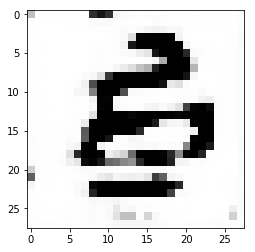

('Estimate:', array([[-95.98709869]], dtype=float32))
('Iteration:', 4800, 'at', datetime.datetime(2017, 10, 22, 20, 15, 0, 920825))


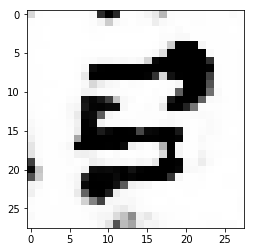

('Estimate:', array([[-114.88782501]], dtype=float32))
('Iteration:', 4900, 'at', datetime.datetime(2017, 10, 22, 20, 16, 5, 659355))


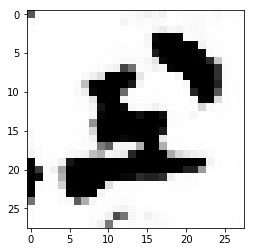

('Estimate:', array([[-43.61350632]], dtype=float32))
('Iteration:', 5000, 'at', datetime.datetime(2017, 10, 22, 20, 17, 9, 787257))


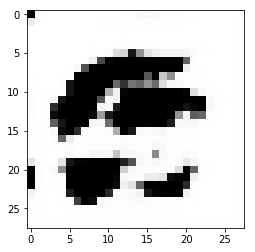

('Estimate:', array([[-32.54787827]], dtype=float32))
('Iteration:', 5100, 'at', datetime.datetime(2017, 10, 22, 20, 18, 12, 860864))


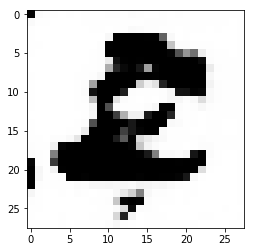

('Estimate:', array([[-22.37106323]], dtype=float32))
('Iteration:', 5200, 'at', datetime.datetime(2017, 10, 22, 20, 19, 16, 462965))


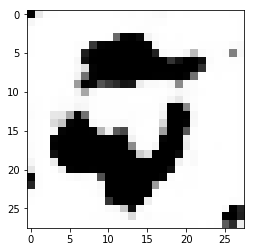

('Estimate:', array([[-16.13382339]], dtype=float32))
('Iteration:', 5300, 'at', datetime.datetime(2017, 10, 22, 20, 20, 19, 450045))


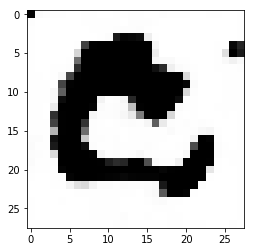

('Estimate:', array([[-30.5435257]], dtype=float32))
('Iteration:', 5400, 'at', datetime.datetime(2017, 10, 22, 20, 21, 22, 746026))


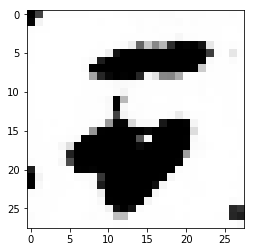

('Estimate:', array([[-80.03873444]], dtype=float32))
('Iteration:', 5500, 'at', datetime.datetime(2017, 10, 22, 20, 22, 25, 946429))


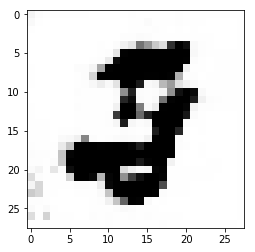

('Estimate:', array([[-73.09912872]], dtype=float32))
('Iteration:', 5600, 'at', datetime.datetime(2017, 10, 22, 20, 23, 28, 978209))


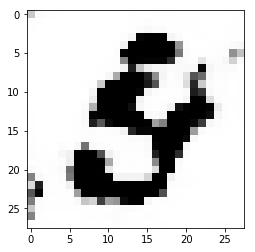

('Estimate:', array([[-72.56877136]], dtype=float32))
('Iteration:', 5700, 'at', datetime.datetime(2017, 10, 22, 20, 24, 31, 899492))


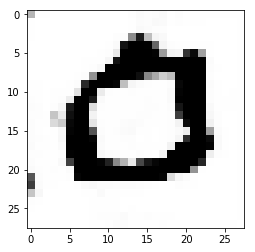

('Estimate:', array([[-74.54846954]], dtype=float32))
('Iteration:', 5800, 'at', datetime.datetime(2017, 10, 22, 20, 25, 34, 971174))


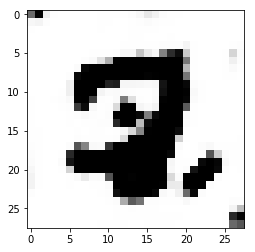

('Estimate:', array([[-19.60740852]], dtype=float32))
('Iteration:', 5900, 'at', datetime.datetime(2017, 10, 22, 20, 26, 37, 948423))


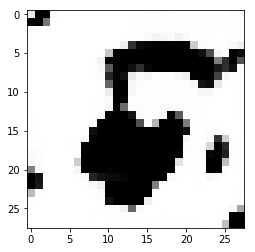

('Estimate:', array([[-17.53584099]], dtype=float32))
('Iteration:', 6000, 'at', datetime.datetime(2017, 10, 22, 20, 27, 41, 288273))


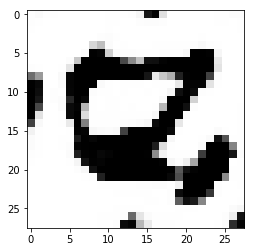

('Estimate:', array([[-19.43548584]], dtype=float32))
('Iteration:', 6100, 'at', datetime.datetime(2017, 10, 22, 20, 28, 44, 100034))


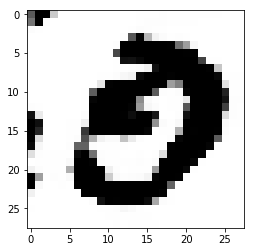

('Estimate:', array([[-27.16703987]], dtype=float32))
('Iteration:', 6200, 'at', datetime.datetime(2017, 10, 22, 20, 29, 47, 49129))


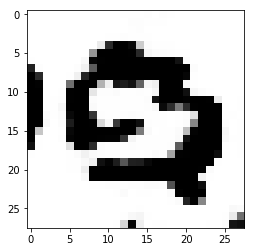

('Estimate:', array([[-17.98210716]], dtype=float32))
('Iteration:', 6300, 'at', datetime.datetime(2017, 10, 22, 20, 30, 50, 46389))


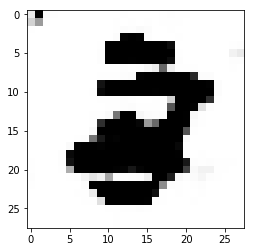

('Estimate:', array([[-20.97791672]], dtype=float32))
('Iteration:', 6400, 'at', datetime.datetime(2017, 10, 22, 20, 31, 53, 552222))


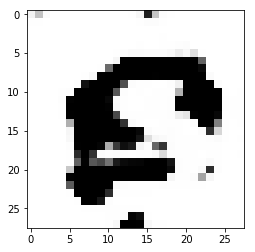

('Estimate:', array([[-76.78718567]], dtype=float32))
('Iteration:', 6500, 'at', datetime.datetime(2017, 10, 22, 20, 32, 57, 577781))


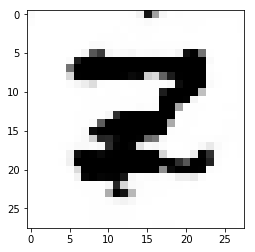

('Estimate:', array([[-72.73107147]], dtype=float32))
('Iteration:', 6600, 'at', datetime.datetime(2017, 10, 22, 20, 34, 0, 645095))


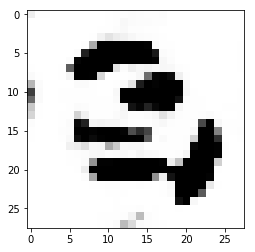

('Estimate:', array([[-79.41326141]], dtype=float32))
('Iteration:', 6700, 'at', datetime.datetime(2017, 10, 22, 20, 35, 3, 721392))


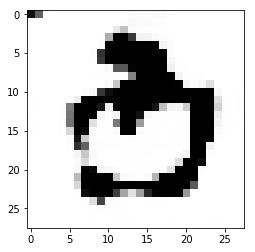

('Estimate:', array([[-78.89089966]], dtype=float32))
('Iteration:', 6800, 'at', datetime.datetime(2017, 10, 22, 20, 36, 6, 671523))


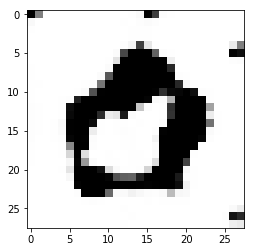

('Estimate:', array([[-89.77285767]], dtype=float32))
('Iteration:', 6900, 'at', datetime.datetime(2017, 10, 22, 20, 37, 9, 653529))


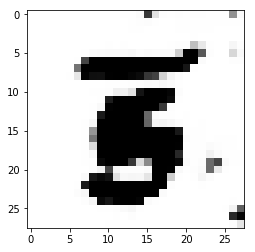

('Estimate:', array([[-89.31580353]], dtype=float32))
('Iteration:', 7000, 'at', datetime.datetime(2017, 10, 22, 20, 38, 12, 871199))


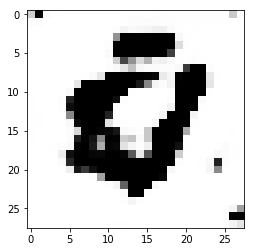

('Estimate:', array([[-23.84155083]], dtype=float32))
('Iteration:', 7100, 'at', datetime.datetime(2017, 10, 22, 20, 39, 16, 52950))


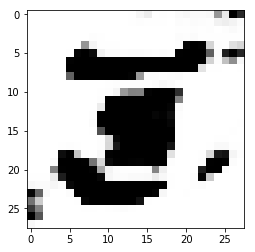

('Estimate:', array([[-24.1204567]], dtype=float32))
('Iteration:', 7200, 'at', datetime.datetime(2017, 10, 22, 20, 40, 19, 138106))


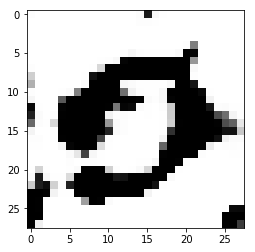

('Estimate:', array([[-25.04619217]], dtype=float32))
('Iteration:', 7300, 'at', datetime.datetime(2017, 10, 22, 20, 41, 22, 161201))


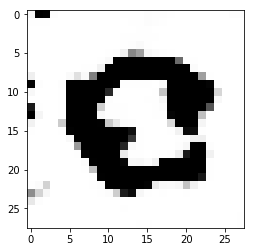

('Estimate:', array([[-16.58463287]], dtype=float32))
('Iteration:', 7400, 'at', datetime.datetime(2017, 10, 22, 20, 42, 25, 54649))


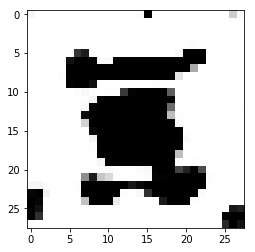

('Estimate:', array([[-13.2151804]], dtype=float32))
('Iteration:', 7500, 'at', datetime.datetime(2017, 10, 22, 20, 43, 28, 519522))


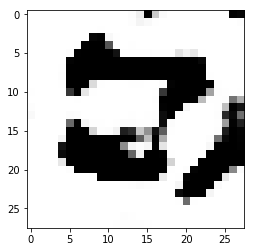

('Estimate:', array([[-38.72570801]], dtype=float32))
('Iteration:', 7600, 'at', datetime.datetime(2017, 10, 22, 20, 44, 31, 917957))


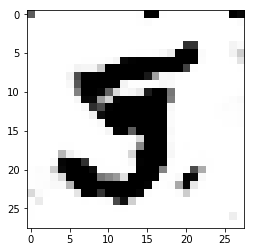

('Estimate:', array([[-47.47230911]], dtype=float32))
('Iteration:', 7700, 'at', datetime.datetime(2017, 10, 22, 20, 45, 35, 457965))


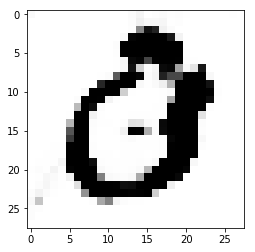

('Estimate:', array([[-37.89625549]], dtype=float32))
('Iteration:', 7800, 'at', datetime.datetime(2017, 10, 22, 20, 46, 38, 845548))


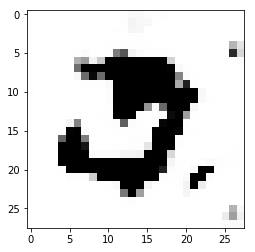

('Estimate:', array([[-71.94352722]], dtype=float32))
('Iteration:', 7900, 'at', datetime.datetime(2017, 10, 22, 20, 47, 42, 488860))


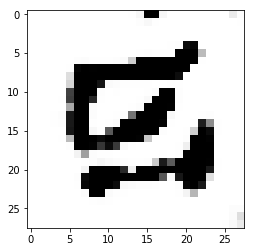

('Estimate:', array([[-55.77136612]], dtype=float32))
('Iteration:', 8000, 'at', datetime.datetime(2017, 10, 22, 20, 48, 45, 463316))


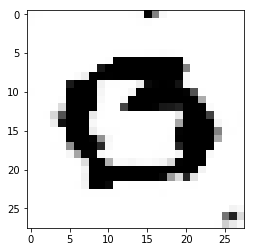

('Estimate:', array([[-73.73956299]], dtype=float32))
('Iteration:', 8100, 'at', datetime.datetime(2017, 10, 22, 20, 49, 48, 705059))


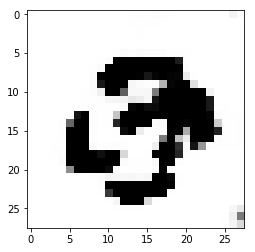

('Estimate:', array([[-58.19429016]], dtype=float32))
('Iteration:', 8200, 'at', datetime.datetime(2017, 10, 22, 20, 50, 51, 498101))


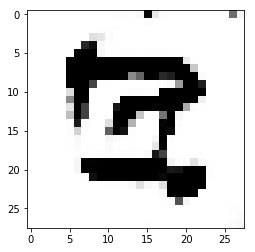

('Estimate:', array([[-55.16394043]], dtype=float32))
('Iteration:', 8300, 'at', datetime.datetime(2017, 10, 22, 20, 51, 54, 623414))


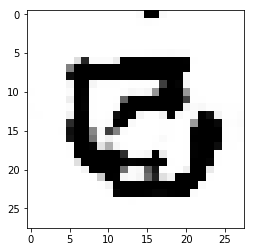

('Estimate:', array([[-64.27848816]], dtype=float32))
('Iteration:', 8400, 'at', datetime.datetime(2017, 10, 22, 20, 52, 58, 18923))


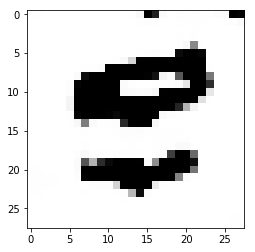

('Estimate:', array([[-64.45901489]], dtype=float32))
('Iteration:', 8500, 'at', datetime.datetime(2017, 10, 22, 20, 54, 2, 205932))


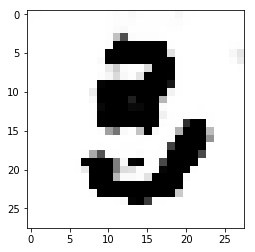

('Estimate:', array([[-56.28853607]], dtype=float32))
('Iteration:', 8600, 'at', datetime.datetime(2017, 10, 22, 20, 55, 5, 428847))


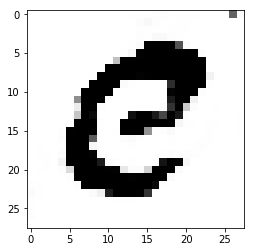

('Estimate:', array([[-59.36848068]], dtype=float32))
('Iteration:', 8700, 'at', datetime.datetime(2017, 10, 22, 20, 56, 8, 337754))


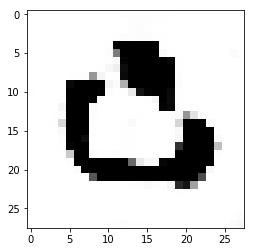

('Estimate:', array([[-52.42515182]], dtype=float32))
('Iteration:', 8800, 'at', datetime.datetime(2017, 10, 22, 20, 57, 11, 381767))


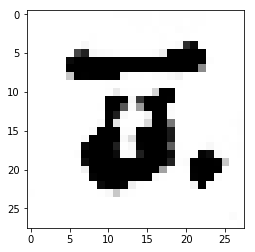

('Estimate:', array([[-60.31584167]], dtype=float32))
('Iteration:', 8900, 'at', datetime.datetime(2017, 10, 22, 20, 58, 14, 819244))


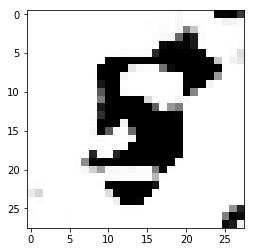

('Estimate:', array([[-45.36862946]], dtype=float32))
('Iteration:', 9000, 'at', datetime.datetime(2017, 10, 22, 20, 59, 18, 17554))


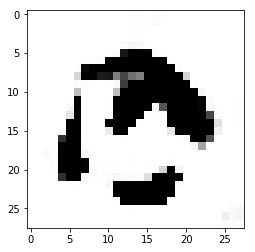

('Estimate:', array([[-48.86074829]], dtype=float32))
('Iteration:', 9100, 'at', datetime.datetime(2017, 10, 22, 21, 0, 20, 979811))


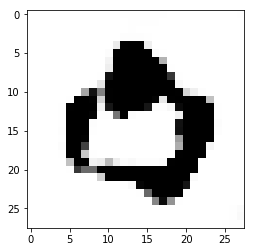

('Estimate:', array([[-59.15994644]], dtype=float32))
('Iteration:', 9200, 'at', datetime.datetime(2017, 10, 22, 21, 1, 24, 140086))


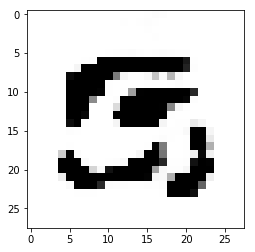

('Estimate:', array([[-61.97257233]], dtype=float32))
('Iteration:', 9300, 'at', datetime.datetime(2017, 10, 22, 21, 2, 26, 964302))


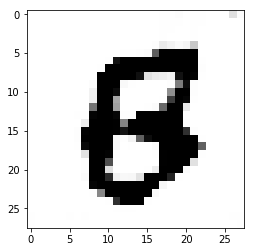

('Estimate:', array([[-48.28355408]], dtype=float32))
('Iteration:', 9400, 'at', datetime.datetime(2017, 10, 22, 21, 3, 30, 17494))


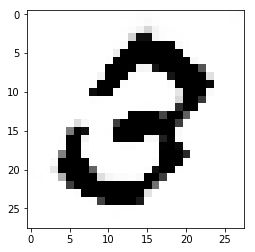

('Estimate:', array([[-47.04311371]], dtype=float32))
('Iteration:', 9500, 'at', datetime.datetime(2017, 10, 22, 21, 4, 37, 367455))


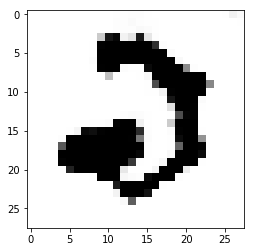

('Estimate:', array([[-48.76363373]], dtype=float32))
('Iteration:', 9600, 'at', datetime.datetime(2017, 10, 22, 21, 5, 47, 660231))


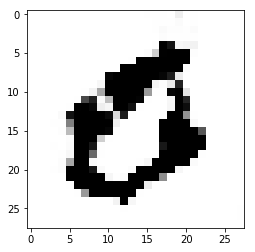

('Estimate:', array([[-45.48324203]], dtype=float32))
('Iteration:', 9700, 'at', datetime.datetime(2017, 10, 22, 21, 6, 56, 614600))


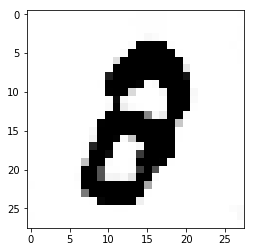

('Estimate:', array([[-49.6247139]], dtype=float32))
('Iteration:', 9800, 'at', datetime.datetime(2017, 10, 22, 21, 8, 5, 564269))


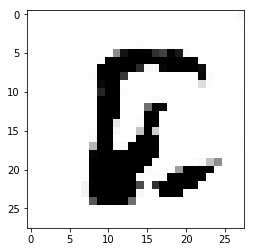

('Estimate:', array([[-47.5165596]], dtype=float32))
('Iteration:', 9900, 'at', datetime.datetime(2017, 10, 22, 21, 9, 12, 853632))


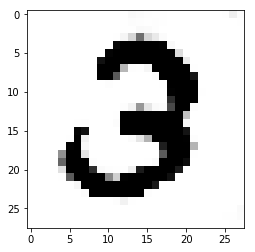

('Estimate:', array([[-31.79490471]], dtype=float32))
('Iteration:', 10000, 'at', datetime.datetime(2017, 10, 22, 21, 10, 17, 992745))


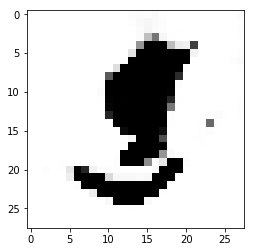

('Estimate:', array([[-36.49256134]], dtype=float32))
('Iteration:', 10100, 'at', datetime.datetime(2017, 10, 22, 21, 11, 28, 916799))


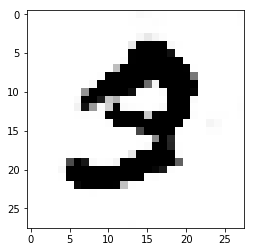

('Estimate:', array([[-47.49861145]], dtype=float32))
('Iteration:', 10200, 'at', datetime.datetime(2017, 10, 22, 21, 12, 40, 140281))


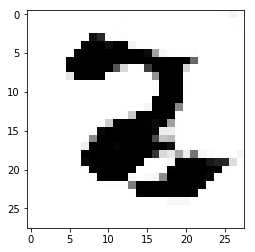

('Estimate:', array([[-24.7977829]], dtype=float32))
('Iteration:', 10300, 'at', datetime.datetime(2017, 10, 22, 21, 13, 54, 319186))


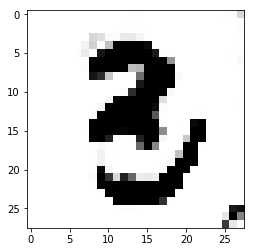

('Estimate:', array([[-37.16664886]], dtype=float32))
('Iteration:', 10400, 'at', datetime.datetime(2017, 10, 22, 21, 15, 1, 363565))


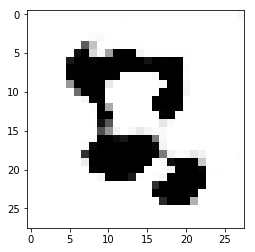

('Estimate:', array([[-42.32426453]], dtype=float32))
('Iteration:', 10500, 'at', datetime.datetime(2017, 10, 22, 21, 16, 8, 527381))


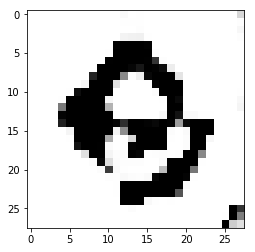

('Estimate:', array([[-25.87522316]], dtype=float32))
('Iteration:', 10600, 'at', datetime.datetime(2017, 10, 22, 21, 17, 12, 871641))


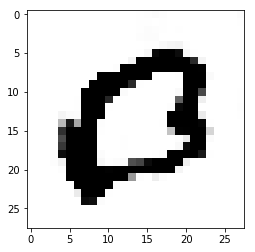

('Estimate:', array([[-31.88943481]], dtype=float32))
('Iteration:', 10700, 'at', datetime.datetime(2017, 10, 22, 21, 18, 16, 920283))


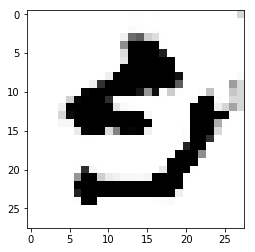

('Estimate:', array([[-26.63093376]], dtype=float32))
('Iteration:', 10800, 'at', datetime.datetime(2017, 10, 22, 21, 19, 21, 213942))


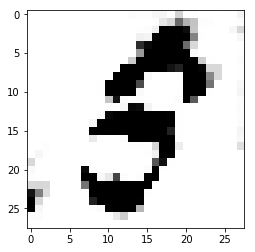

('Estimate:', array([[-32.40264893]], dtype=float32))
('Iteration:', 10900, 'at', datetime.datetime(2017, 10, 22, 21, 20, 25, 589062))


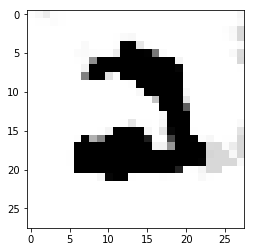

('Estimate:', array([[-29.53942871]], dtype=float32))
('Iteration:', 11000, 'at', datetime.datetime(2017, 10, 22, 21, 21, 30, 744252))


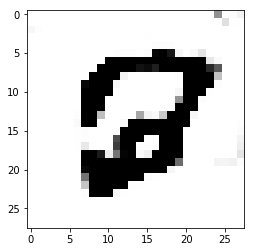

('Estimate:', array([[-18.88624191]], dtype=float32))
('Iteration:', 11100, 'at', datetime.datetime(2017, 10, 22, 21, 22, 37, 954128))


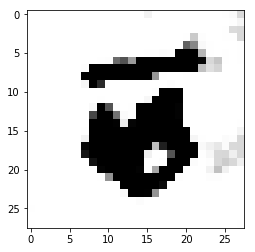

('Estimate:', array([[-28.47192001]], dtype=float32))
('Iteration:', 11200, 'at', datetime.datetime(2017, 10, 22, 21, 23, 43, 784264))


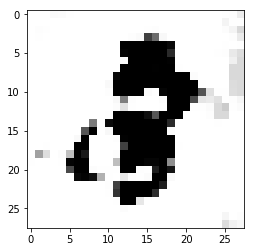

('Estimate:', array([[-26.82452393]], dtype=float32))
('Iteration:', 11300, 'at', datetime.datetime(2017, 10, 22, 21, 24, 48, 111430))


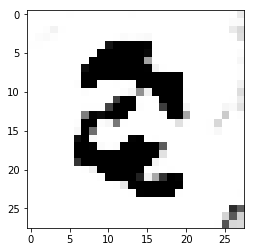

('Estimate:', array([[-19.97790718]], dtype=float32))
('Iteration:', 11400, 'at', datetime.datetime(2017, 10, 22, 21, 25, 53, 191190))


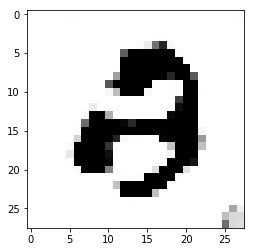

('Estimate:', array([[-19.72005463]], dtype=float32))
('Iteration:', 11500, 'at', datetime.datetime(2017, 10, 22, 21, 26, 58, 427877))


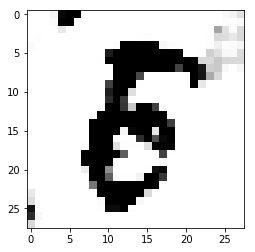

('Estimate:', array([[-19.70333862]], dtype=float32))
('Iteration:', 11600, 'at', datetime.datetime(2017, 10, 22, 21, 28, 4, 176777))


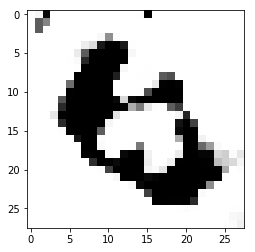

('Estimate:', array([[-21.31818771]], dtype=float32))
('Iteration:', 11700, 'at', datetime.datetime(2017, 10, 22, 21, 29, 12, 327414))


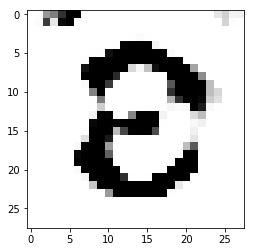

('Estimate:', array([[-30.7364502]], dtype=float32))
('Iteration:', 11800, 'at', datetime.datetime(2017, 10, 22, 21, 30, 19, 555858))


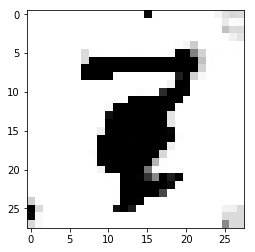

('Estimate:', array([[-15.15818024]], dtype=float32))
('Iteration:', 11900, 'at', datetime.datetime(2017, 10, 22, 21, 31, 23, 348108))


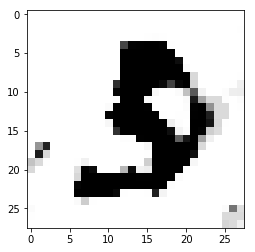

('Estimate:', array([[-27.3758297]], dtype=float32))
('Iteration:', 12000, 'at', datetime.datetime(2017, 10, 22, 21, 32, 26, 952571))


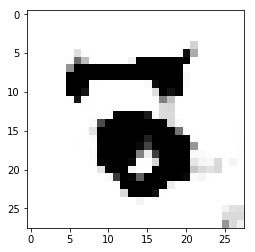

('Estimate:', array([[-17.84474945]], dtype=float32))
('Iteration:', 12100, 'at', datetime.datetime(2017, 10, 22, 21, 33, 31, 363848))


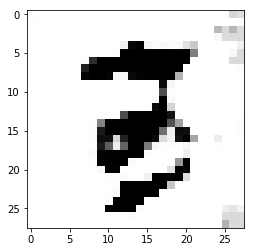

('Estimate:', array([[-21.2434864]], dtype=float32))
('Iteration:', 12200, 'at', datetime.datetime(2017, 10, 22, 21, 34, 34, 812742))


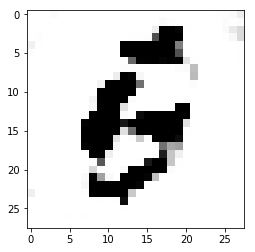

('Estimate:', array([[-22.72865677]], dtype=float32))
('Iteration:', 12300, 'at', datetime.datetime(2017, 10, 22, 21, 35, 38, 337245))


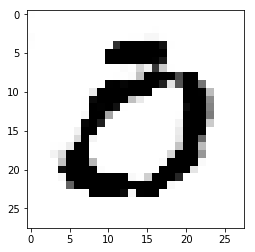

('Estimate:', array([[-20.61161232]], dtype=float32))
('Iteration:', 12400, 'at', datetime.datetime(2017, 10, 22, 21, 36, 42, 95860))


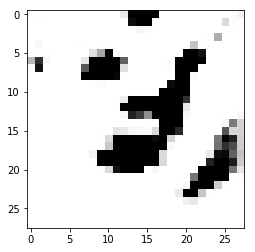

('Estimate:', array([[-16.94674873]], dtype=float32))
('Iteration:', 12500, 'at', datetime.datetime(2017, 10, 22, 21, 37, 45, 86037))


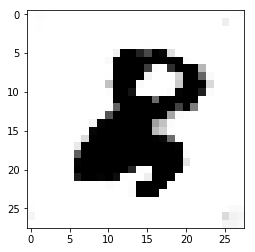

('Estimate:', array([[-15.09629631]], dtype=float32))
('Iteration:', 12600, 'at', datetime.datetime(2017, 10, 22, 21, 38, 48, 132766))


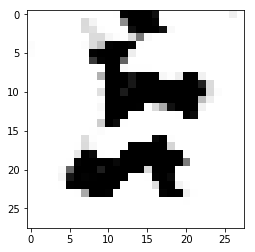

('Estimate:', array([[-18.36580276]], dtype=float32))
('Iteration:', 12700, 'at', datetime.datetime(2017, 10, 22, 21, 39, 51, 439528))


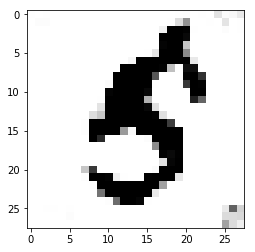

('Estimate:', array([[-13.06387234]], dtype=float32))
('Iteration:', 12800, 'at', datetime.datetime(2017, 10, 22, 21, 40, 54, 598361))


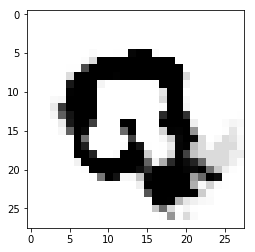

('Estimate:', array([[-26.15508842]], dtype=float32))
('Iteration:', 12900, 'at', datetime.datetime(2017, 10, 22, 21, 41, 57, 872420))


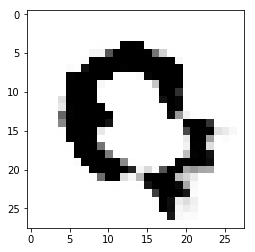

('Estimate:', array([[-19.27845764]], dtype=float32))
('Iteration:', 13000, 'at', datetime.datetime(2017, 10, 22, 21, 43, 1, 123227))


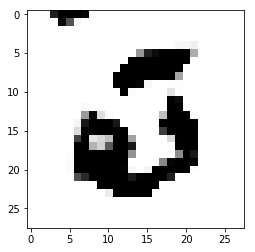

('Estimate:', array([[-15.98286438]], dtype=float32))
('Iteration:', 13100, 'at', datetime.datetime(2017, 10, 22, 21, 44, 4, 269583))


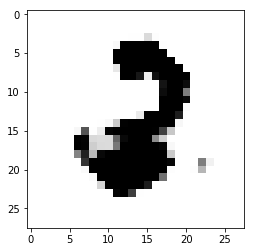

('Estimate:', array([[-20.232584]], dtype=float32))
('Iteration:', 13200, 'at', datetime.datetime(2017, 10, 22, 21, 45, 7, 460192))


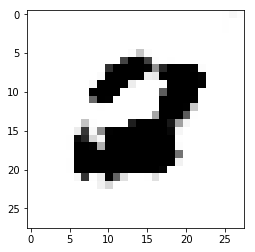

('Estimate:', array([[-16.66198921]], dtype=float32))
('Iteration:', 13300, 'at', datetime.datetime(2017, 10, 22, 21, 46, 10, 351281))


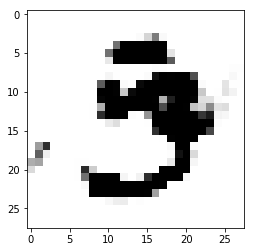

('Estimate:', array([[-10.05742931]], dtype=float32))
('Iteration:', 13400, 'at', datetime.datetime(2017, 10, 22, 21, 47, 14, 36801))


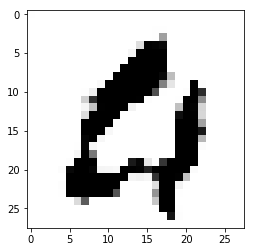

('Estimate:', array([[-13.42996979]], dtype=float32))
('Iteration:', 13500, 'at', datetime.datetime(2017, 10, 22, 21, 48, 17, 126525))


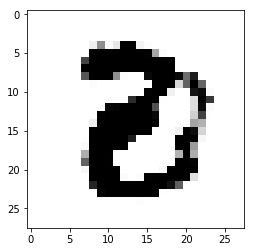

('Estimate:', array([[-11.72666836]], dtype=float32))
('Iteration:', 13600, 'at', datetime.datetime(2017, 10, 22, 21, 49, 20, 536396))


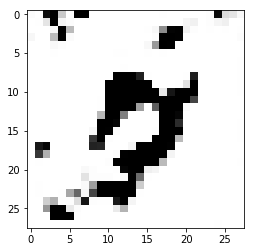

('Estimate:', array([[-6.60485125]], dtype=float32))
('Iteration:', 13700, 'at', datetime.datetime(2017, 10, 22, 21, 50, 24, 179908))


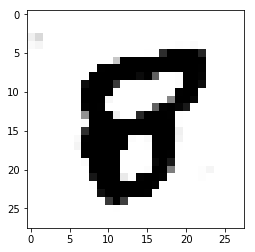

('Estimate:', array([[-9.83646202]], dtype=float32))
('Iteration:', 13800, 'at', datetime.datetime(2017, 10, 22, 21, 51, 27, 934475))


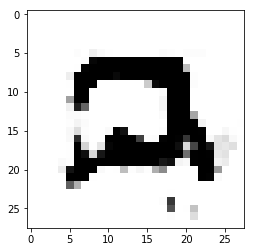

('Estimate:', array([[-8.82803059]], dtype=float32))
('Iteration:', 13900, 'at', datetime.datetime(2017, 10, 22, 21, 52, 32, 70125))


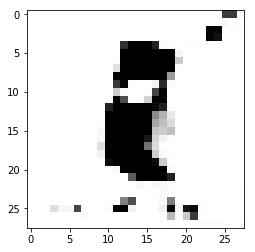

('Estimate:', array([[-12.81888103]], dtype=float32))
('Iteration:', 14000, 'at', datetime.datetime(2017, 10, 22, 21, 53, 35, 624057))


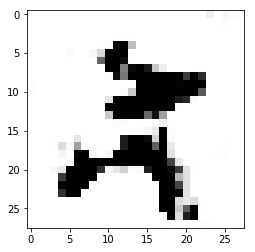

('Estimate:', array([[-8.42222691]], dtype=float32))
('Iteration:', 14100, 'at', datetime.datetime(2017, 10, 22, 21, 54, 39, 44340))


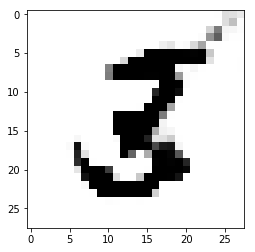

('Estimate:', array([[-8.21517181]], dtype=float32))
('Iteration:', 14200, 'at', datetime.datetime(2017, 10, 22, 21, 55, 43, 281296))


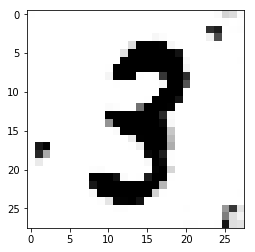

('Estimate:', array([[-5.71777487]], dtype=float32))
('Iteration:', 14300, 'at', datetime.datetime(2017, 10, 22, 21, 56, 46, 465294))


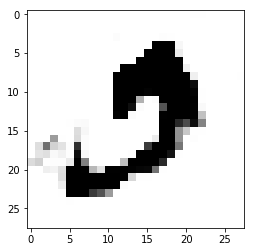

('Estimate:', array([[-8.26600266]], dtype=float32))
('Iteration:', 14400, 'at', datetime.datetime(2017, 10, 22, 21, 57, 50, 86783))


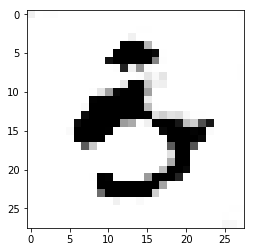

('Estimate:', array([[-11.5557375]], dtype=float32))
('Iteration:', 14500, 'at', datetime.datetime(2017, 10, 22, 21, 58, 53, 535282))


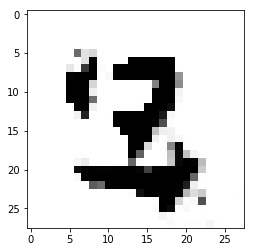

('Estimate:', array([[-9.02308178]], dtype=float32))
('Iteration:', 14600, 'at', datetime.datetime(2017, 10, 22, 21, 59, 57, 264167))


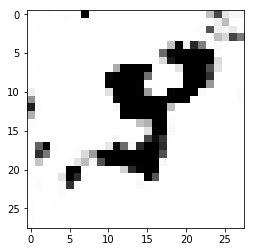

('Estimate:', array([[-13.20690918]], dtype=float32))
('Iteration:', 14700, 'at', datetime.datetime(2017, 10, 22, 22, 1, 0, 802903))


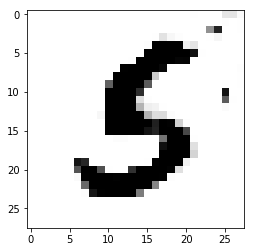

('Estimate:', array([[-8.15421009]], dtype=float32))
('Iteration:', 14800, 'at', datetime.datetime(2017, 10, 22, 22, 2, 4, 214601))


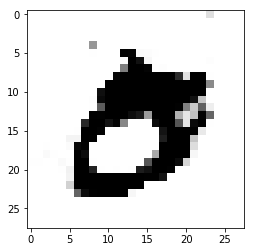

('Estimate:', array([[-10.23557091]], dtype=float32))
('Iteration:', 14900, 'at', datetime.datetime(2017, 10, 22, 22, 3, 7, 911442))


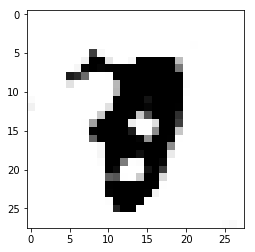

('Estimate:', array([[-7.93990231]], dtype=float32))
('Iteration:', 15000, 'at', datetime.datetime(2017, 10, 22, 22, 4, 11, 223821))


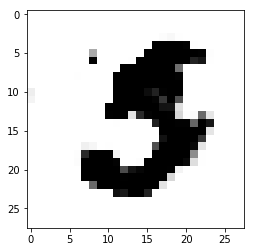

('Estimate:', array([[-9.98262215]], dtype=float32))
('Iteration:', 15100, 'at', datetime.datetime(2017, 10, 22, 22, 5, 14, 989457))


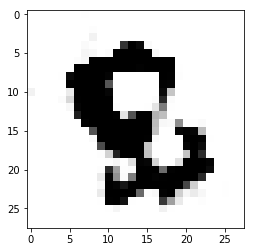

('Estimate:', array([[-7.5792613]], dtype=float32))
('Iteration:', 15200, 'at', datetime.datetime(2017, 10, 22, 22, 6, 18, 440895))


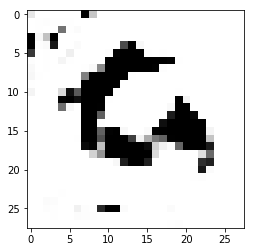

('Estimate:', array([[-9.93409634]], dtype=float32))
('Iteration:', 15300, 'at', datetime.datetime(2017, 10, 22, 22, 7, 22, 180808))


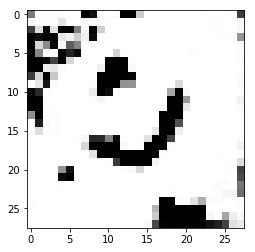

('Estimate:', array([[-18.26442719]], dtype=float32))
('Iteration:', 15400, 'at', datetime.datetime(2017, 10, 22, 22, 8, 26, 263394))


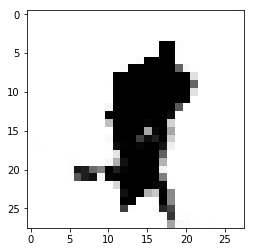

('Estimate:', array([[-8.79343987]], dtype=float32))
('Iteration:', 15500, 'at', datetime.datetime(2017, 10, 22, 22, 9, 31, 787825))


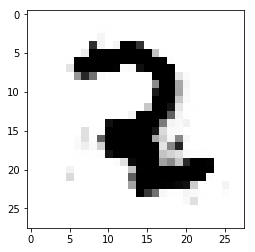

('Estimate:', array([[-7.80185938]], dtype=float32))
('Iteration:', 15600, 'at', datetime.datetime(2017, 10, 22, 22, 10, 39, 943407))


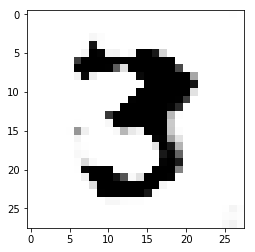

('Estimate:', array([[-8.50028515]], dtype=float32))
('Iteration:', 15700, 'at', datetime.datetime(2017, 10, 22, 22, 11, 51, 413136))


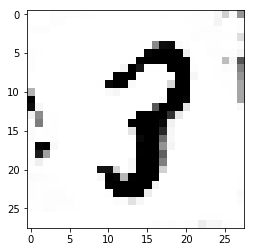

('Estimate:', array([[-9.76044083]], dtype=float32))
('Iteration:', 15800, 'at', datetime.datetime(2017, 10, 22, 22, 13, 3, 694874))


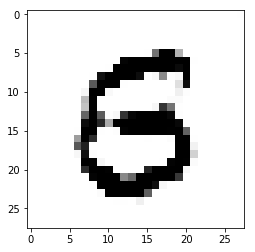

('Estimate:', array([[-4.96685219]], dtype=float32))
('Iteration:', 15900, 'at', datetime.datetime(2017, 10, 22, 22, 14, 13, 14014))


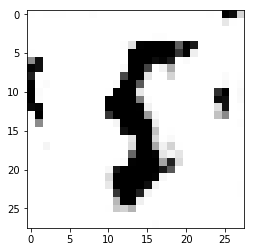

('Estimate:', array([[-6.55196905]], dtype=float32))
('Iteration:', 16000, 'at', datetime.datetime(2017, 10, 22, 22, 15, 20, 205442))


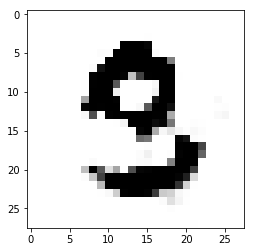

('Estimate:', array([[-9.0825119]], dtype=float32))
('Iteration:', 16100, 'at', datetime.datetime(2017, 10, 22, 22, 16, 27, 117671))


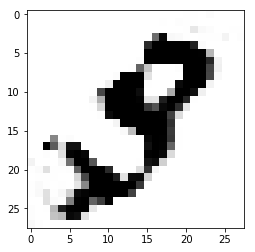

('Estimate:', array([[-8.8714304]], dtype=float32))
('Iteration:', 16200, 'at', datetime.datetime(2017, 10, 22, 22, 17, 32, 178985))


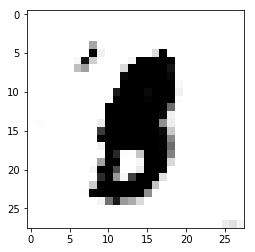

('Estimate:', array([[-4.46536732]], dtype=float32))
('Iteration:', 16300, 'at', datetime.datetime(2017, 10, 22, 22, 18, 36, 426941))


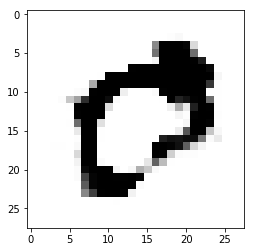

('Estimate:', array([[-4.79604864]], dtype=float32))
('Iteration:', 16400, 'at', datetime.datetime(2017, 10, 22, 22, 19, 40, 840859))


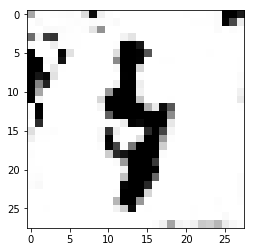

('Estimate:', array([[-5.91920757]], dtype=float32))
('Iteration:', 16500, 'at', datetime.datetime(2017, 10, 22, 22, 20, 44, 120630))


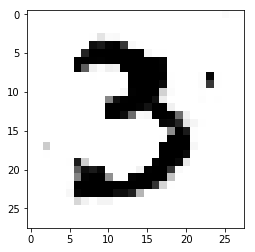

('Estimate:', array([[-4.4059701]], dtype=float32))
('Iteration:', 16600, 'at', datetime.datetime(2017, 10, 22, 22, 21, 47, 518772))


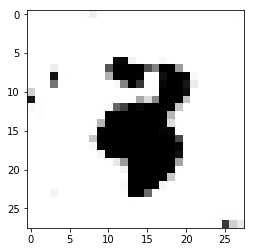

('Estimate:', array([[-6.54502678]], dtype=float32))
('Iteration:', 16700, 'at', datetime.datetime(2017, 10, 22, 22, 22, 50, 883765))


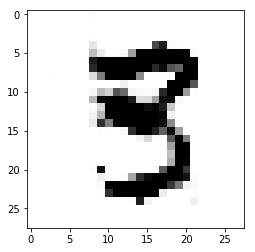

('Estimate:', array([[-6.03610659]], dtype=float32))
('Iteration:', 16800, 'at', datetime.datetime(2017, 10, 22, 22, 23, 54, 308621))


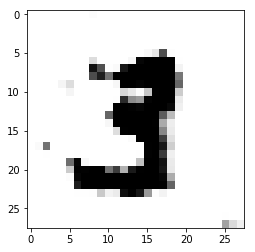

('Estimate:', array([[-6.25209522]], dtype=float32))
('Iteration:', 16900, 'at', datetime.datetime(2017, 10, 22, 22, 24, 57, 534179))


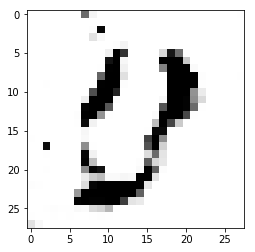

('Estimate:', array([[-5.7481389]], dtype=float32))
('Iteration:', 17000, 'at', datetime.datetime(2017, 10, 22, 22, 26, 1, 120637))


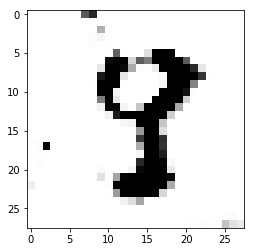

('Estimate:', array([[-5.02935505]], dtype=float32))
('Iteration:', 17100, 'at', datetime.datetime(2017, 10, 22, 22, 27, 4, 501398))


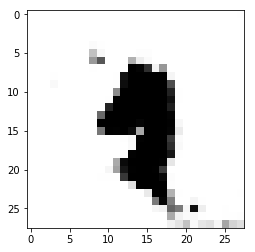

('Estimate:', array([[-4.53092051]], dtype=float32))
('Iteration:', 17200, 'at', datetime.datetime(2017, 10, 22, 22, 28, 7, 744646))


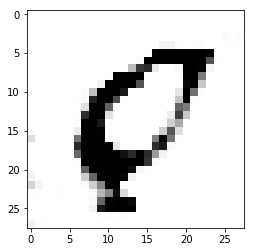

('Estimate:', array([[-2.43192887]], dtype=float32))
('Iteration:', 17300, 'at', datetime.datetime(2017, 10, 22, 22, 29, 11, 312409))


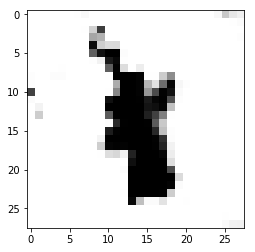

('Estimate:', array([[-4.92242956]], dtype=float32))
('Iteration:', 17400, 'at', datetime.datetime(2017, 10, 22, 22, 30, 14, 545153))


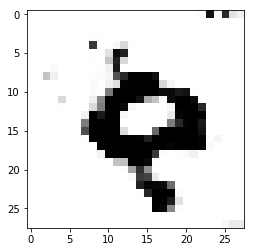

('Estimate:', array([[-2.87532759]], dtype=float32))
('Iteration:', 17500, 'at', datetime.datetime(2017, 10, 22, 22, 31, 17, 936781))


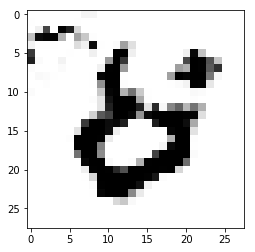

('Estimate:', array([[-2.13346243]], dtype=float32))
('Iteration:', 17600, 'at', datetime.datetime(2017, 10, 22, 22, 32, 21, 635128))


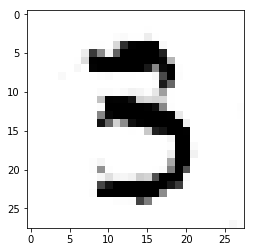

('Estimate:', array([[-1.81227636]], dtype=float32))
('Iteration:', 17700, 'at', datetime.datetime(2017, 10, 22, 22, 33, 24, 919702))


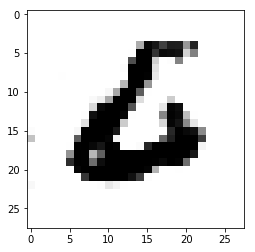

('Estimate:', array([[-2.77802896]], dtype=float32))
('Iteration:', 17800, 'at', datetime.datetime(2017, 10, 22, 22, 34, 30, 559296))


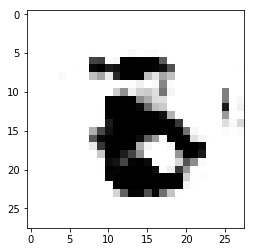

('Estimate:', array([[-2.474051]], dtype=float32))
('Iteration:', 17900, 'at', datetime.datetime(2017, 10, 22, 22, 35, 33, 733587))


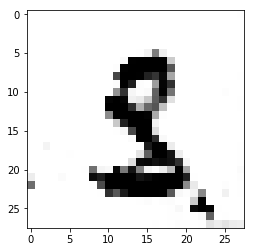

('Estimate:', array([[-2.7597127]], dtype=float32))
('Iteration:', 18000, 'at', datetime.datetime(2017, 10, 22, 22, 36, 36, 940373))


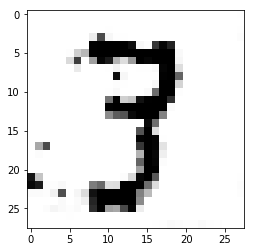

('Estimate:', array([[-1.60445464]], dtype=float32))
('Iteration:', 18100, 'at', datetime.datetime(2017, 10, 22, 22, 37, 40, 482072))


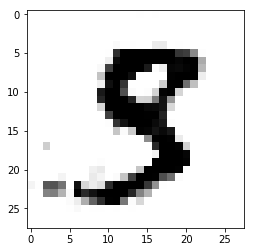

('Estimate:', array([[-3.05395389]], dtype=float32))
('Iteration:', 18200, 'at', datetime.datetime(2017, 10, 22, 22, 38, 43, 778710))


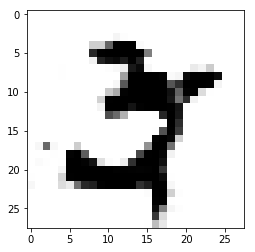

('Estimate:', array([[-1.69584727]], dtype=float32))
('Iteration:', 18300, 'at', datetime.datetime(2017, 10, 22, 22, 39, 47, 141561))


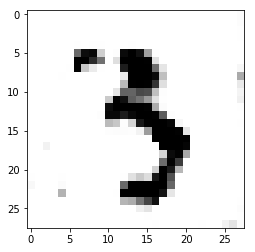

('Estimate:', array([[-2.68260384]], dtype=float32))
('Iteration:', 18400, 'at', datetime.datetime(2017, 10, 22, 22, 40, 50, 129301))


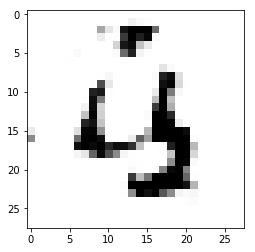

('Estimate:', array([[-3.93108201]], dtype=float32))
('Iteration:', 18500, 'at', datetime.datetime(2017, 10, 22, 22, 41, 53, 333887))


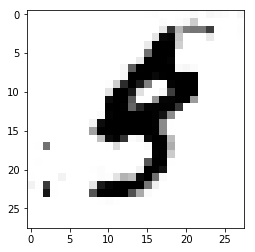

('Estimate:', array([[-1.70029366]], dtype=float32))
('Iteration:', 18600, 'at', datetime.datetime(2017, 10, 22, 22, 42, 56, 756368))


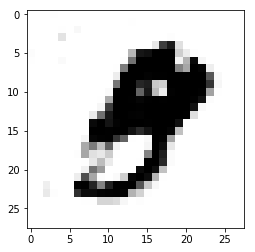

('Estimate:', array([[-1.1326021]], dtype=float32))
('Iteration:', 18700, 'at', datetime.datetime(2017, 10, 22, 22, 44, 0, 56433))


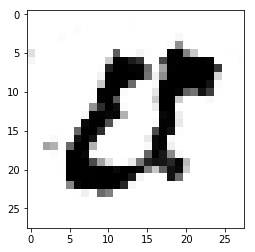

('Estimate:', array([[-3.46045232]], dtype=float32))
('Iteration:', 18800, 'at', datetime.datetime(2017, 10, 22, 22, 45, 3, 602733))


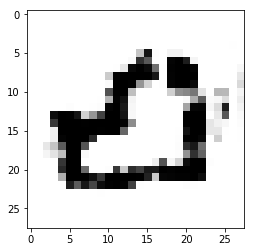

('Estimate:', array([[-3.61680317]], dtype=float32))
('Iteration:', 18900, 'at', datetime.datetime(2017, 10, 22, 22, 46, 6, 991913))


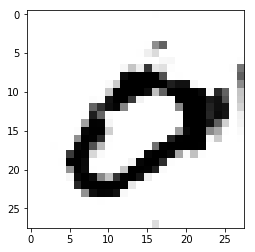

('Estimate:', array([[-1.46919131]], dtype=float32))
('Iteration:', 19000, 'at', datetime.datetime(2017, 10, 22, 22, 47, 10, 419792))


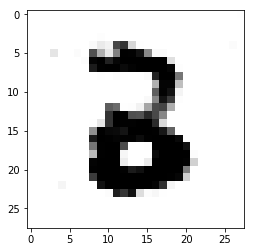

('Estimate:', array([[-0.87408137]], dtype=float32))
('Iteration:', 19100, 'at', datetime.datetime(2017, 10, 22, 22, 48, 13, 977401))


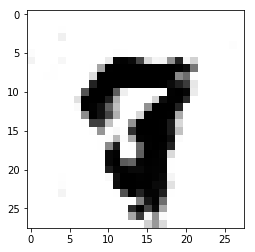

('Estimate:', array([[-1.83760035]], dtype=float32))
('Iteration:', 19200, 'at', datetime.datetime(2017, 10, 22, 22, 49, 18, 409829))


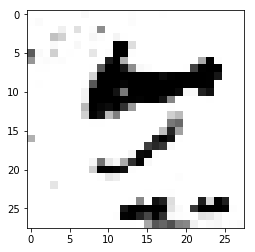

('Estimate:', array([[-1.09778881]], dtype=float32))
('Iteration:', 19300, 'at', datetime.datetime(2017, 10, 22, 22, 50, 30, 70715))


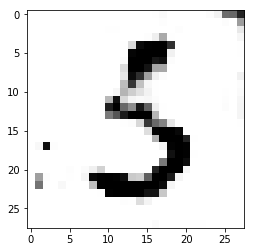

('Estimate:', array([[-3.67362976]], dtype=float32))
('Iteration:', 19400, 'at', datetime.datetime(2017, 10, 22, 22, 51, 37, 409574))


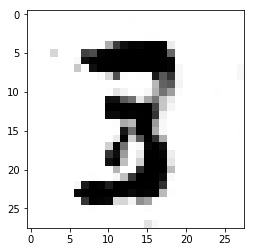

('Estimate:', array([[-2.24749899]], dtype=float32))
('Iteration:', 19500, 'at', datetime.datetime(2017, 10, 22, 22, 52, 48, 66403))


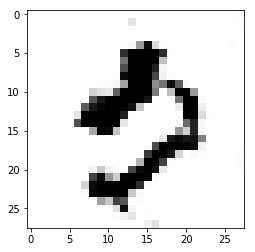

('Estimate:', array([[-2.10953045]], dtype=float32))
('Iteration:', 19600, 'at', datetime.datetime(2017, 10, 22, 22, 54, 1, 870863))


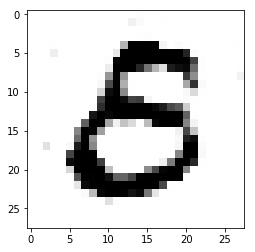

('Estimate:', array([[-1.44632173]], dtype=float32))
('Iteration:', 19700, 'at', datetime.datetime(2017, 10, 22, 22, 55, 22, 186176))


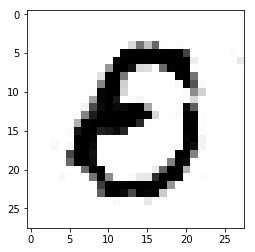

('Estimate:', array([[-3.27193117]], dtype=float32))
('Iteration:', 19800, 'at', datetime.datetime(2017, 10, 22, 22, 56, 38, 806070))


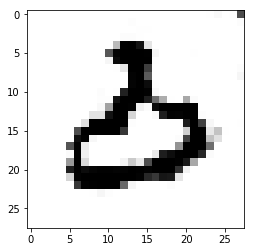

('Estimate:', array([[-0.16315126]], dtype=float32))
('Iteration:', 19900, 'at', datetime.datetime(2017, 10, 22, 22, 57, 49, 50298))


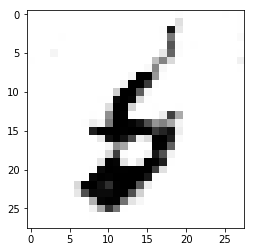

('Estimate:', array([[-1.99617231]], dtype=float32))
('Iteration:', 20000, 'at', datetime.datetime(2017, 10, 22, 22, 58, 54, 456995))


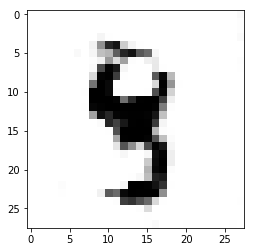

('Estimate:', array([[-1.27629578]], dtype=float32))
('Iteration:', 20100, 'at', datetime.datetime(2017, 10, 22, 23, 0, 0, 110201))


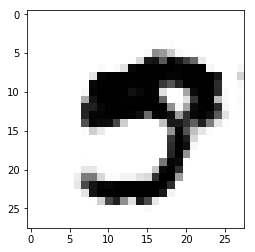

('Estimate:', array([[-3.82843733]], dtype=float32))
('Iteration:', 20200, 'at', datetime.datetime(2017, 10, 22, 23, 1, 5, 531669))


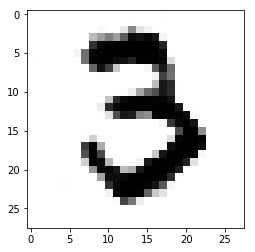

('Estimate:', array([[-1.6432972]], dtype=float32))
('Iteration:', 20300, 'at', datetime.datetime(2017, 10, 22, 23, 2, 10, 402412))


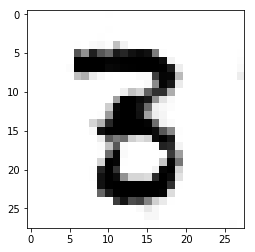

('Estimate:', array([[-0.24953575]], dtype=float32))
('Iteration:', 20400, 'at', datetime.datetime(2017, 10, 22, 23, 3, 16, 133879))


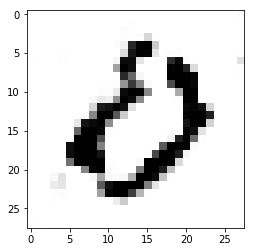

('Estimate:', array([[-2.19802189]], dtype=float32))
('Iteration:', 20500, 'at', datetime.datetime(2017, 10, 22, 23, 4, 21, 14579))


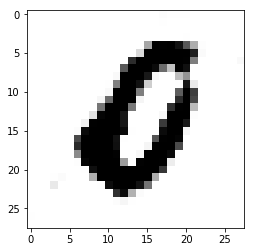

('Estimate:', array([[-2.81017041]], dtype=float32))
('Iteration:', 20600, 'at', datetime.datetime(2017, 10, 22, 23, 5, 26, 115699))


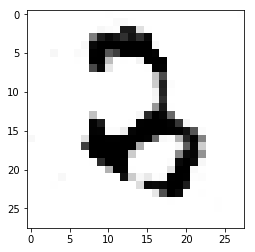

('Estimate:', array([[-1.92056203]], dtype=float32))
('Iteration:', 20700, 'at', datetime.datetime(2017, 10, 22, 23, 6, 30, 308647))


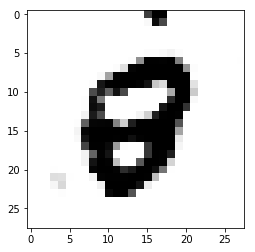

('Estimate:', array([[-2.29038095]], dtype=float32))
('Iteration:', 20800, 'at', datetime.datetime(2017, 10, 22, 23, 7, 35, 721195))


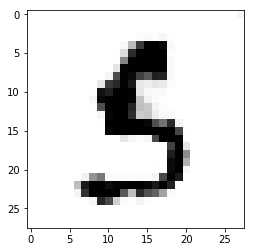

('Estimate:', array([[-0.67415547]], dtype=float32))
('Iteration:', 20900, 'at', datetime.datetime(2017, 10, 22, 23, 8, 40, 942499))


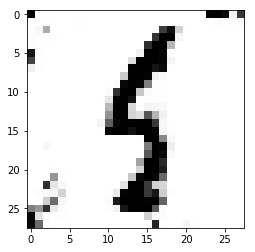

('Estimate:', array([[-1.48193944]], dtype=float32))
('Iteration:', 21000, 'at', datetime.datetime(2017, 10, 22, 23, 9, 46, 352831))


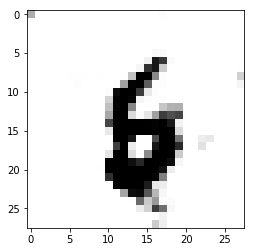

('Estimate:', array([[-1.86596382]], dtype=float32))
('Iteration:', 21100, 'at', datetime.datetime(2017, 10, 22, 23, 10, 51, 226677))


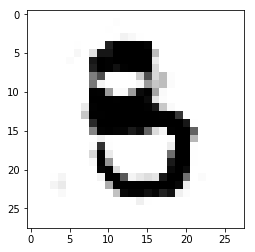

('Estimate:', array([[-0.49691004]], dtype=float32))
('Iteration:', 21200, 'at', datetime.datetime(2017, 10, 22, 23, 11, 56, 126114))


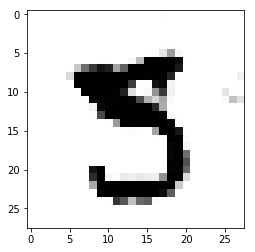

('Estimate:', array([[-0.18869457]], dtype=float32))
('Iteration:', 21300, 'at', datetime.datetime(2017, 10, 22, 23, 13, 1, 998792))


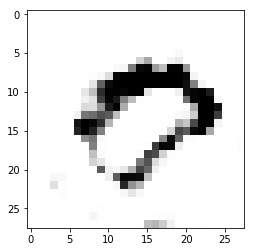

('Estimate:', array([[-2.44087148]], dtype=float32))
('Iteration:', 21400, 'at', datetime.datetime(2017, 10, 22, 23, 14, 7, 119619))


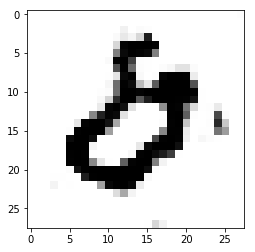

('Estimate:', array([[-2.70079041]], dtype=float32))
('Iteration:', 21500, 'at', datetime.datetime(2017, 10, 22, 23, 15, 14, 147649))


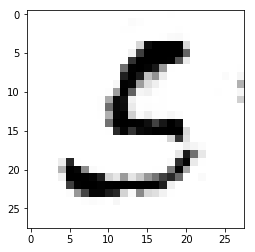

('Estimate:', array([[-1.78736627]], dtype=float32))
('Iteration:', 21600, 'at', datetime.datetime(2017, 10, 22, 23, 16, 18, 936383))


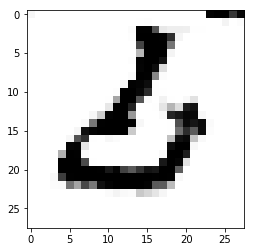

('Estimate:', array([[-0.64761674]], dtype=float32))
('Iteration:', 21700, 'at', datetime.datetime(2017, 10, 22, 23, 17, 24, 552249))


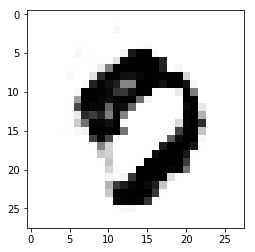

('Estimate:', array([[-0.85459834]], dtype=float32))
('Iteration:', 21800, 'at', datetime.datetime(2017, 10, 22, 23, 18, 29, 611575))


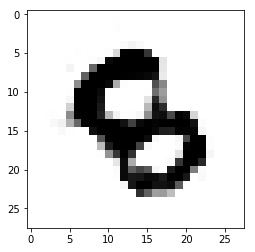

('Estimate:', array([[ 0.50496632]], dtype=float32))
('Iteration:', 21900, 'at', datetime.datetime(2017, 10, 22, 23, 19, 35, 264348))


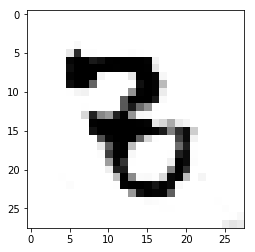

('Estimate:', array([[-1.04497337]], dtype=float32))
('Iteration:', 22000, 'at', datetime.datetime(2017, 10, 22, 23, 20, 40, 527623))


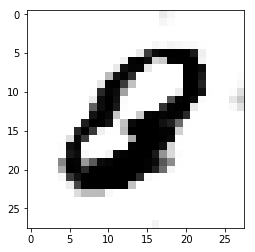

('Estimate:', array([[-1.72169995]], dtype=float32))
('Iteration:', 22100, 'at', datetime.datetime(2017, 10, 22, 23, 21, 45, 542407))


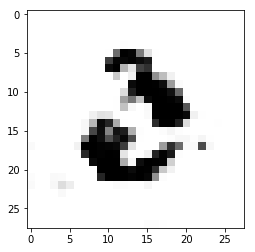

('Estimate:', array([[-3.88237405]], dtype=float32))
('Iteration:', 22200, 'at', datetime.datetime(2017, 10, 22, 23, 22, 51, 33595))


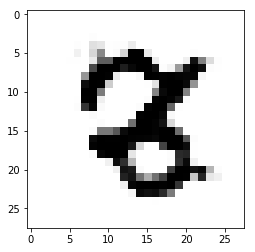

('Estimate:', array([[-2.6656661]], dtype=float32))
('Iteration:', 22300, 'at', datetime.datetime(2017, 10, 22, 23, 23, 56, 233189))


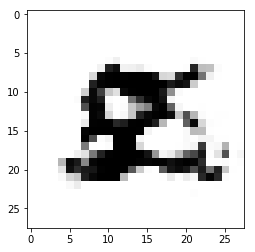

('Estimate:', array([[-1.82962656]], dtype=float32))
('Iteration:', 22400, 'at', datetime.datetime(2017, 10, 22, 23, 25, 1, 391138))


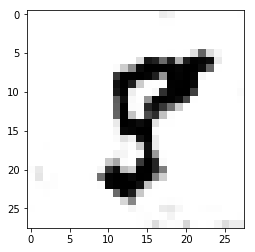

('Estimate:', array([[-2.71866012]], dtype=float32))
('Iteration:', 22500, 'at', datetime.datetime(2017, 10, 22, 23, 26, 6, 377705))


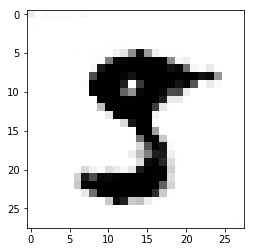

('Estimate:', array([[-1.31101716]], dtype=float32))
('Iteration:', 22600, 'at', datetime.datetime(2017, 10, 22, 23, 27, 11, 430461))


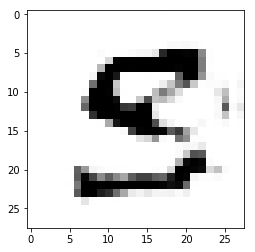

('Estimate:', array([[-1.43240798]], dtype=float32))
('Iteration:', 22700, 'at', datetime.datetime(2017, 10, 22, 23, 28, 16, 439602))


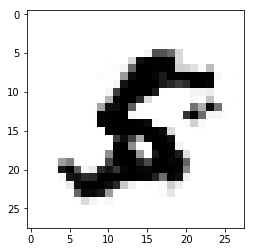

('Estimate:', array([[-2.16275716]], dtype=float32))
('Iteration:', 22800, 'at', datetime.datetime(2017, 10, 22, 23, 29, 21, 561865))


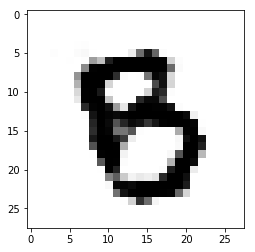

('Estimate:', array([[-2.17691255]], dtype=float32))
('Iteration:', 22900, 'at', datetime.datetime(2017, 10, 22, 23, 30, 26, 640299))


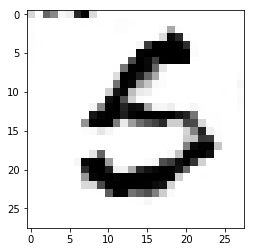

('Estimate:', array([[-2.02257204]], dtype=float32))
('Iteration:', 23000, 'at', datetime.datetime(2017, 10, 22, 23, 31, 31, 825398))


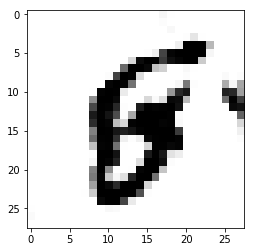

('Estimate:', array([[-1.1593684]], dtype=float32))
('Iteration:', 23100, 'at', datetime.datetime(2017, 10, 22, 23, 32, 37, 550542))


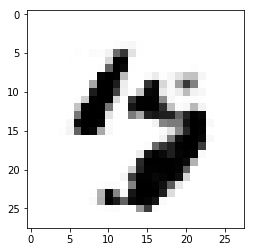

('Estimate:', array([[-3.59175515]], dtype=float32))
('Iteration:', 23200, 'at', datetime.datetime(2017, 10, 22, 23, 33, 42, 828325))


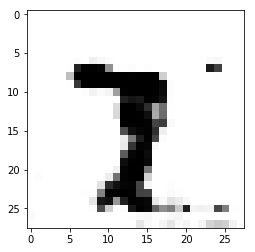

('Estimate:', array([[ 0.13598968]], dtype=float32))
('Iteration:', 23300, 'at', datetime.datetime(2017, 10, 22, 23, 34, 50, 98630))


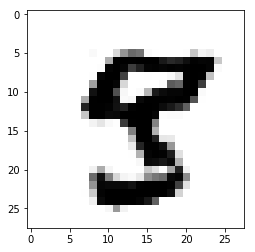

('Estimate:', array([[-0.67257309]], dtype=float32))
('Iteration:', 23400, 'at', datetime.datetime(2017, 10, 22, 23, 35, 55, 234302))


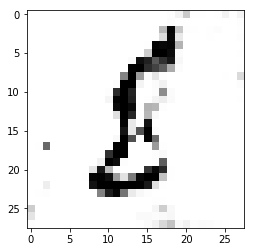

('Estimate:', array([[-0.94525838]], dtype=float32))
('Iteration:', 23500, 'at', datetime.datetime(2017, 10, 22, 23, 37, 0, 508332))


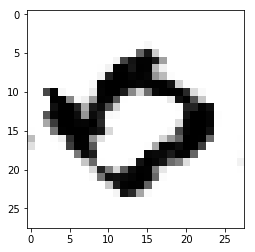

('Estimate:', array([[-3.92131186]], dtype=float32))
('Iteration:', 23600, 'at', datetime.datetime(2017, 10, 22, 23, 38, 6, 568992))


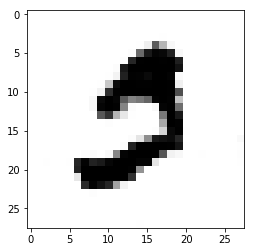

('Estimate:', array([[-1.50632179]], dtype=float32))
('Iteration:', 23700, 'at', datetime.datetime(2017, 10, 22, 23, 39, 11, 834644))


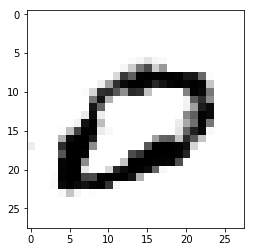

('Estimate:', array([[-1.51362705]], dtype=float32))
('Iteration:', 23800, 'at', datetime.datetime(2017, 10, 22, 23, 40, 16, 918914))


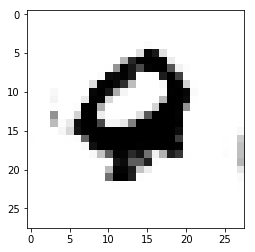

('Estimate:', array([[-2.09110498]], dtype=float32))
('Iteration:', 23900, 'at', datetime.datetime(2017, 10, 22, 23, 41, 22, 307294))


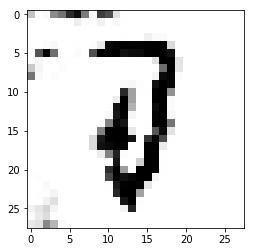

('Estimate:', array([[-2.0068121]], dtype=float32))
('Iteration:', 24000, 'at', datetime.datetime(2017, 10, 22, 23, 42, 27, 401487))


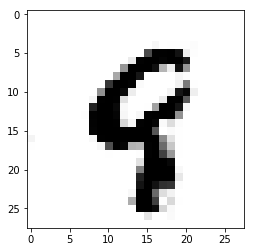

('Estimate:', array([[-1.98673594]], dtype=float32))
('Iteration:', 24100, 'at', datetime.datetime(2017, 10, 22, 23, 43, 32, 637985))


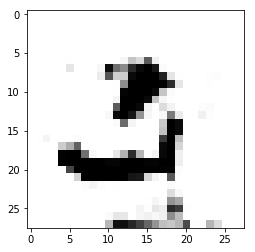

('Estimate:', array([[-2.2019105]], dtype=float32))
('Iteration:', 24200, 'at', datetime.datetime(2017, 10, 22, 23, 44, 37, 498526))


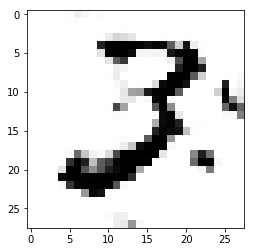

('Estimate:', array([[-1.14818788]], dtype=float32))
('Iteration:', 24300, 'at', datetime.datetime(2017, 10, 22, 23, 45, 42, 719443))


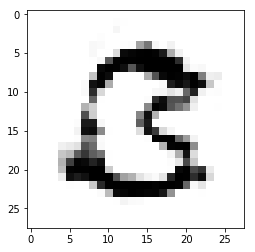

('Estimate:', array([[-2.33970785]], dtype=float32))
('Iteration:', 24400, 'at', datetime.datetime(2017, 10, 22, 23, 46, 47, 936896))


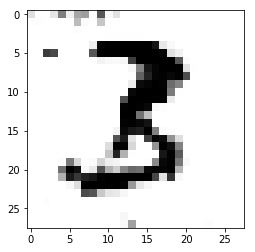

('Estimate:', array([[-2.31464744]], dtype=float32))
('Iteration:', 24500, 'at', datetime.datetime(2017, 10, 22, 23, 47, 53, 754165))


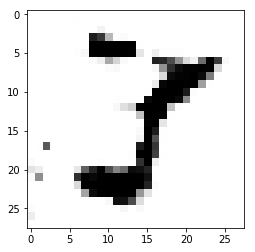

('Estimate:', array([[-3.78086734]], dtype=float32))
('Iteration:', 24600, 'at', datetime.datetime(2017, 10, 22, 23, 48, 58, 932043))


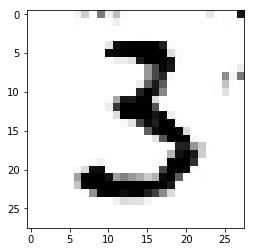

('Estimate:', array([[-2.65126133]], dtype=float32))
('Iteration:', 24700, 'at', datetime.datetime(2017, 10, 22, 23, 50, 4, 407380))


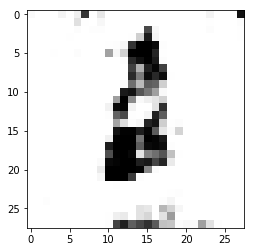

('Estimate:', array([[-2.92563629]], dtype=float32))
('Iteration:', 24800, 'at', datetime.datetime(2017, 10, 22, 23, 51, 9, 594378))


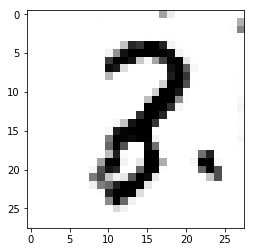

('Estimate:', array([[-1.16142678]], dtype=float32))
('Iteration:', 24900, 'at', datetime.datetime(2017, 10, 22, 23, 52, 14, 666112))


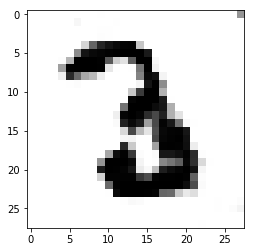

('Estimate:', array([[-3.56379962]], dtype=float32))
('Iteration:', 25000, 'at', datetime.datetime(2017, 10, 22, 23, 53, 20, 126316))


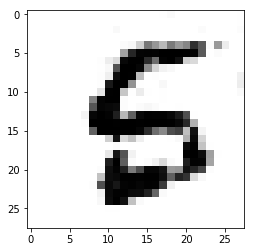

('Estimate:', array([[-3.30080247]], dtype=float32))
('Iteration:', 25100, 'at', datetime.datetime(2017, 10, 22, 23, 54, 25, 259072))


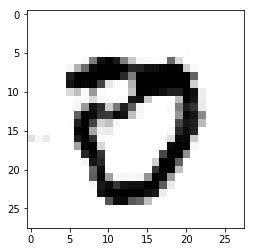

('Estimate:', array([[-3.68909144]], dtype=float32))
('Iteration:', 25200, 'at', datetime.datetime(2017, 10, 22, 23, 55, 32, 675642))


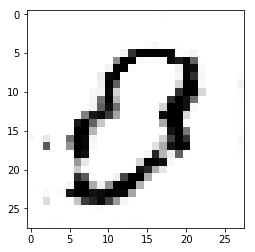

('Estimate:', array([[-6.22563028]], dtype=float32))
('Iteration:', 25300, 'at', datetime.datetime(2017, 10, 22, 23, 56, 39, 193603))


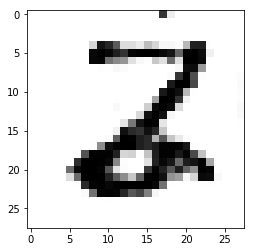

('Estimate:', array([[-0.44967228]], dtype=float32))
('Iteration:', 25400, 'at', datetime.datetime(2017, 10, 22, 23, 57, 44, 436370))


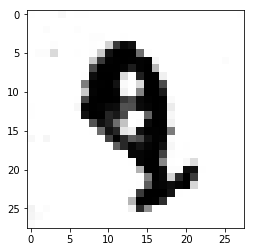

('Estimate:', array([[-0.48732546]], dtype=float32))
('Iteration:', 25500, 'at', datetime.datetime(2017, 10, 22, 23, 58, 50, 237980))


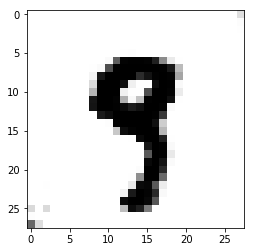

('Estimate:', array([[-1.83794558]], dtype=float32))
('Iteration:', 25600, 'at', datetime.datetime(2017, 10, 22, 23, 59, 55, 539232))


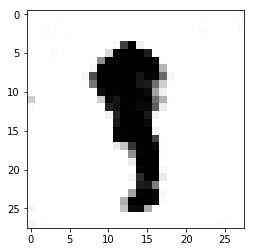

('Estimate:', array([[-1.53461039]], dtype=float32))
('Iteration:', 25700, 'at', datetime.datetime(2017, 10, 23, 0, 1, 1, 14703))


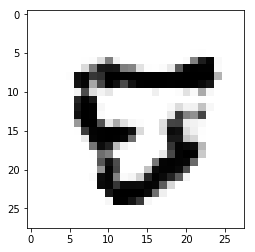

('Estimate:', array([[-5.25547361]], dtype=float32))
('Iteration:', 25800, 'at', datetime.datetime(2017, 10, 23, 0, 2, 5, 904641))


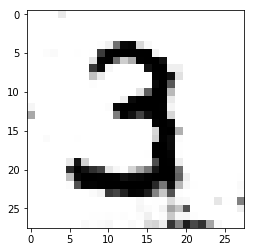

('Estimate:', array([[-1.74257696]], dtype=float32))
('Iteration:', 25900, 'at', datetime.datetime(2017, 10, 23, 0, 3, 11, 193415))


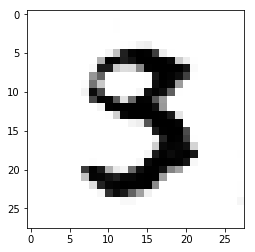

('Estimate:', array([[-2.37838793]], dtype=float32))
('Iteration:', 26000, 'at', datetime.datetime(2017, 10, 23, 0, 4, 16, 943489))


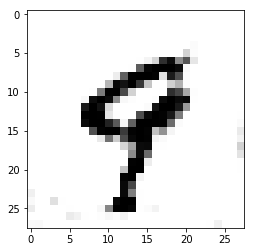

('Estimate:', array([[-1.04983079]], dtype=float32))
('Iteration:', 26100, 'at', datetime.datetime(2017, 10, 23, 0, 5, 22, 291049))


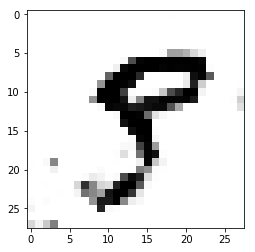

('Estimate:', array([[-2.98435497]], dtype=float32))
('Iteration:', 26200, 'at', datetime.datetime(2017, 10, 23, 0, 6, 27, 452400))


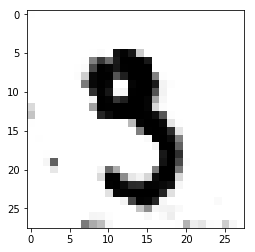

('Estimate:', array([[-2.02797985]], dtype=float32))
('Iteration:', 26300, 'at', datetime.datetime(2017, 10, 23, 0, 7, 32, 661395))


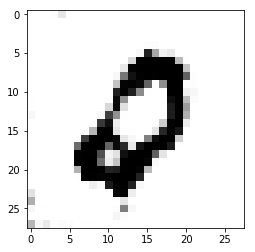

('Estimate:', array([[-3.70737052]], dtype=float32))
('Iteration:', 26400, 'at', datetime.datetime(2017, 10, 23, 0, 8, 38, 593079))


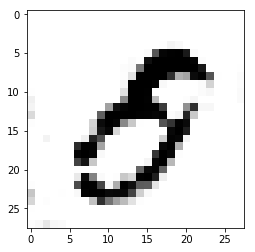

('Estimate:', array([[-2.54702735]], dtype=float32))
('Iteration:', 26500, 'at', datetime.datetime(2017, 10, 23, 0, 9, 44, 9823))


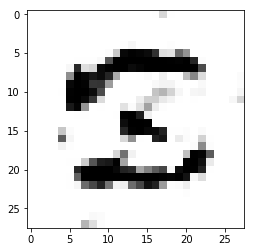

('Estimate:', array([[-4.17629528]], dtype=float32))
('Iteration:', 26600, 'at', datetime.datetime(2017, 10, 23, 0, 10, 49, 78053))


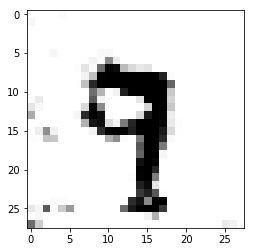

('Estimate:', array([[-1.72027683]], dtype=float32))
('Iteration:', 26700, 'at', datetime.datetime(2017, 10, 23, 0, 11, 56, 264384))


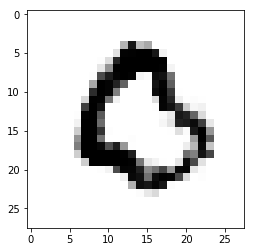

('Estimate:', array([[-1.14767063]], dtype=float32))
('Iteration:', 26800, 'at', datetime.datetime(2017, 10, 23, 0, 13, 2, 347682))


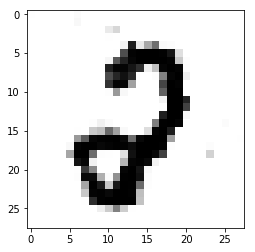

('Estimate:', array([[-1.97142816]], dtype=float32))
('Iteration:', 26900, 'at', datetime.datetime(2017, 10, 23, 0, 14, 8, 301190))


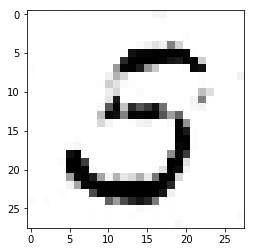

('Estimate:', array([[-2.32628918]], dtype=float32))
('Iteration:', 27000, 'at', datetime.datetime(2017, 10, 23, 0, 15, 14, 204427))


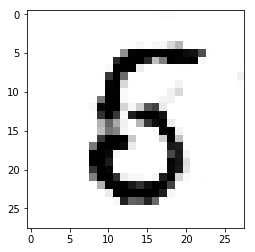

('Estimate:', array([[-1.68509912]], dtype=float32))
('Iteration:', 27100, 'at', datetime.datetime(2017, 10, 23, 0, 16, 21, 336872))


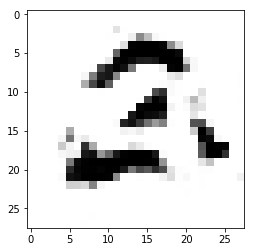

('Estimate:', array([[-0.48024639]], dtype=float32))
('Iteration:', 27200, 'at', datetime.datetime(2017, 10, 23, 0, 17, 28, 186928))


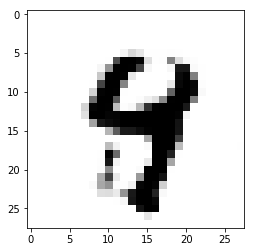

('Estimate:', array([[-1.87028396]], dtype=float32))
('Iteration:', 27300, 'at', datetime.datetime(2017, 10, 23, 0, 18, 34, 872411))


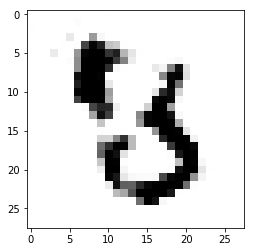

('Estimate:', array([[-3.87956476]], dtype=float32))
('Iteration:', 27400, 'at', datetime.datetime(2017, 10, 23, 0, 19, 40, 548356))


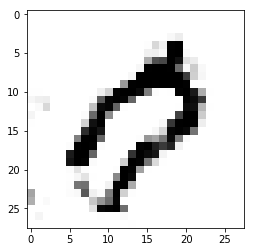

('Estimate:', array([[-4.29131889]], dtype=float32))
('Iteration:', 27500, 'at', datetime.datetime(2017, 10, 23, 0, 20, 46, 84501))


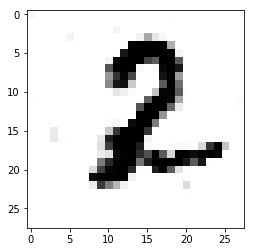

('Estimate:', array([[-1.16269684]], dtype=float32))
('Iteration:', 27600, 'at', datetime.datetime(2017, 10, 23, 0, 21, 51, 387345))


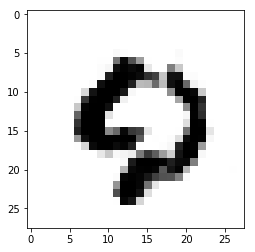

('Estimate:', array([[-3.27044797]], dtype=float32))
('Iteration:', 27700, 'at', datetime.datetime(2017, 10, 23, 0, 22, 57, 128554))


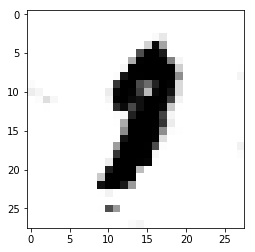

('Estimate:', array([[-4.25240612]], dtype=float32))
('Iteration:', 27800, 'at', datetime.datetime(2017, 10, 23, 0, 24, 2, 475387))


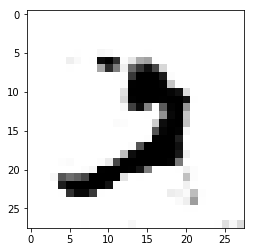

('Estimate:', array([[-4.40904474]], dtype=float32))
('Iteration:', 27900, 'at', datetime.datetime(2017, 10, 23, 0, 25, 7, 860562))


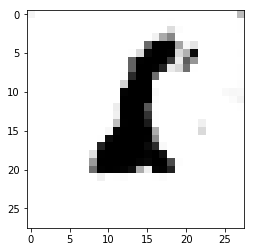

('Estimate:', array([[-0.39107084]], dtype=float32))
('Iteration:', 28000, 'at', datetime.datetime(2017, 10, 23, 0, 26, 12, 933783))


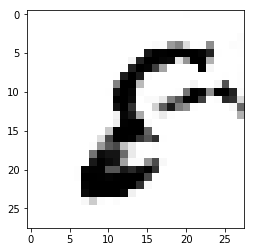

('Estimate:', array([[-0.13208127]], dtype=float32))
('Iteration:', 28100, 'at', datetime.datetime(2017, 10, 23, 0, 27, 18, 249735))


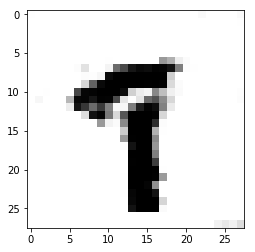

('Estimate:', array([[-3.21042252]], dtype=float32))
('Iteration:', 28200, 'at', datetime.datetime(2017, 10, 23, 0, 28, 23, 353900))


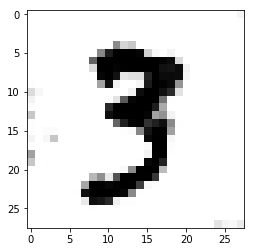

('Estimate:', array([[-2.36159325]], dtype=float32))
('Iteration:', 28300, 'at', datetime.datetime(2017, 10, 23, 0, 29, 31, 177823))


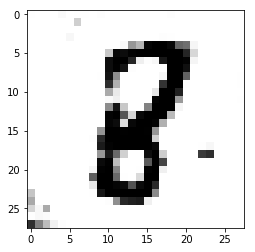

('Estimate:', array([[-2.74400401]], dtype=float32))
('Iteration:', 28400, 'at', datetime.datetime(2017, 10, 23, 0, 30, 36, 484155))


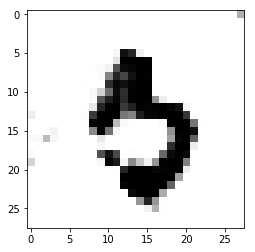

('Estimate:', array([[-5.90550232]], dtype=float32))
('Iteration:', 28500, 'at', datetime.datetime(2017, 10, 23, 0, 31, 41, 668863))


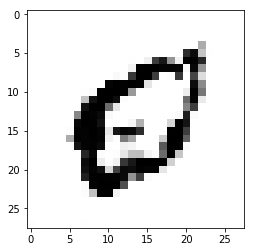

('Estimate:', array([[-5.63025141]], dtype=float32))
('Iteration:', 28600, 'at', datetime.datetime(2017, 10, 23, 0, 32, 46, 824907))


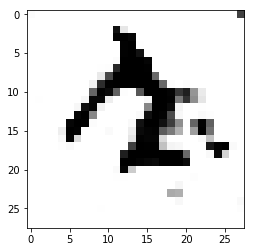

('Estimate:', array([[-2.9412272]], dtype=float32))
('Iteration:', 28700, 'at', datetime.datetime(2017, 10, 23, 0, 33, 52, 822002))


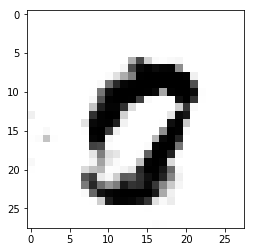

('Estimate:', array([[-4.53512049]], dtype=float32))
('Iteration:', 28800, 'at', datetime.datetime(2017, 10, 23, 0, 34, 58, 357733))


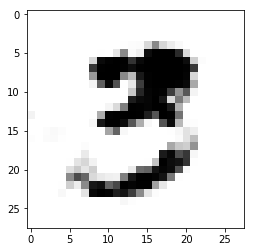

('Estimate:', array([[-4.00770044]], dtype=float32))
('Iteration:', 28900, 'at', datetime.datetime(2017, 10, 23, 0, 36, 3, 518080))


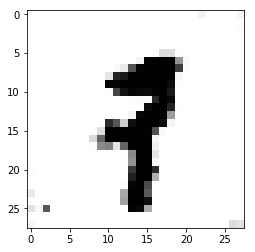

('Estimate:', array([[-2.32323909]], dtype=float32))
('Iteration:', 29000, 'at', datetime.datetime(2017, 10, 23, 0, 37, 9, 86049))


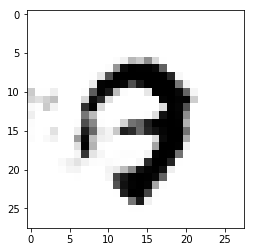

('Estimate:', array([[-6.15559053]], dtype=float32))
('Iteration:', 29100, 'at', datetime.datetime(2017, 10, 23, 0, 38, 14, 407361))


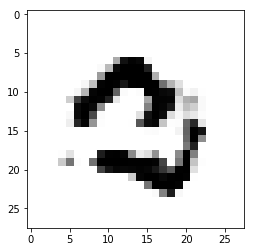

('Estimate:', array([[-4.26906443]], dtype=float32))
('Iteration:', 29200, 'at', datetime.datetime(2017, 10, 23, 0, 39, 19, 542232))


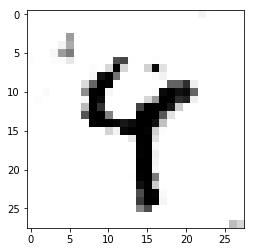

('Estimate:', array([[-2.44882584]], dtype=float32))
('Iteration:', 29300, 'at', datetime.datetime(2017, 10, 23, 0, 40, 24, 907027))


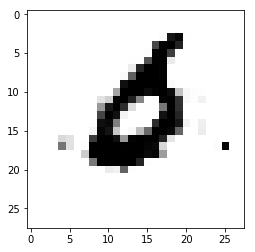

('Estimate:', array([[-3.85204244]], dtype=float32))
('Iteration:', 29400, 'at', datetime.datetime(2017, 10, 23, 0, 41, 30, 333758))


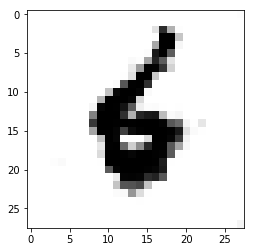

('Estimate:', array([[-0.93505526]], dtype=float32))
('Iteration:', 29500, 'at', datetime.datetime(2017, 10, 23, 0, 42, 35, 456039))


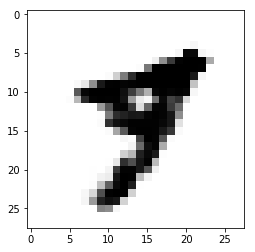

('Estimate:', array([[-5.03315258]], dtype=float32))
('Iteration:', 29600, 'at', datetime.datetime(2017, 10, 23, 0, 43, 40, 899054))


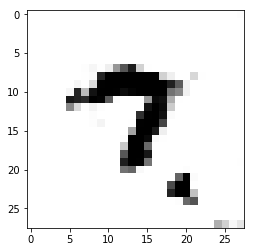

('Estimate:', array([[-4.98087502]], dtype=float32))
('Iteration:', 29700, 'at', datetime.datetime(2017, 10, 23, 0, 44, 46, 213533))


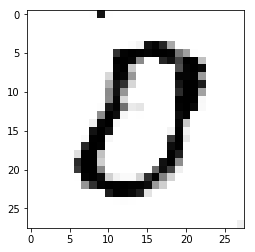

('Estimate:', array([[-2.95860243]], dtype=float32))
('Iteration:', 29800, 'at', datetime.datetime(2017, 10, 23, 0, 45, 52, 242697))


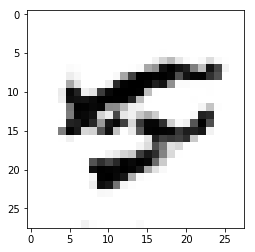

('Estimate:', array([[-1.71520412]], dtype=float32))
('Iteration:', 29900, 'at', datetime.datetime(2017, 10, 23, 0, 46, 58, 258250))


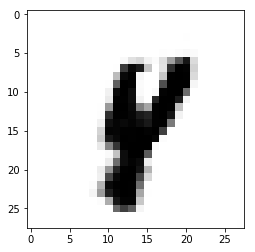

('Estimate:', array([[-3.43918562]], dtype=float32))
('Iteration:', 30000, 'at', datetime.datetime(2017, 10, 23, 0, 48, 3, 889529))


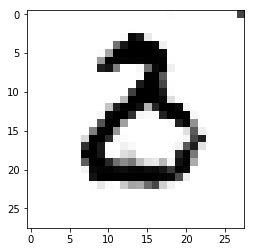

('Estimate:', array([[-3.04798102]], dtype=float32))
('Iteration:', 30100, 'at', datetime.datetime(2017, 10, 23, 0, 49, 9, 502450))


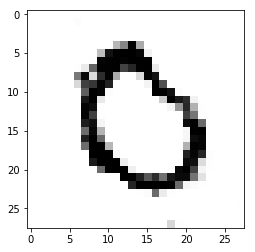

('Estimate:', array([[-3.78266072]], dtype=float32))
('Iteration:', 30200, 'at', datetime.datetime(2017, 10, 23, 0, 50, 14, 734541))


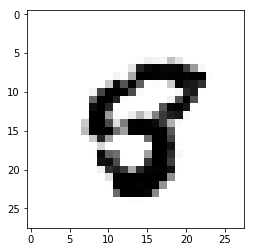

('Estimate:', array([[-4.68994808]], dtype=float32))
('Iteration:', 30300, 'at', datetime.datetime(2017, 10, 23, 0, 51, 19, 963374))


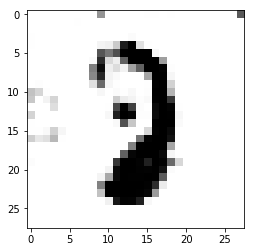

('Estimate:', array([[-3.71505046]], dtype=float32))
('Iteration:', 30400, 'at', datetime.datetime(2017, 10, 23, 0, 52, 25, 97134))


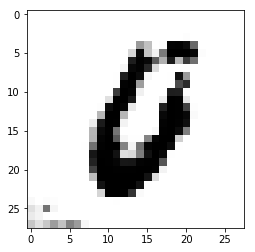

('Estimate:', array([[-6.68414736]], dtype=float32))
('Iteration:', 30500, 'at', datetime.datetime(2017, 10, 23, 0, 53, 30, 679082))


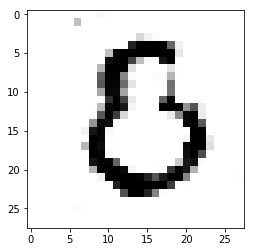

('Estimate:', array([[-1.43879461]], dtype=float32))
('Iteration:', 30600, 'at', datetime.datetime(2017, 10, 23, 0, 54, 36, 144898))


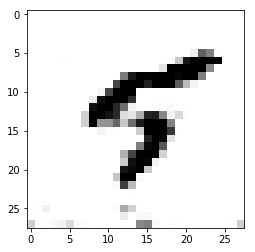

('Estimate:', array([[-5.00627518]], dtype=float32))
('Iteration:', 30700, 'at', datetime.datetime(2017, 10, 23, 0, 55, 41, 798012))


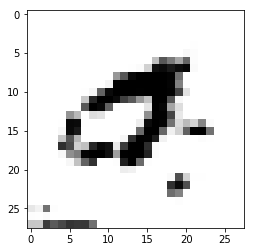

('Estimate:', array([[-0.75245959]], dtype=float32))
('Iteration:', 30800, 'at', datetime.datetime(2017, 10, 23, 0, 56, 47, 428203))


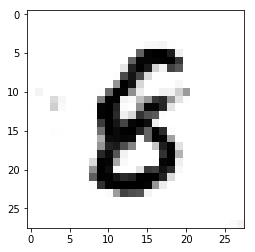

('Estimate:', array([[-6.04488277]], dtype=float32))
('Iteration:', 30900, 'at', datetime.datetime(2017, 10, 23, 0, 57, 53, 598386))


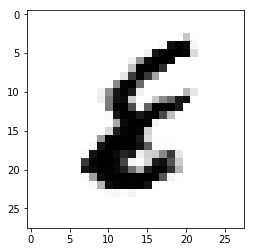

('Estimate:', array([[-3.03503585]], dtype=float32))
('Iteration:', 31000, 'at', datetime.datetime(2017, 10, 23, 0, 58, 59, 594951))


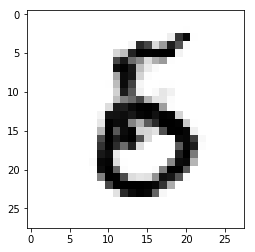

('Estimate:', array([[-3.10490966]], dtype=float32))
('Iteration:', 31100, 'at', datetime.datetime(2017, 10, 23, 1, 0, 5, 499941))


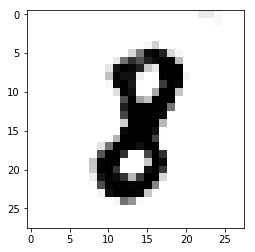

('Estimate:', array([[-3.6931901]], dtype=float32))
('Iteration:', 31200, 'at', datetime.datetime(2017, 10, 23, 1, 1, 11, 604716))


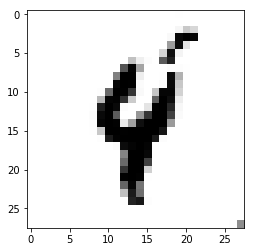

('Estimate:', array([[-4.95028162]], dtype=float32))
('Iteration:', 31300, 'at', datetime.datetime(2017, 10, 23, 1, 2, 17, 186183))


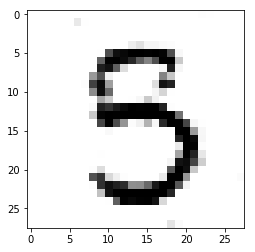

('Estimate:', array([[-2.76670885]], dtype=float32))
('Iteration:', 31400, 'at', datetime.datetime(2017, 10, 23, 1, 3, 22, 800555))


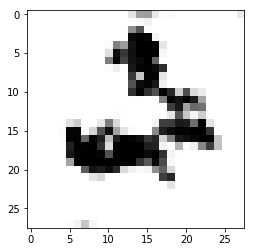

('Estimate:', array([[-1.48098528]], dtype=float32))
('Iteration:', 31500, 'at', datetime.datetime(2017, 10, 23, 1, 4, 28, 268377))


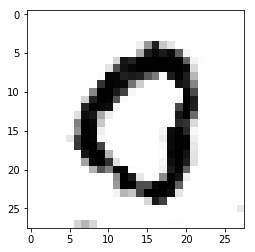

('Estimate:', array([[-3.11423326]], dtype=float32))
('Iteration:', 31600, 'at', datetime.datetime(2017, 10, 23, 1, 5, 34, 466085))


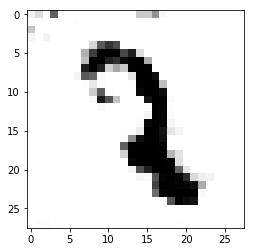

('Estimate:', array([[-5.14022207]], dtype=float32))
('Iteration:', 31700, 'at', datetime.datetime(2017, 10, 23, 1, 6, 40, 826346))


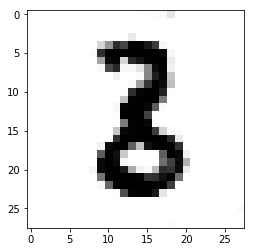

('Estimate:', array([[-1.9332056]], dtype=float32))
('Iteration:', 31800, 'at', datetime.datetime(2017, 10, 23, 1, 7, 46, 557160))


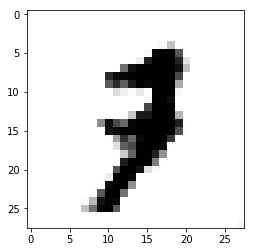

('Estimate:', array([[-4.61314535]], dtype=float32))
('Iteration:', 31900, 'at', datetime.datetime(2017, 10, 23, 1, 8, 51, 899226))


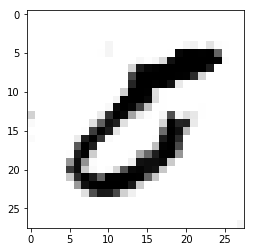

('Estimate:', array([[-5.82055187]], dtype=float32))
('Iteration:', 32000, 'at', datetime.datetime(2017, 10, 23, 1, 9, 57, 692668))


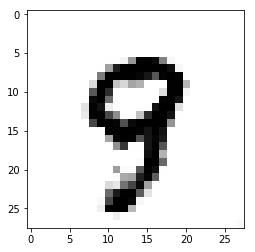

('Estimate:', array([[-3.03230953]], dtype=float32))
('Iteration:', 32100, 'at', datetime.datetime(2017, 10, 23, 1, 11, 4, 194961))


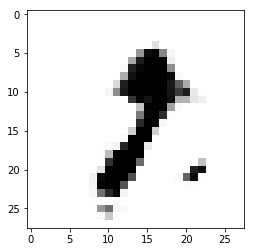

('Estimate:', array([[-5.51116467]], dtype=float32))
('Iteration:', 32200, 'at', datetime.datetime(2017, 10, 23, 1, 12, 9, 737488))


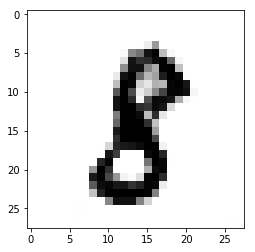

('Estimate:', array([[-2.79020715]], dtype=float32))
('Iteration:', 32300, 'at', datetime.datetime(2017, 10, 23, 1, 13, 16, 548220))


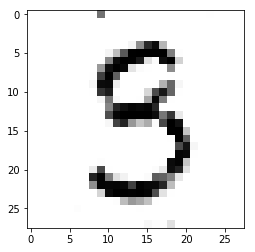

('Estimate:', array([[-3.90244722]], dtype=float32))
('Iteration:', 32400, 'at', datetime.datetime(2017, 10, 23, 1, 14, 21, 843105))


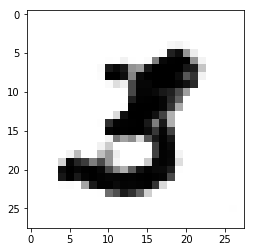

('Estimate:', array([[-6.3241353]], dtype=float32))
('Iteration:', 32500, 'at', datetime.datetime(2017, 10, 23, 1, 15, 27, 372163))


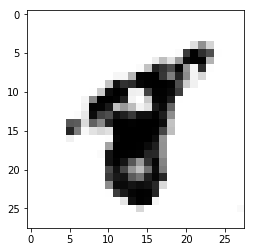

('Estimate:', array([[-5.62143278]], dtype=float32))
('Iteration:', 32600, 'at', datetime.datetime(2017, 10, 23, 1, 16, 33, 27074))


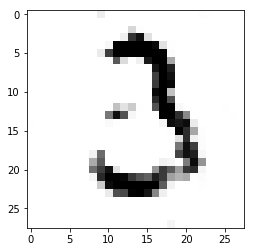

('Estimate:', array([[-6.43287468]], dtype=float32))
('Iteration:', 32700, 'at', datetime.datetime(2017, 10, 23, 1, 17, 38, 809491))


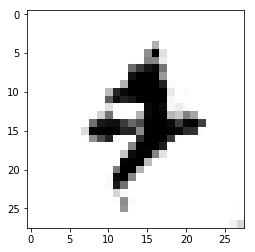

('Estimate:', array([[-4.64296246]], dtype=float32))
('Iteration:', 32800, 'at', datetime.datetime(2017, 10, 23, 1, 18, 44, 802351))


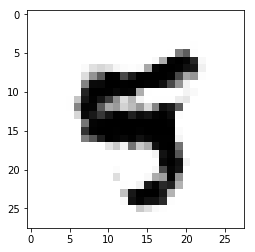

('Estimate:', array([[-5.09281349]], dtype=float32))
('Iteration:', 32900, 'at', datetime.datetime(2017, 10, 23, 1, 19, 50, 311169))


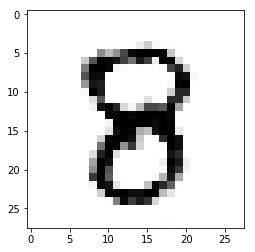

('Estimate:', array([[-3.60366249]], dtype=float32))
('Iteration:', 33000, 'at', datetime.datetime(2017, 10, 23, 1, 20, 55, 637431))


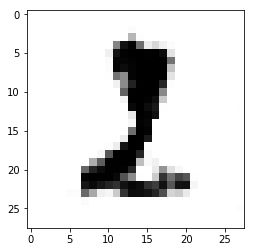

('Estimate:', array([[-2.1675806]], dtype=float32))
('Iteration:', 33100, 'at', datetime.datetime(2017, 10, 23, 1, 22, 1, 391090))


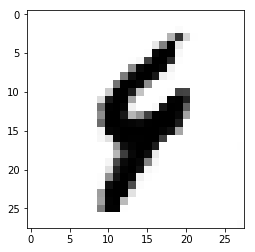

('Estimate:', array([[-2.77588987]], dtype=float32))
('Iteration:', 33200, 'at', datetime.datetime(2017, 10, 23, 1, 23, 7, 421990))


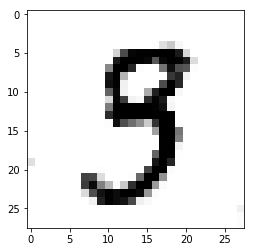

('Estimate:', array([[-4.55250454]], dtype=float32))
('Iteration:', 33300, 'at', datetime.datetime(2017, 10, 23, 1, 24, 13, 494589))


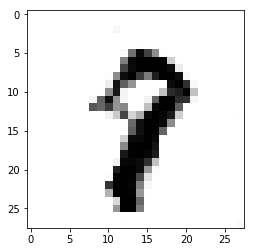

('Estimate:', array([[-0.35476589]], dtype=float32))
('Iteration:', 33400, 'at', datetime.datetime(2017, 10, 23, 1, 25, 19, 42863))


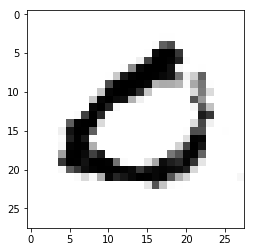

('Estimate:', array([[-3.28643966]], dtype=float32))
('Iteration:', 33500, 'at', datetime.datetime(2017, 10, 23, 1, 26, 25, 191769))


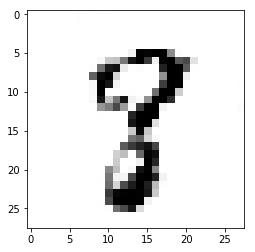

('Estimate:', array([[-6.39469719]], dtype=float32))
('Iteration:', 33600, 'at', datetime.datetime(2017, 10, 23, 1, 27, 31, 792153))


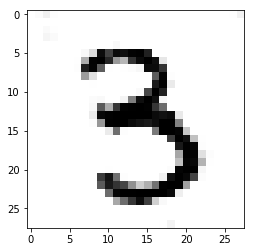

('Estimate:', array([[-3.46619344]], dtype=float32))
('Iteration:', 33700, 'at', datetime.datetime(2017, 10, 23, 1, 28, 37, 806536))


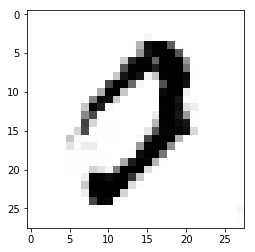

('Estimate:', array([[-4.22285223]], dtype=float32))
('Iteration:', 33800, 'at', datetime.datetime(2017, 10, 23, 1, 29, 43, 728418))


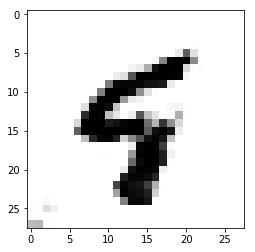

('Estimate:', array([[-3.45934153]], dtype=float32))
('Iteration:', 33900, 'at', datetime.datetime(2017, 10, 23, 1, 30, 49, 108571))


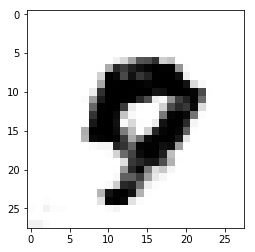

('Estimate:', array([[-2.81971169]], dtype=float32))
('Iteration:', 34000, 'at', datetime.datetime(2017, 10, 23, 1, 31, 54, 624812))


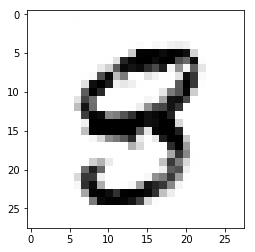

('Estimate:', array([[-2.61693287]], dtype=float32))
('Iteration:', 34100, 'at', datetime.datetime(2017, 10, 23, 1, 33, 0, 246786))


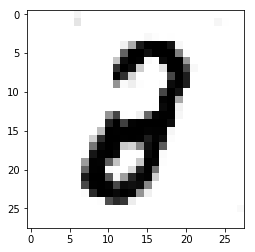

('Estimate:', array([[-4.4127903]], dtype=float32))
('Iteration:', 34200, 'at', datetime.datetime(2017, 10, 23, 1, 34, 6, 15147))


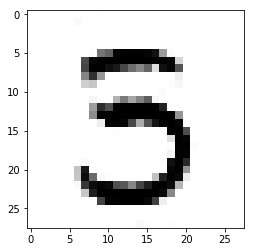

('Estimate:', array([[-3.68865776]], dtype=float32))
('Iteration:', 34300, 'at', datetime.datetime(2017, 10, 23, 1, 35, 12, 270729))


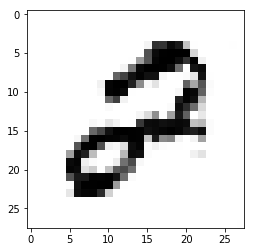

('Estimate:', array([[-3.43259382]], dtype=float32))
('Iteration:', 34400, 'at', datetime.datetime(2017, 10, 23, 1, 36, 17, 704568))


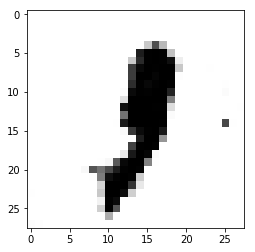

('Estimate:', array([[-3.41993976]], dtype=float32))
('Iteration:', 34500, 'at', datetime.datetime(2017, 10, 23, 1, 37, 23, 675553))


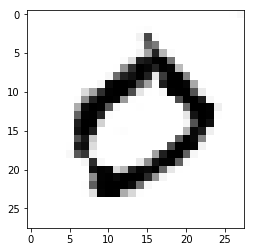

('Estimate:', array([[-4.68996572]], dtype=float32))
('Iteration:', 34600, 'at', datetime.datetime(2017, 10, 23, 1, 38, 29, 125834))


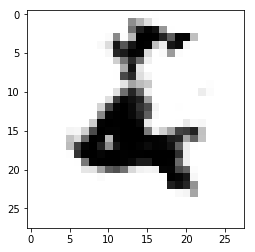

('Estimate:', array([[-6.74402761]], dtype=float32))
('Iteration:', 34700, 'at', datetime.datetime(2017, 10, 23, 1, 39, 34, 772280))


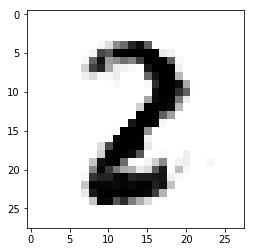

('Estimate:', array([[-5.57098722]], dtype=float32))
('Iteration:', 34800, 'at', datetime.datetime(2017, 10, 23, 1, 40, 40, 221090))


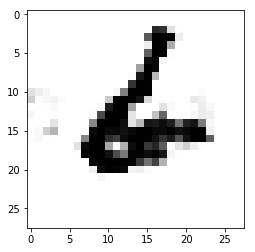

('Estimate:', array([[ 3.43123341]], dtype=float32))
('Iteration:', 34900, 'at', datetime.datetime(2017, 10, 23, 1, 41, 46, 4850))


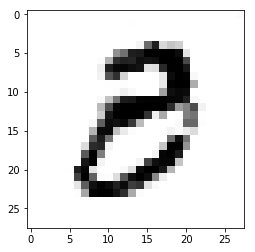

('Estimate:', array([[-5.29572201]], dtype=float32))
('Iteration:', 35000, 'at', datetime.datetime(2017, 10, 23, 1, 42, 51, 309785))


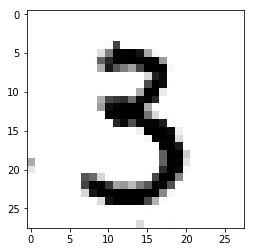

('Estimate:', array([[-4.32531214]], dtype=float32))
('Iteration:', 35100, 'at', datetime.datetime(2017, 10, 23, 1, 43, 57, 39201))


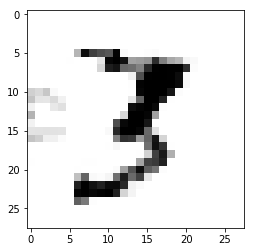

('Estimate:', array([[-2.72274923]], dtype=float32))
('Iteration:', 35200, 'at', datetime.datetime(2017, 10, 23, 1, 45, 2, 864194))


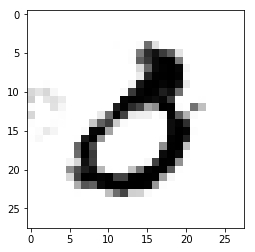

('Estimate:', array([[-3.70562983]], dtype=float32))
('Iteration:', 35300, 'at', datetime.datetime(2017, 10, 23, 1, 46, 8, 611606))


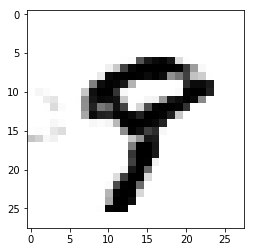

('Estimate:', array([[-4.97651863]], dtype=float32))
('Iteration:', 35400, 'at', datetime.datetime(2017, 10, 23, 1, 47, 16, 497831))


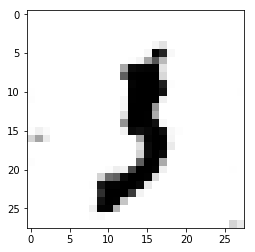

('Estimate:', array([[-6.80483103]], dtype=float32))
('Iteration:', 35500, 'at', datetime.datetime(2017, 10, 23, 1, 48, 22, 220230))


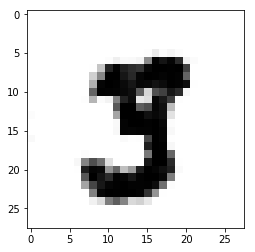

('Estimate:', array([[-7.45076084]], dtype=float32))
('Iteration:', 35600, 'at', datetime.datetime(2017, 10, 23, 1, 49, 28, 871892))


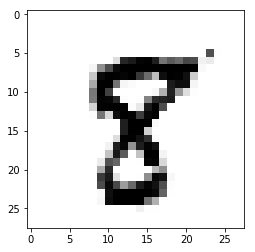

('Estimate:', array([[-1.93023396]], dtype=float32))
('Iteration:', 35700, 'at', datetime.datetime(2017, 10, 23, 1, 50, 34, 632521))


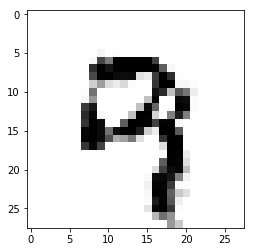

('Estimate:', array([[-3.78377056]], dtype=float32))
('Iteration:', 35800, 'at', datetime.datetime(2017, 10, 23, 1, 51, 40, 502893))


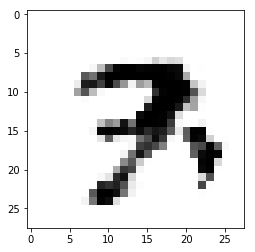

('Estimate:', array([[-0.77464658]], dtype=float32))
('Iteration:', 35900, 'at', datetime.datetime(2017, 10, 23, 1, 52, 46, 552433))


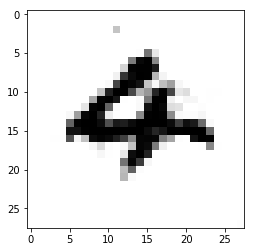

('Estimate:', array([[-4.54888058]], dtype=float32))
('Iteration:', 36000, 'at', datetime.datetime(2017, 10, 23, 1, 53, 52, 329242))


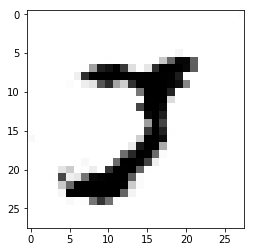

('Estimate:', array([[-5.95199108]], dtype=float32))
('Iteration:', 36100, 'at', datetime.datetime(2017, 10, 23, 1, 54, 57, 877744))


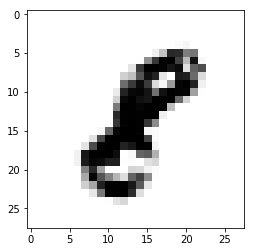

('Estimate:', array([[ 0.20734896]], dtype=float32))
('Iteration:', 36200, 'at', datetime.datetime(2017, 10, 23, 1, 56, 3, 741816))


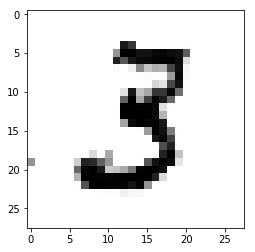

('Estimate:', array([[-4.77582502]], dtype=float32))
('Iteration:', 36300, 'at', datetime.datetime(2017, 10, 23, 1, 57, 9, 443594))


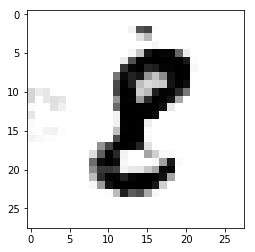

('Estimate:', array([[-2.47526646]], dtype=float32))
('Iteration:', 36400, 'at', datetime.datetime(2017, 10, 23, 1, 58, 15, 65667))


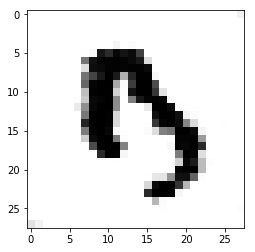

('Estimate:', array([[-7.80360508]], dtype=float32))
('Iteration:', 36500, 'at', datetime.datetime(2017, 10, 23, 1, 59, 20, 840615))


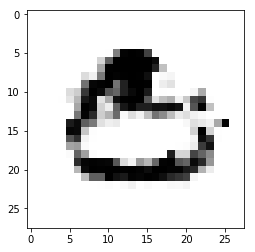

('Estimate:', array([[-8.51112938]], dtype=float32))
('Iteration:', 36600, 'at', datetime.datetime(2017, 10, 23, 2, 0, 26, 703860))


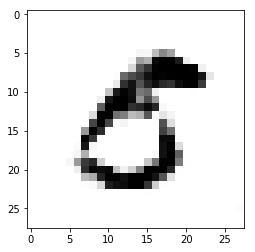

('Estimate:', array([[-7.39435816]], dtype=float32))
('Iteration:', 36700, 'at', datetime.datetime(2017, 10, 23, 2, 1, 32, 698581))


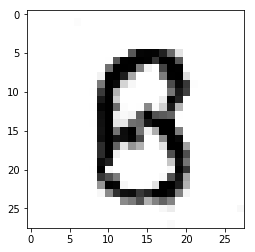

('Estimate:', array([[-4.28394985]], dtype=float32))
('Iteration:', 36800, 'at', datetime.datetime(2017, 10, 23, 2, 2, 38, 900185))


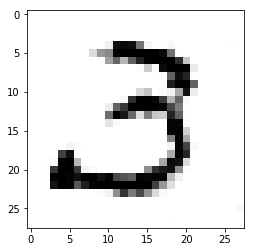

('Estimate:', array([[-1.23779464]], dtype=float32))
('Iteration:', 36900, 'at', datetime.datetime(2017, 10, 23, 2, 3, 45, 382849))


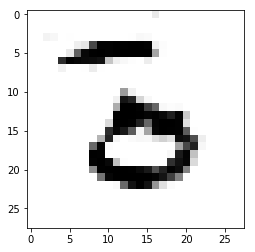

('Estimate:', array([[-4.81167364]], dtype=float32))
('Iteration:', 37000, 'at', datetime.datetime(2017, 10, 23, 2, 4, 52, 83597))


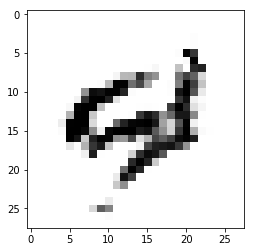

('Estimate:', array([[-5.03739691]], dtype=float32))
('Iteration:', 37100, 'at', datetime.datetime(2017, 10, 23, 2, 5, 59, 507207))


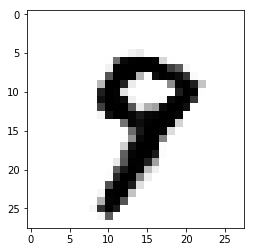

('Estimate:', array([[-0.92816603]], dtype=float32))
('Iteration:', 37200, 'at', datetime.datetime(2017, 10, 23, 2, 7, 6, 184932))


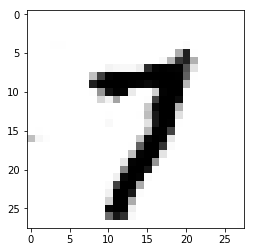

('Estimate:', array([[-4.33206701]], dtype=float32))
('Iteration:', 37300, 'at', datetime.datetime(2017, 10, 23, 2, 8, 12, 131358))


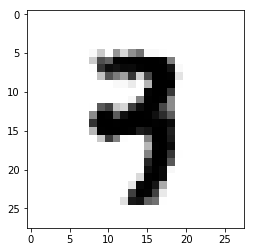

('Estimate:', array([[-2.14520216]], dtype=float32))
('Iteration:', 37400, 'at', datetime.datetime(2017, 10, 23, 2, 9, 18, 140233))


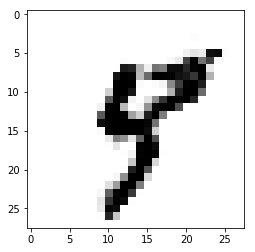

('Estimate:', array([[-7.6264081]], dtype=float32))
('Iteration:', 37500, 'at', datetime.datetime(2017, 10, 23, 2, 10, 23, 640449))


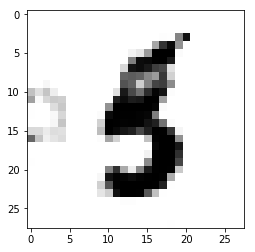

('Estimate:', array([[-7.91188526]], dtype=float32))
('Iteration:', 37600, 'at', datetime.datetime(2017, 10, 23, 2, 11, 29, 612372))


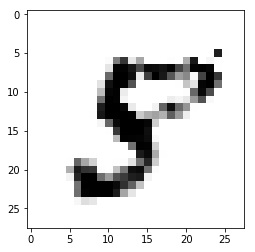

('Estimate:', array([[-2.60737467]], dtype=float32))
('Iteration:', 37700, 'at', datetime.datetime(2017, 10, 23, 2, 12, 36, 130478))


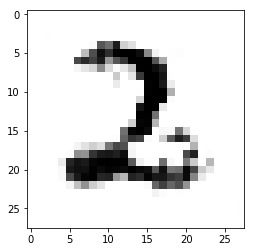

('Estimate:', array([[-1.55516016]], dtype=float32))
('Iteration:', 37800, 'at', datetime.datetime(2017, 10, 23, 2, 13, 42, 646177))


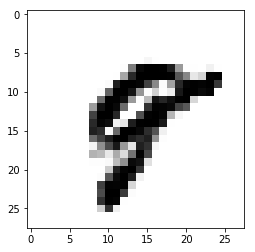

('Estimate:', array([[-3.72694373]], dtype=float32))
('Iteration:', 37900, 'at', datetime.datetime(2017, 10, 23, 2, 14, 48, 289372))


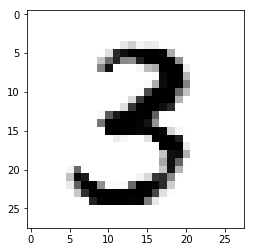

('Estimate:', array([[-3.98861217]], dtype=float32))
('Iteration:', 38000, 'at', datetime.datetime(2017, 10, 23, 2, 15, 54, 111514))


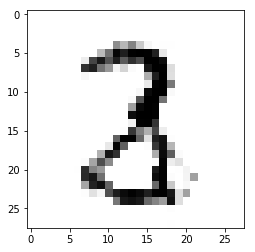

('Estimate:', array([[-4.73779678]], dtype=float32))
('Iteration:', 38100, 'at', datetime.datetime(2017, 10, 23, 2, 16, 59, 779652))


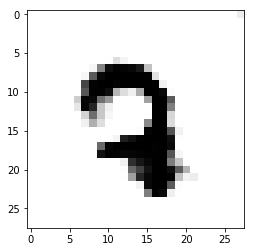

('Estimate:', array([[-5.2589426]], dtype=float32))
('Iteration:', 38200, 'at', datetime.datetime(2017, 10, 23, 2, 18, 5, 478861))


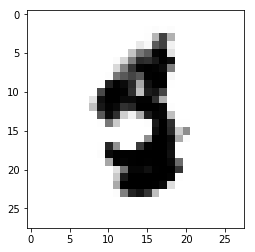

('Estimate:', array([[-6.83798933]], dtype=float32))
('Iteration:', 38300, 'at', datetime.datetime(2017, 10, 23, 2, 19, 10, 926773))


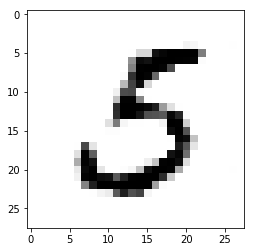

('Estimate:', array([[-4.4800415]], dtype=float32))
('Iteration:', 38400, 'at', datetime.datetime(2017, 10, 23, 2, 20, 16, 651525))


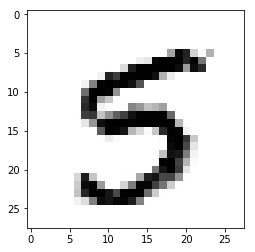

('Estimate:', array([[-0.33939826]], dtype=float32))
('Iteration:', 38500, 'at', datetime.datetime(2017, 10, 23, 2, 21, 22, 497069))


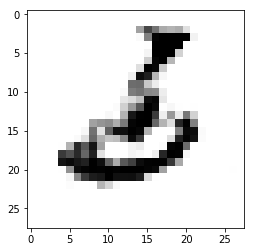

('Estimate:', array([[-6.17089891]], dtype=float32))
('Iteration:', 38600, 'at', datetime.datetime(2017, 10, 23, 2, 22, 28, 120395))


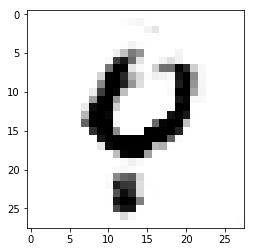

('Estimate:', array([[-5.00000858]], dtype=float32))
('Iteration:', 38700, 'at', datetime.datetime(2017, 10, 23, 2, 23, 34, 431591))


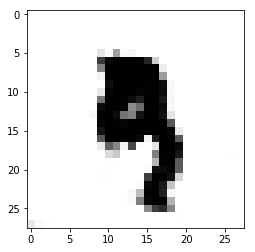

('Estimate:', array([[-3.83866453]], dtype=float32))
('Iteration:', 38800, 'at', datetime.datetime(2017, 10, 23, 2, 24, 40, 783448))


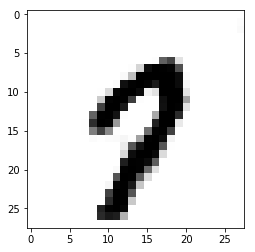

('Estimate:', array([[-0.79675019]], dtype=float32))
('Iteration:', 38900, 'at', datetime.datetime(2017, 10, 23, 2, 25, 46, 533711))


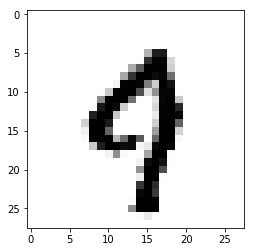

('Estimate:', array([[-3.96431971]], dtype=float32))
('Iteration:', 39000, 'at', datetime.datetime(2017, 10, 23, 2, 26, 52, 194975))


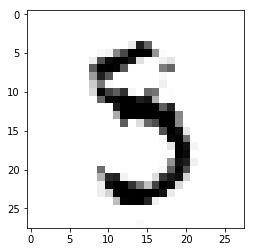

('Estimate:', array([[-4.88477755]], dtype=float32))
('Iteration:', 39100, 'at', datetime.datetime(2017, 10, 23, 2, 27, 58, 41278))


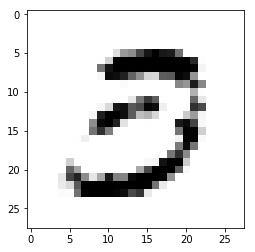

('Estimate:', array([[-3.00426698]], dtype=float32))
('Iteration:', 39200, 'at', datetime.datetime(2017, 10, 23, 2, 29, 4, 66181))


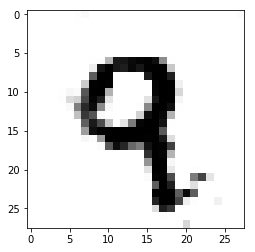

('Estimate:', array([[-2.58669257]], dtype=float32))
('Iteration:', 39300, 'at', datetime.datetime(2017, 10, 23, 2, 30, 9, 697625))


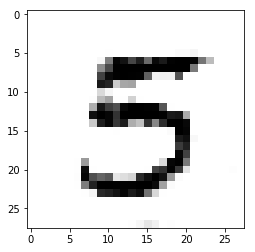

('Estimate:', array([[-5.5127368]], dtype=float32))
('Iteration:', 39400, 'at', datetime.datetime(2017, 10, 23, 2, 31, 15, 587664))


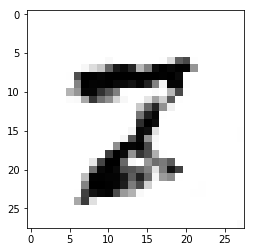

('Estimate:', array([[-5.6651721]], dtype=float32))
('Iteration:', 39500, 'at', datetime.datetime(2017, 10, 23, 2, 32, 21, 613609))


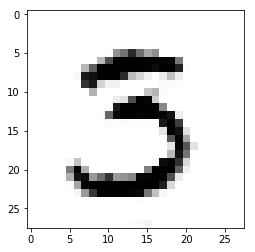

('Estimate:', array([[-2.81231165]], dtype=float32))
('Iteration:', 39600, 'at', datetime.datetime(2017, 10, 23, 2, 33, 27, 416866))


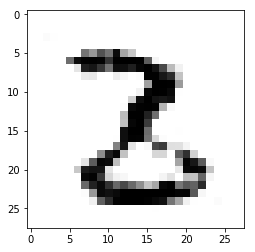

('Estimate:', array([[-6.12542009]], dtype=float32))
('Iteration:', 39700, 'at', datetime.datetime(2017, 10, 23, 2, 34, 33, 175911))


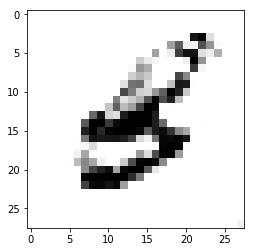

('Estimate:', array([[ 1.90237164]], dtype=float32))
('Iteration:', 39800, 'at', datetime.datetime(2017, 10, 23, 2, 35, 39, 441429))


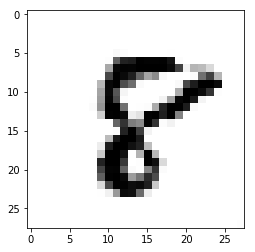

('Estimate:', array([[ 0.32504463]], dtype=float32))
('Iteration:', 39900, 'at', datetime.datetime(2017, 10, 23, 2, 36, 45, 155521))


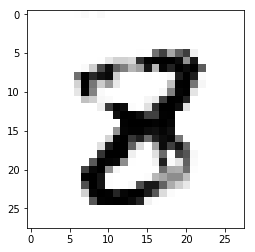

('Estimate:', array([[-7.02909279]], dtype=float32))
('Iteration:', 40000, 'at', datetime.datetime(2017, 10, 23, 2, 37, 50, 662667))


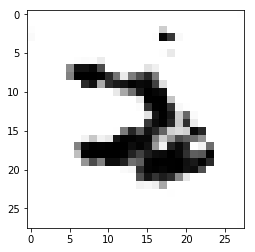

('Estimate:', array([[-6.02011013]], dtype=float32))
('Iteration:', 40100, 'at', datetime.datetime(2017, 10, 23, 2, 38, 56, 311705))


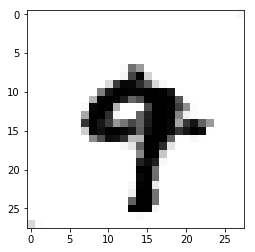

('Estimate:', array([[-4.1653533]], dtype=float32))
('Iteration:', 40200, 'at', datetime.datetime(2017, 10, 23, 2, 40, 2, 141784))


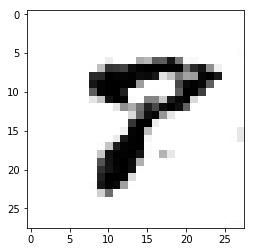

('Estimate:', array([[-4.0456953]], dtype=float32))
('Iteration:', 40300, 'at', datetime.datetime(2017, 10, 23, 2, 41, 8, 296383))


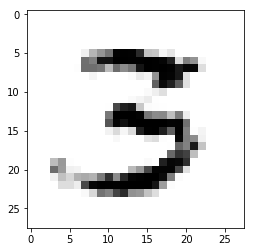

('Estimate:', array([[-6.16749668]], dtype=float32))
('Iteration:', 40400, 'at', datetime.datetime(2017, 10, 23, 2, 42, 14, 247602))


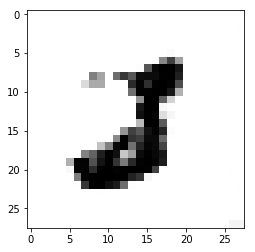

('Estimate:', array([[-7.93587971]], dtype=float32))
('Iteration:', 40500, 'at', datetime.datetime(2017, 10, 23, 2, 43, 21, 41323))


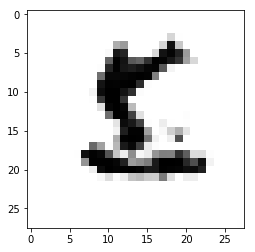

('Estimate:', array([[-5.85537577]], dtype=float32))
('Iteration:', 40600, 'at', datetime.datetime(2017, 10, 23, 2, 44, 27, 205501))


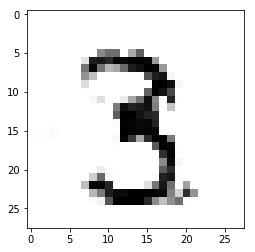

('Estimate:', array([[-7.40294266]], dtype=float32))
('Iteration:', 40700, 'at', datetime.datetime(2017, 10, 23, 2, 45, 33, 466931))


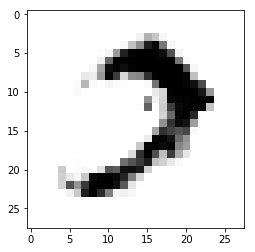

('Estimate:', array([[-7.93527126]], dtype=float32))
('Iteration:', 40800, 'at', datetime.datetime(2017, 10, 23, 2, 46, 39, 169294))


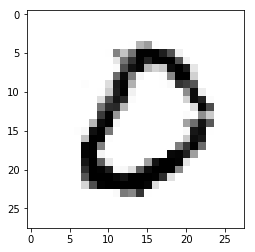

('Estimate:', array([[ 1.94451857]], dtype=float32))
('Iteration:', 40900, 'at', datetime.datetime(2017, 10, 23, 2, 47, 45, 325807))


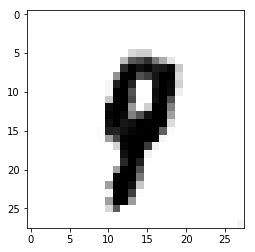

('Estimate:', array([[-6.65774965]], dtype=float32))
('Iteration:', 41000, 'at', datetime.datetime(2017, 10, 23, 2, 48, 51, 165696))


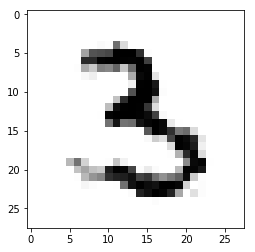

('Estimate:', array([[-5.57268]], dtype=float32))
('Iteration:', 41100, 'at', datetime.datetime(2017, 10, 23, 2, 49, 57, 529881))


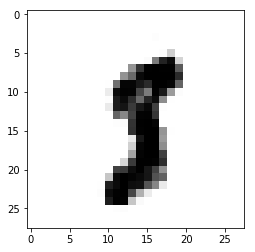

('Estimate:', array([[-6.94531488]], dtype=float32))
('Iteration:', 41200, 'at', datetime.datetime(2017, 10, 23, 2, 51, 3, 784904))


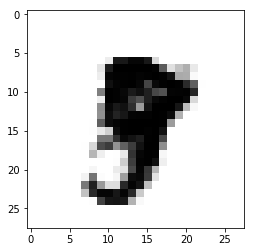

('Estimate:', array([[-6.82240343]], dtype=float32))
('Iteration:', 41300, 'at', datetime.datetime(2017, 10, 23, 2, 52, 9, 652266))


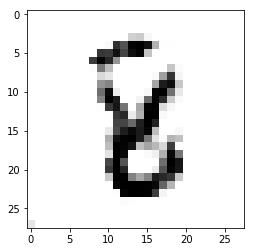

('Estimate:', array([[-5.97426081]], dtype=float32))
('Iteration:', 41400, 'at', datetime.datetime(2017, 10, 23, 2, 53, 15, 739698))


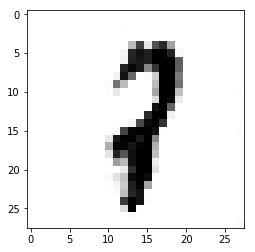

('Estimate:', array([[-10.48484135]], dtype=float32))
('Iteration:', 41500, 'at', datetime.datetime(2017, 10, 23, 2, 54, 21, 830412))


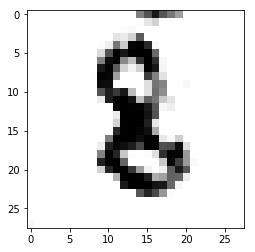

('Estimate:', array([[-4.1117363]], dtype=float32))
('Iteration:', 41600, 'at', datetime.datetime(2017, 10, 23, 2, 55, 28, 132827))


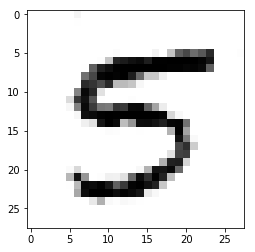

('Estimate:', array([[-2.82204294]], dtype=float32))
('Iteration:', 41700, 'at', datetime.datetime(2017, 10, 23, 2, 56, 33, 942751))


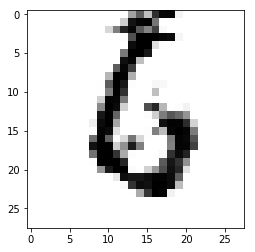

('Estimate:', array([[-1.43026733]], dtype=float32))
('Iteration:', 41800, 'at', datetime.datetime(2017, 10, 23, 2, 57, 40, 157973))


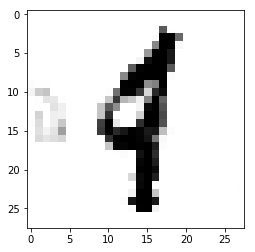

('Estimate:', array([[-5.01350021]], dtype=float32))
('Iteration:', 41900, 'at', datetime.datetime(2017, 10, 23, 2, 58, 46, 936459))


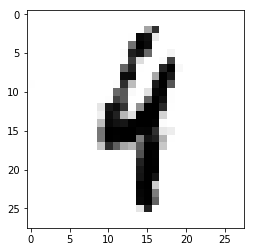

('Estimate:', array([[-6.5275445]], dtype=float32))
('Iteration:', 42000, 'at', datetime.datetime(2017, 10, 23, 2, 59, 53, 850855))


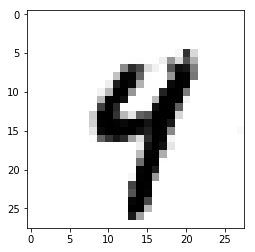

('Estimate:', array([[-7.48039818]], dtype=float32))
('Iteration:', 42100, 'at', datetime.datetime(2017, 10, 23, 3, 1, 2, 288889))


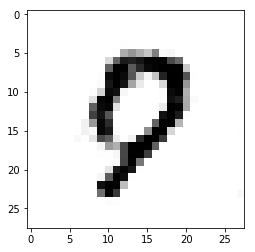

('Estimate:', array([[-8.06604767]], dtype=float32))
('Iteration:', 42200, 'at', datetime.datetime(2017, 10, 23, 3, 2, 12, 793649))


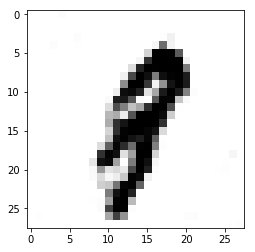

('Estimate:', array([[-8.62040043]], dtype=float32))
('Iteration:', 42300, 'at', datetime.datetime(2017, 10, 23, 3, 3, 23, 386261))


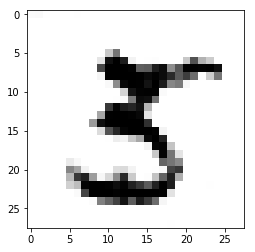

('Estimate:', array([[-4.00716734]], dtype=float32))
('Iteration:', 42400, 'at', datetime.datetime(2017, 10, 23, 3, 4, 34, 110423))


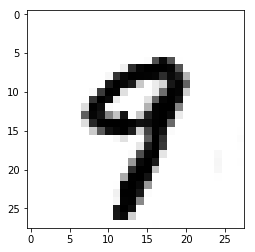

('Estimate:', array([[-3.91106844]], dtype=float32))
('Iteration:', 42500, 'at', datetime.datetime(2017, 10, 23, 3, 5, 44, 254457))


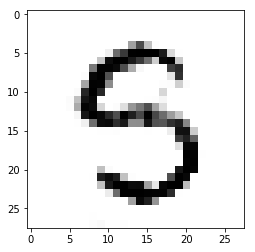

('Estimate:', array([[-7.858706]], dtype=float32))
('Iteration:', 42600, 'at', datetime.datetime(2017, 10, 23, 3, 6, 54, 592765))


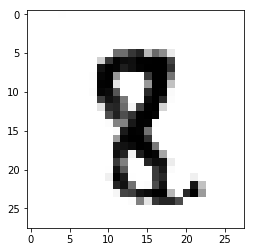

('Estimate:', array([[-4.37745714]], dtype=float32))
('Iteration:', 42700, 'at', datetime.datetime(2017, 10, 23, 3, 8, 4, 554115))


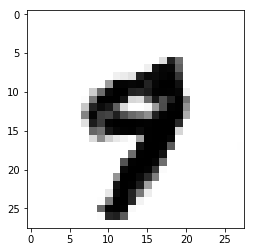

('Estimate:', array([[-5.13009357]], dtype=float32))
('Iteration:', 42800, 'at', datetime.datetime(2017, 10, 23, 3, 9, 14, 575930))


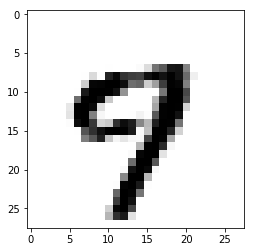

('Estimate:', array([[-6.73700714]], dtype=float32))
('Iteration:', 42900, 'at', datetime.datetime(2017, 10, 23, 3, 10, 25, 878479))


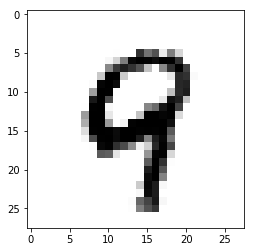

('Estimate:', array([[-7.35331631]], dtype=float32))
('Iteration:', 43000, 'at', datetime.datetime(2017, 10, 23, 3, 11, 36, 875396))


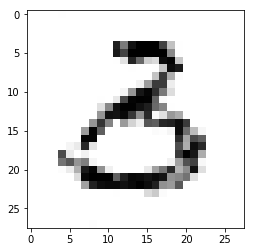

('Estimate:', array([[-10.83267403]], dtype=float32))
('Iteration:', 43100, 'at', datetime.datetime(2017, 10, 23, 3, 12, 47, 680760))


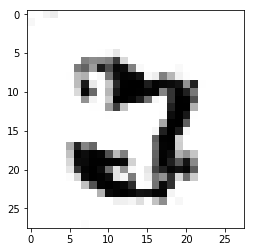

('Estimate:', array([[-12.63054848]], dtype=float32))
('Iteration:', 43200, 'at', datetime.datetime(2017, 10, 23, 3, 13, 59, 468200))


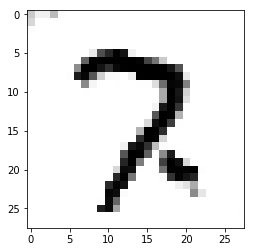

('Estimate:', array([[-7.645895]], dtype=float32))
('Iteration:', 43300, 'at', datetime.datetime(2017, 10, 23, 3, 15, 10, 594902))


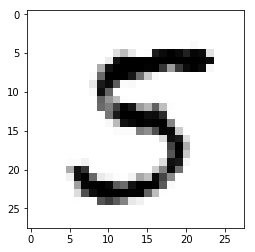

('Estimate:', array([[-9.35678864]], dtype=float32))
('Iteration:', 43400, 'at', datetime.datetime(2017, 10, 23, 3, 16, 20, 907797))


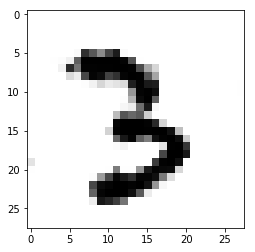

('Estimate:', array([[-7.24023438]], dtype=float32))
('Iteration:', 43500, 'at', datetime.datetime(2017, 10, 23, 3, 17, 31, 870335))


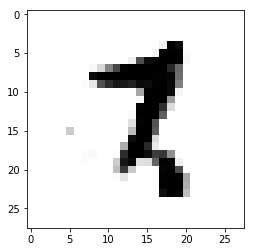

('Estimate:', array([[-10.95945358]], dtype=float32))
('Iteration:', 43600, 'at', datetime.datetime(2017, 10, 23, 3, 18, 42, 630141))


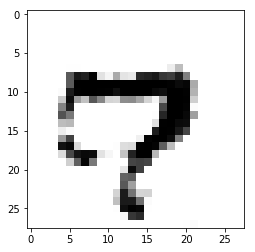

('Estimate:', array([[-15.70753384]], dtype=float32))
('Iteration:', 43700, 'at', datetime.datetime(2017, 10, 23, 3, 19, 53, 993799))


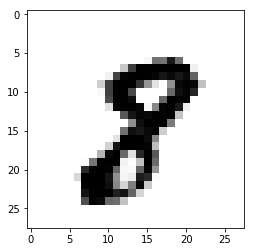

('Estimate:', array([[-5.39249468]], dtype=float32))
('Iteration:', 43800, 'at', datetime.datetime(2017, 10, 23, 3, 21, 5, 197748))


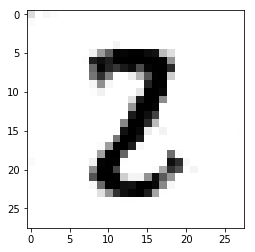

('Estimate:', array([[-5.53254986]], dtype=float32))
('Iteration:', 43900, 'at', datetime.datetime(2017, 10, 23, 3, 22, 15, 487122))


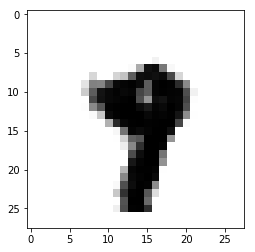

('Estimate:', array([[-10.30274773]], dtype=float32))
('Iteration:', 44000, 'at', datetime.datetime(2017, 10, 23, 3, 23, 26, 558170))


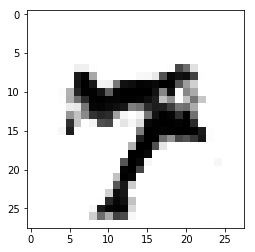

('Estimate:', array([[-8.17851257]], dtype=float32))
('Iteration:', 44100, 'at', datetime.datetime(2017, 10, 23, 3, 24, 39, 481792))


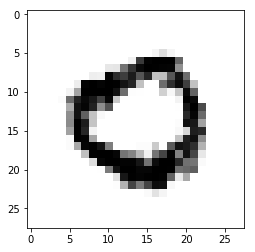

('Estimate:', array([[-10.13520527]], dtype=float32))
('Iteration:', 44200, 'at', datetime.datetime(2017, 10, 23, 3, 25, 50, 929508))


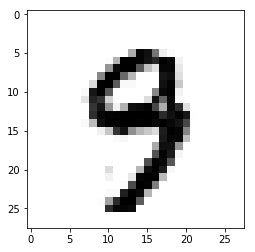

('Estimate:', array([[-7.42163134]], dtype=float32))
('Iteration:', 44300, 'at', datetime.datetime(2017, 10, 23, 3, 27, 2, 465383))


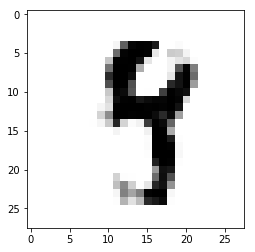

('Estimate:', array([[-9.23208046]], dtype=float32))
('Iteration:', 44400, 'at', datetime.datetime(2017, 10, 23, 3, 28, 13, 475037))


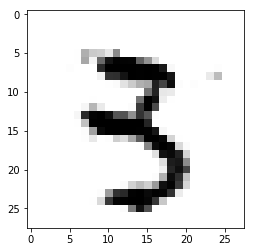

('Estimate:', array([[-6.15638971]], dtype=float32))
('Iteration:', 44500, 'at', datetime.datetime(2017, 10, 23, 3, 29, 25, 124345))


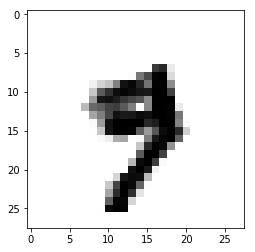

('Estimate:', array([[-4.4279418]], dtype=float32))
('Iteration:', 44600, 'at', datetime.datetime(2017, 10, 23, 3, 30, 36, 601194))


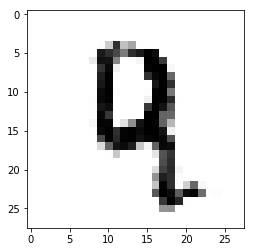

('Estimate:', array([[ 1.41080213]], dtype=float32))
('Iteration:', 44700, 'at', datetime.datetime(2017, 10, 23, 3, 31, 48, 24935))


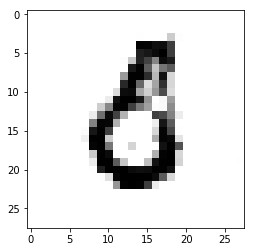

('Estimate:', array([[-9.3491888]], dtype=float32))
('Iteration:', 44800, 'at', datetime.datetime(2017, 10, 23, 3, 32, 58, 908171))


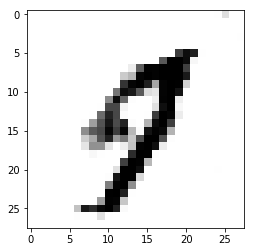

('Estimate:', array([[-10.86697865]], dtype=float32))
('Iteration:', 44900, 'at', datetime.datetime(2017, 10, 23, 3, 34, 9, 505553))


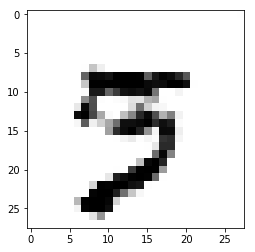

('Estimate:', array([[-10.40415001]], dtype=float32))
('Iteration:', 45000, 'at', datetime.datetime(2017, 10, 23, 3, 35, 20, 750157))


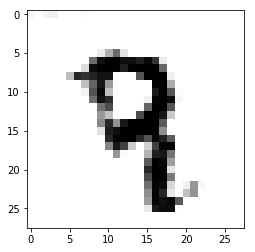

('Estimate:', array([[-9.73978996]], dtype=float32))
('Iteration:', 45100, 'at', datetime.datetime(2017, 10, 23, 3, 36, 31, 613102))


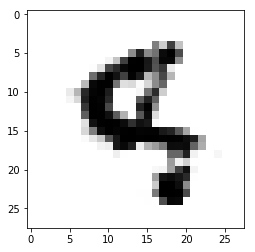

('Estimate:', array([[-11.05293083]], dtype=float32))
('Iteration:', 45200, 'at', datetime.datetime(2017, 10, 23, 3, 37, 42, 772186))


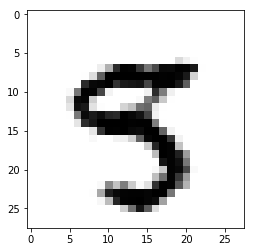

('Estimate:', array([[-2.58764291]], dtype=float32))
('Iteration:', 45300, 'at', datetime.datetime(2017, 10, 23, 3, 38, 53, 600927))


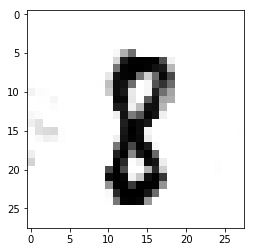

('Estimate:', array([[-2.16357851]], dtype=float32))
('Iteration:', 45400, 'at', datetime.datetime(2017, 10, 23, 3, 40, 4, 779455))


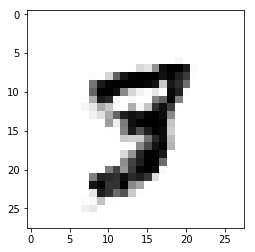

('Estimate:', array([[-12.29994297]], dtype=float32))
('Iteration:', 45500, 'at', datetime.datetime(2017, 10, 23, 3, 41, 16, 212454))


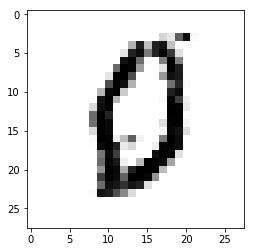

('Estimate:', array([[-7.59669495]], dtype=float32))
('Iteration:', 45600, 'at', datetime.datetime(2017, 10, 23, 3, 42, 27, 334122))


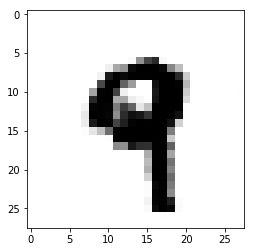

('Estimate:', array([[-8.09988213]], dtype=float32))
('Iteration:', 45700, 'at', datetime.datetime(2017, 10, 23, 3, 43, 38, 63719))


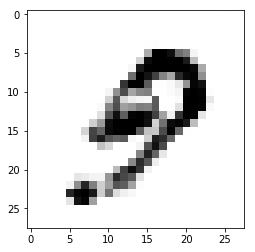

('Estimate:', array([[-7.55344296]], dtype=float32))
('Iteration:', 45800, 'at', datetime.datetime(2017, 10, 23, 3, 44, 49, 283220))


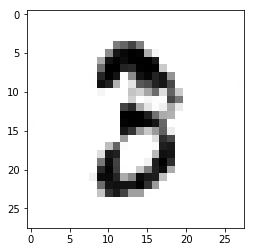

('Estimate:', array([[-9.25109768]], dtype=float32))
('Iteration:', 45900, 'at', datetime.datetime(2017, 10, 23, 3, 46, 0, 595913))


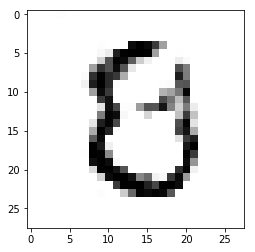

('Estimate:', array([[-6.26699352]], dtype=float32))
('Iteration:', 46000, 'at', datetime.datetime(2017, 10, 23, 3, 47, 11, 615435))


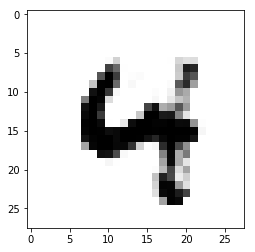

('Estimate:', array([[ 0.65671808]], dtype=float32))
('Iteration:', 46100, 'at', datetime.datetime(2017, 10, 23, 3, 48, 21, 985920))


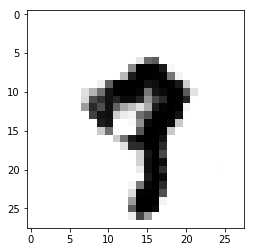

('Estimate:', array([[-8.3618288]], dtype=float32))
('Iteration:', 46200, 'at', datetime.datetime(2017, 10, 23, 3, 49, 34, 39677))


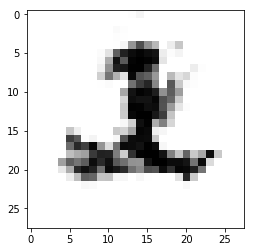

('Estimate:', array([[-7.44627237]], dtype=float32))
('Iteration:', 46300, 'at', datetime.datetime(2017, 10, 23, 3, 50, 45, 354933))


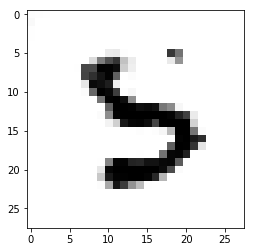

('Estimate:', array([[-10.18720722]], dtype=float32))
('Iteration:', 46400, 'at', datetime.datetime(2017, 10, 23, 3, 51, 56, 634577))


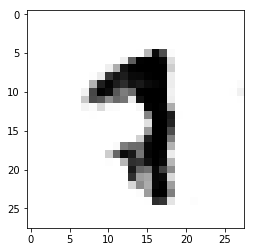

('Estimate:', array([[-12.3658762]], dtype=float32))
('Iteration:', 46500, 'at', datetime.datetime(2017, 10, 23, 3, 53, 7, 606597))


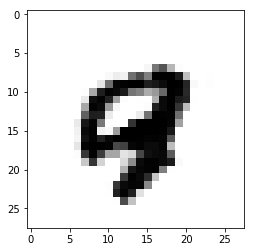

('Estimate:', array([[-11.12563229]], dtype=float32))
('Iteration:', 46600, 'at', datetime.datetime(2017, 10, 23, 3, 54, 18, 581775))


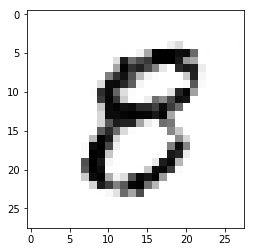

('Estimate:', array([[-12.12673569]], dtype=float32))
('Iteration:', 46700, 'at', datetime.datetime(2017, 10, 23, 3, 55, 30, 179492))


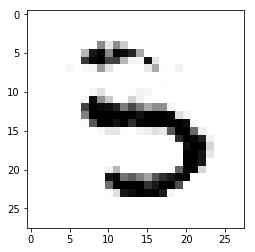

('Estimate:', array([[-12.64319134]], dtype=float32))
('Iteration:', 46800, 'at', datetime.datetime(2017, 10, 23, 3, 56, 41, 552843))


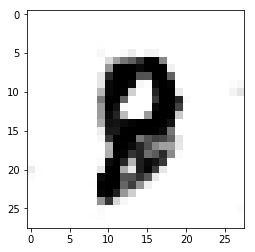

('Estimate:', array([[-16.2095623]], dtype=float32))
('Iteration:', 46900, 'at', datetime.datetime(2017, 10, 23, 3, 57, 52, 890511))


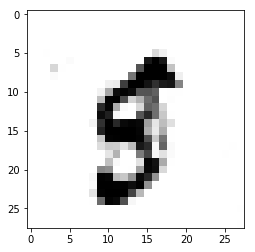

('Estimate:', array([[-13.1388588]], dtype=float32))
('Iteration:', 47000, 'at', datetime.datetime(2017, 10, 23, 3, 59, 4, 449742))


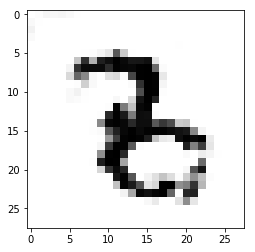

('Estimate:', array([[-8.21843147]], dtype=float32))
('Iteration:', 47100, 'at', datetime.datetime(2017, 10, 23, 4, 0, 15, 360376))


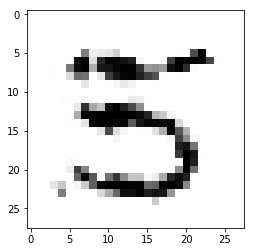

('Estimate:', array([[-7.11730433]], dtype=float32))
('Iteration:', 47200, 'at', datetime.datetime(2017, 10, 23, 4, 1, 26, 771760))


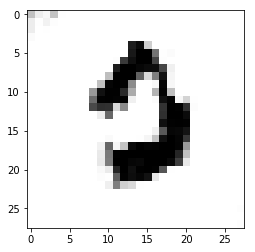

('Estimate:', array([[-14.82781219]], dtype=float32))
('Iteration:', 47300, 'at', datetime.datetime(2017, 10, 23, 4, 2, 37, 765520))


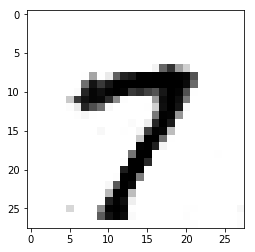

('Estimate:', array([[-0.74599177]], dtype=float32))
('Iteration:', 47400, 'at', datetime.datetime(2017, 10, 23, 4, 3, 49, 190616))


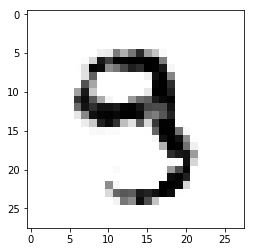

('Estimate:', array([[-11.40641975]], dtype=float32))
('Iteration:', 47500, 'at', datetime.datetime(2017, 10, 23, 4, 5, 0, 64066))


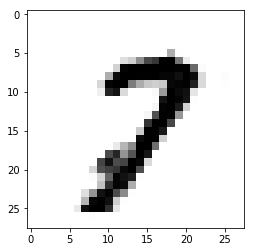

('Estimate:', array([[-14.21564102]], dtype=float32))
('Iteration:', 47600, 'at', datetime.datetime(2017, 10, 23, 4, 6, 10, 637323))


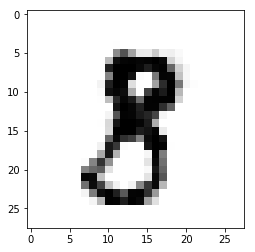

('Estimate:', array([[-7.18445969]], dtype=float32))
('Iteration:', 47700, 'at', datetime.datetime(2017, 10, 23, 4, 7, 22, 8323))


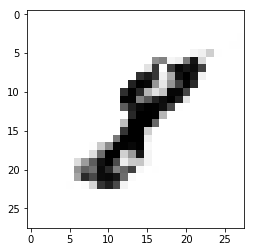

('Estimate:', array([[-12.95068169]], dtype=float32))
('Iteration:', 47800, 'at', datetime.datetime(2017, 10, 23, 4, 8, 32, 562392))


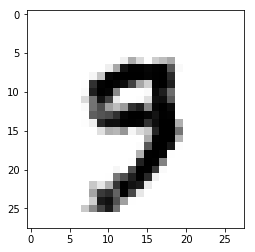

('Estimate:', array([[-13.17426682]], dtype=float32))
('Iteration:', 47900, 'at', datetime.datetime(2017, 10, 23, 4, 9, 42, 876422))


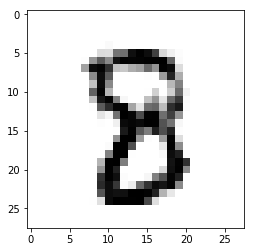

('Estimate:', array([[-4.8801465]], dtype=float32))
('Iteration:', 48000, 'at', datetime.datetime(2017, 10, 23, 4, 10, 51, 759588))


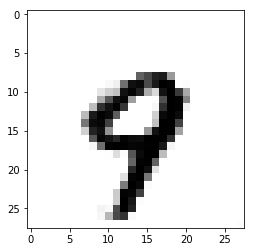

('Estimate:', array([[-9.38862419]], dtype=float32))
('Iteration:', 48100, 'at', datetime.datetime(2017, 10, 23, 4, 12, 3, 365151))


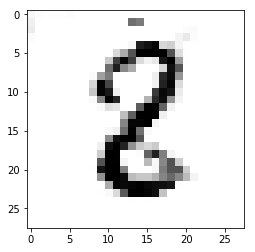

('Estimate:', array([[-9.64889622]], dtype=float32))
('Iteration:', 48200, 'at', datetime.datetime(2017, 10, 23, 4, 13, 14, 802941))


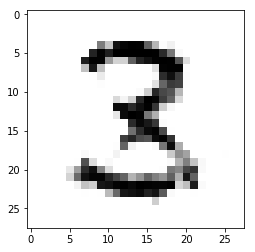

('Estimate:', array([[-9.86315632]], dtype=float32))
('Iteration:', 48300, 'at', datetime.datetime(2017, 10, 23, 4, 14, 26, 989324))


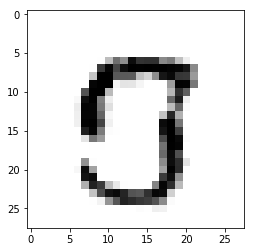

('Estimate:', array([[-11.38679409]], dtype=float32))
('Iteration:', 48400, 'at', datetime.datetime(2017, 10, 23, 4, 15, 38, 841455))


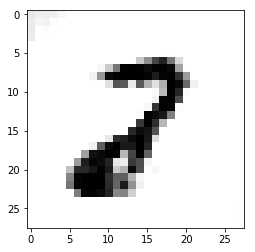

('Estimate:', array([[-8.66069603]], dtype=float32))
('Iteration:', 48500, 'at', datetime.datetime(2017, 10, 23, 4, 16, 50, 818489))


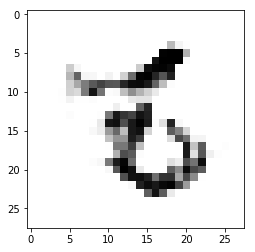

('Estimate:', array([[-10.96146393]], dtype=float32))
('Iteration:', 48600, 'at', datetime.datetime(2017, 10, 23, 4, 18, 1, 822766))


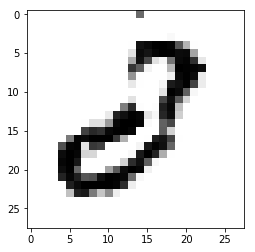

('Estimate:', array([[-11.04627991]], dtype=float32))
('Iteration:', 48700, 'at', datetime.datetime(2017, 10, 23, 4, 19, 12, 897035))


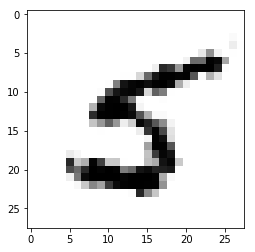

('Estimate:', array([[ 5.51896572]], dtype=float32))
('Iteration:', 48800, 'at', datetime.datetime(2017, 10, 23, 4, 20, 24, 188456))


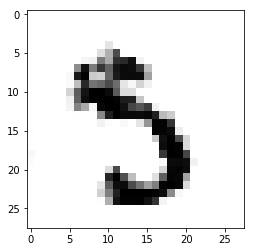

('Estimate:', array([[-13.53029442]], dtype=float32))
('Iteration:', 48900, 'at', datetime.datetime(2017, 10, 23, 4, 21, 35, 813029))


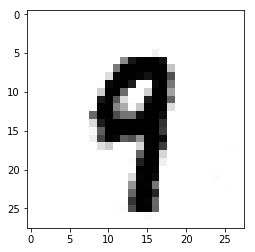

('Estimate:', array([[-11.69201851]], dtype=float32))
('Iteration:', 49000, 'at', datetime.datetime(2017, 10, 23, 4, 22, 47, 44557))


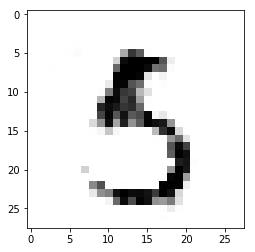

('Estimate:', array([[-16.54014778]], dtype=float32))
('Iteration:', 49100, 'at', datetime.datetime(2017, 10, 23, 4, 23, 58, 276209))


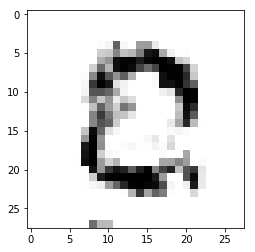

('Estimate:', array([[-28.03371239]], dtype=float32))
('Iteration:', 49200, 'at', datetime.datetime(2017, 10, 23, 4, 25, 9, 807766))


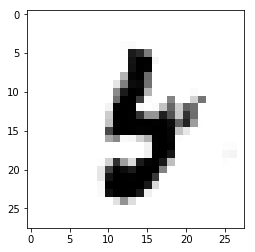

('Estimate:', array([[-12.93295288]], dtype=float32))
('Iteration:', 49300, 'at', datetime.datetime(2017, 10, 23, 4, 26, 21, 105703))


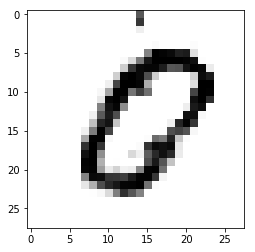

('Estimate:', array([[-11.00053883]], dtype=float32))
('Iteration:', 49400, 'at', datetime.datetime(2017, 10, 23, 4, 27, 32, 744551))


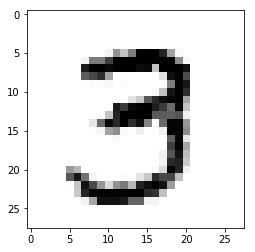

('Estimate:', array([[-7.85982418]], dtype=float32))
('Iteration:', 49500, 'at', datetime.datetime(2017, 10, 23, 4, 28, 43, 824553))


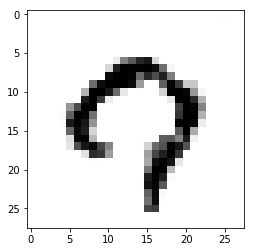

('Estimate:', array([[-10.92414856]], dtype=float32))
('Iteration:', 49600, 'at', datetime.datetime(2017, 10, 23, 4, 29, 54, 904813))


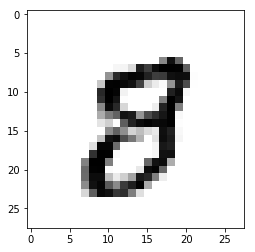

('Estimate:', array([[-11.02164364]], dtype=float32))
('Iteration:', 49700, 'at', datetime.datetime(2017, 10, 23, 4, 31, 6, 353317))


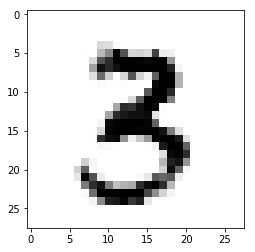

('Estimate:', array([[-11.3325243]], dtype=float32))
('Iteration:', 49800, 'at', datetime.datetime(2017, 10, 23, 4, 32, 17, 411724))


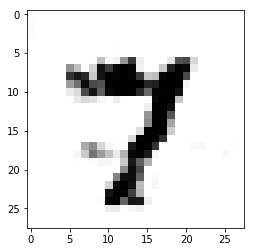

('Estimate:', array([[-14.61932659]], dtype=float32))
('Iteration:', 49900, 'at', datetime.datetime(2017, 10, 23, 4, 33, 28, 98435))


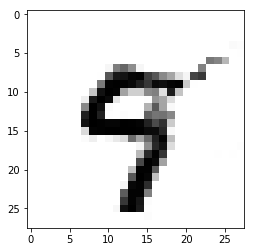

('Estimate:', array([[-12.3225317]], dtype=float32))
('Iteration:', 50000, 'at', datetime.datetime(2017, 10, 23, 4, 34, 39, 322168))


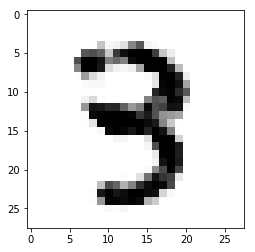

('Estimate:', array([[-14.63251877]], dtype=float32))
('Iteration:', 50100, 'at', datetime.datetime(2017, 10, 23, 4, 35, 50, 421034))


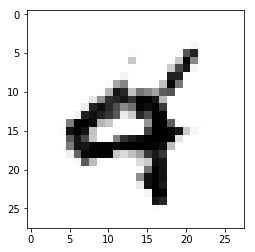

('Estimate:', array([[-2.18675065]], dtype=float32))
('Iteration:', 50200, 'at', datetime.datetime(2017, 10, 23, 4, 37, 1, 664057))


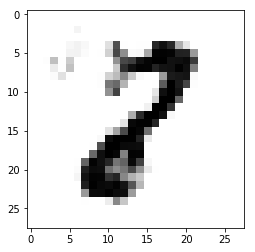

('Estimate:', array([[-12.42849636]], dtype=float32))
('Iteration:', 50300, 'at', datetime.datetime(2017, 10, 23, 4, 38, 12, 371856))


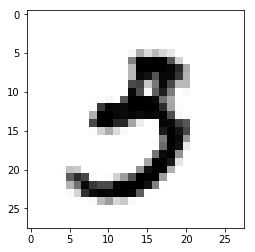

('Estimate:', array([[-12.22178364]], dtype=float32))
('Iteration:', 50400, 'at', datetime.datetime(2017, 10, 23, 4, 39, 23, 469122))


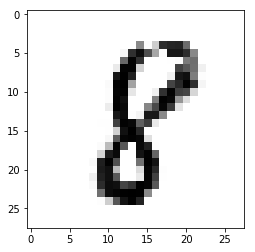

('Estimate:', array([[-8.56610012]], dtype=float32))
('Iteration:', 50500, 'at', datetime.datetime(2017, 10, 23, 4, 40, 33, 896479))


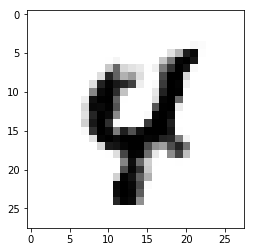

('Estimate:', array([[-5.00655603]], dtype=float32))
('Iteration:', 50600, 'at', datetime.datetime(2017, 10, 23, 4, 41, 44, 459114))


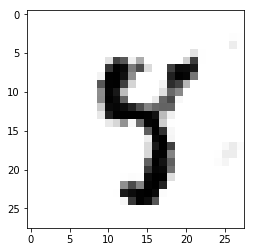

('Estimate:', array([[-6.55576658]], dtype=float32))
('Iteration:', 50700, 'at', datetime.datetime(2017, 10, 23, 4, 42, 55, 61046))


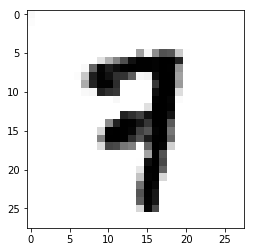

('Estimate:', array([[-13.45895481]], dtype=float32))
('Iteration:', 50800, 'at', datetime.datetime(2017, 10, 23, 4, 44, 5, 754445))


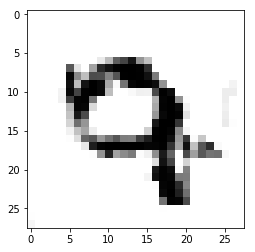

('Estimate:', array([[-4.53139734]], dtype=float32))
('Iteration:', 50900, 'at', datetime.datetime(2017, 10, 23, 4, 45, 16, 359818))


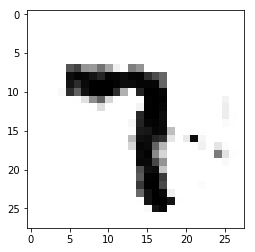

('Estimate:', array([[-13.58476448]], dtype=float32))
('Iteration:', 51000, 'at', datetime.datetime(2017, 10, 23, 4, 46, 26, 570163))


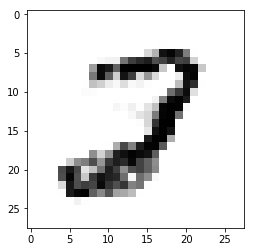

('Estimate:', array([[-7.61065388]], dtype=float32))
('Iteration:', 51100, 'at', datetime.datetime(2017, 10, 23, 4, 47, 37, 953864))


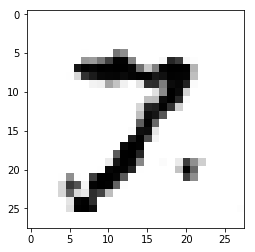

('Estimate:', array([[-15.52470398]], dtype=float32))
('Iteration:', 51200, 'at', datetime.datetime(2017, 10, 23, 4, 48, 48, 458465))


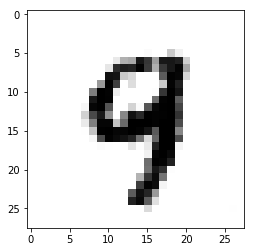

('Estimate:', array([[-9.81393528]], dtype=float32))
('Iteration:', 51300, 'at', datetime.datetime(2017, 10, 23, 4, 49, 59, 71304))


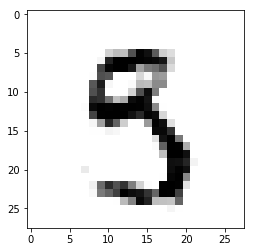

('Estimate:', array([[-9.48756981]], dtype=float32))
('Iteration:', 51400, 'at', datetime.datetime(2017, 10, 23, 4, 51, 11, 337278))


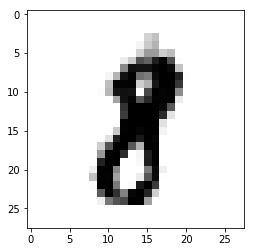

('Estimate:', array([[-5.78170443]], dtype=float32))
('Iteration:', 51500, 'at', datetime.datetime(2017, 10, 23, 4, 52, 22, 41085))


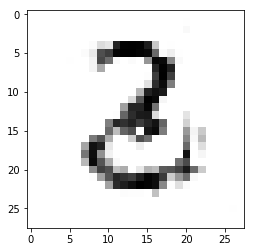

('Estimate:', array([[-15.92737961]], dtype=float32))
('Iteration:', 51600, 'at', datetime.datetime(2017, 10, 23, 4, 53, 32, 925892))


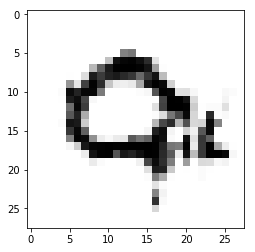

('Estimate:', array([[-6.16543722]], dtype=float32))
('Iteration:', 51700, 'at', datetime.datetime(2017, 10, 23, 4, 54, 43, 660063))


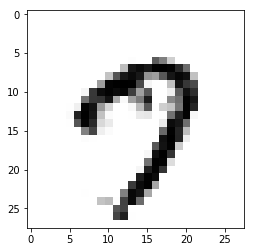

('Estimate:', array([[-7.84068394]], dtype=float32))
('Iteration:', 51800, 'at', datetime.datetime(2017, 10, 23, 4, 55, 54, 352965))


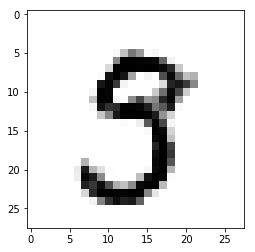

('Estimate:', array([[-13.33694172]], dtype=float32))
('Iteration:', 51900, 'at', datetime.datetime(2017, 10, 23, 4, 57, 5, 764025))


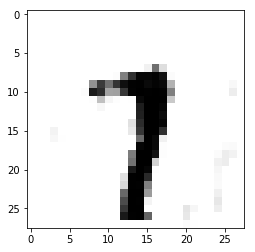

('Estimate:', array([[-16.16242027]], dtype=float32))
('Iteration:', 52000, 'at', datetime.datetime(2017, 10, 23, 4, 58, 16, 357082))


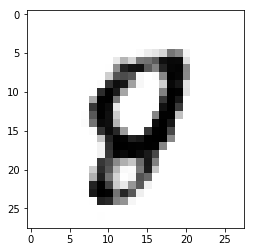

('Estimate:', array([[-12.10918236]], dtype=float32))
('Iteration:', 52100, 'at', datetime.datetime(2017, 10, 23, 4, 59, 27, 224190))


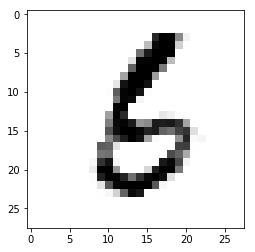

('Estimate:', array([[-9.55398464]], dtype=float32))
('Iteration:', 52200, 'at', datetime.datetime(2017, 10, 23, 5, 0, 37, 734113))


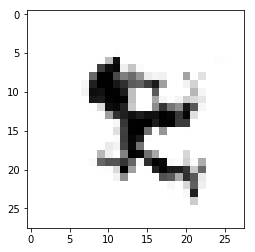

('Estimate:', array([[-13.88753605]], dtype=float32))
('Iteration:', 52300, 'at', datetime.datetime(2017, 10, 23, 5, 1, 49, 109531))


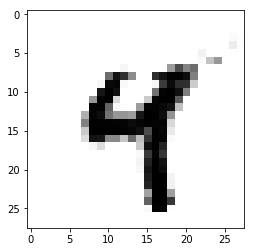

('Estimate:', array([[-16.18187904]], dtype=float32))
('Iteration:', 52400, 'at', datetime.datetime(2017, 10, 23, 5, 2, 59, 729041))


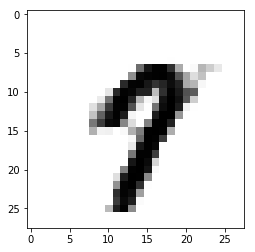

('Estimate:', array([[-12.22375774]], dtype=float32))
('Iteration:', 52500, 'at', datetime.datetime(2017, 10, 23, 5, 4, 13, 64600))


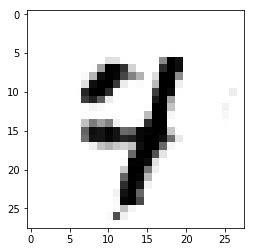

('Estimate:', array([[-11.01028919]], dtype=float32))
('Iteration:', 52600, 'at', datetime.datetime(2017, 10, 23, 5, 5, 26, 992600))


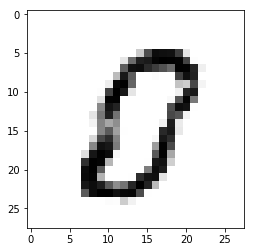

('Estimate:', array([[-16.66949272]], dtype=float32))
('Iteration:', 52700, 'at', datetime.datetime(2017, 10, 23, 5, 6, 34, 672433))


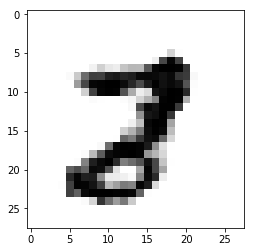

('Estimate:', array([[-14.89189625]], dtype=float32))
('Iteration:', 52800, 'at', datetime.datetime(2017, 10, 23, 5, 7, 41, 726205))


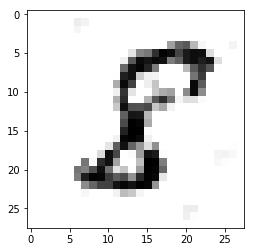

('Estimate:', array([[-16.3335762]], dtype=float32))
('Iteration:', 52900, 'at', datetime.datetime(2017, 10, 23, 5, 8, 48, 166427))


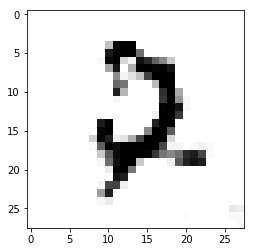

('Estimate:', array([[-8.42639828]], dtype=float32))
('Iteration:', 53000, 'at', datetime.datetime(2017, 10, 23, 5, 9, 54, 969876))


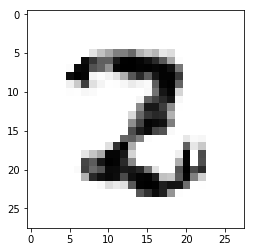

('Estimate:', array([[-11.7764225]], dtype=float32))
('Iteration:', 53100, 'at', datetime.datetime(2017, 10, 23, 5, 11, 2, 70309))


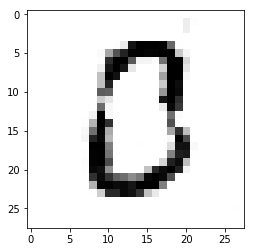

('Estimate:', array([[-16.67646027]], dtype=float32))
('Iteration:', 53200, 'at', datetime.datetime(2017, 10, 23, 5, 12, 9, 881418))


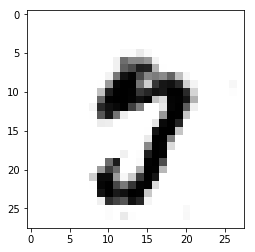

('Estimate:', array([[-15.38321209]], dtype=float32))
('Iteration:', 53300, 'at', datetime.datetime(2017, 10, 23, 5, 13, 16, 407454))


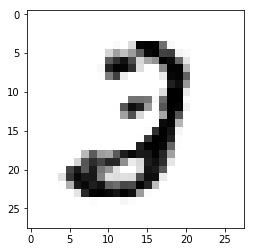

('Estimate:', array([[-6.94927073]], dtype=float32))
('Iteration:', 53400, 'at', datetime.datetime(2017, 10, 23, 5, 14, 23, 226596))


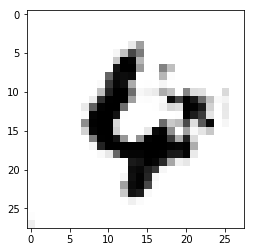

('Estimate:', array([[-14.82234573]], dtype=float32))
('Iteration:', 53500, 'at', datetime.datetime(2017, 10, 23, 5, 15, 30, 69814))


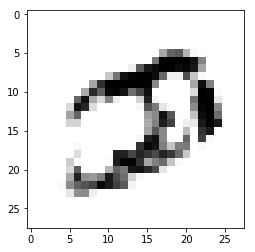

('Estimate:', array([[-11.99524021]], dtype=float32))
('Iteration:', 53600, 'at', datetime.datetime(2017, 10, 23, 5, 16, 36, 632162))


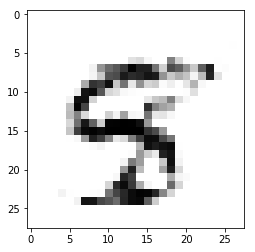

('Estimate:', array([[-16.25125313]], dtype=float32))
('Iteration:', 53700, 'at', datetime.datetime(2017, 10, 23, 5, 17, 43, 220810))


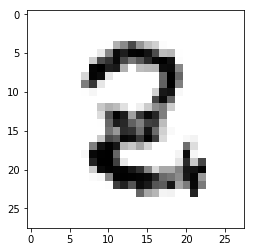

('Estimate:', array([[-11.50333214]], dtype=float32))
('Iteration:', 53800, 'at', datetime.datetime(2017, 10, 23, 5, 18, 49, 505001))


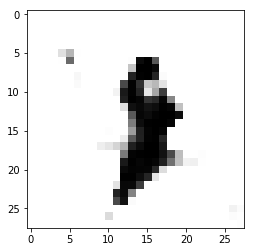

('Estimate:', array([[-15.41846561]], dtype=float32))
('Iteration:', 53900, 'at', datetime.datetime(2017, 10, 23, 5, 19, 56, 187356))


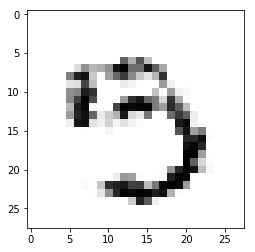

('Estimate:', array([[-10.56742764]], dtype=float32))
('Iteration:', 54000, 'at', datetime.datetime(2017, 10, 23, 5, 21, 3, 751929))


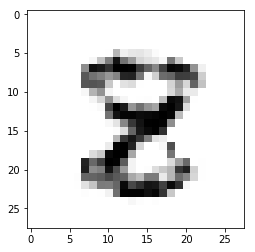

('Estimate:', array([[-16.25229073]], dtype=float32))
('Iteration:', 54100, 'at', datetime.datetime(2017, 10, 23, 5, 22, 10, 22910))


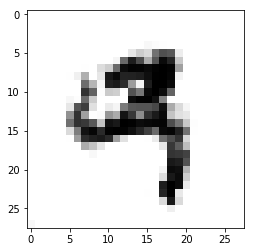

('Estimate:', array([[-3.22419119]], dtype=float32))
('Iteration:', 54200, 'at', datetime.datetime(2017, 10, 23, 5, 23, 16, 564250))


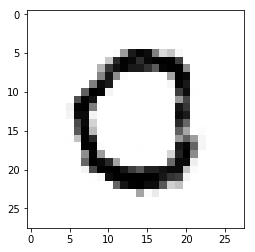

('Estimate:', array([[ 11.87502956]], dtype=float32))
('Iteration:', 54300, 'at', datetime.datetime(2017, 10, 23, 5, 24, 24, 788883))


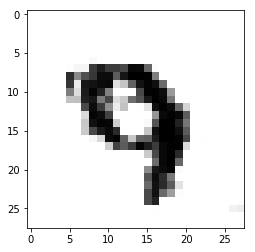

('Estimate:', array([[-10.0193119]], dtype=float32))
('Iteration:', 54400, 'at', datetime.datetime(2017, 10, 23, 5, 25, 31, 545527))


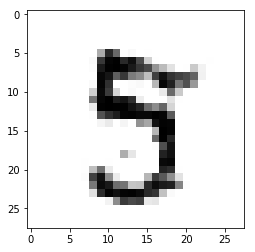

('Estimate:', array([[-17.39440536]], dtype=float32))
('Iteration:', 54500, 'at', datetime.datetime(2017, 10, 23, 5, 26, 38, 757622))


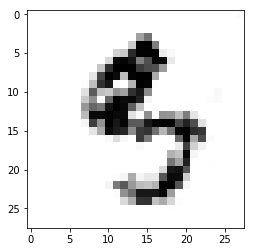

('Estimate:', array([[-16.26002121]], dtype=float32))
('Iteration:', 54600, 'at', datetime.datetime(2017, 10, 23, 5, 27, 45, 272574))


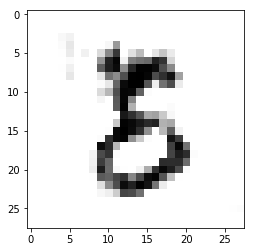

('Estimate:', array([[-13.78217316]], dtype=float32))
('Iteration:', 54700, 'at', datetime.datetime(2017, 10, 23, 5, 28, 51, 680427))


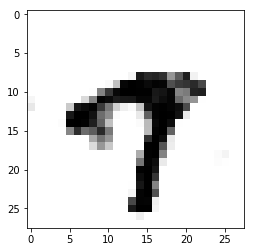

('Estimate:', array([[-17.05875969]], dtype=float32))
('Iteration:', 54800, 'at', datetime.datetime(2017, 10, 23, 5, 29, 58, 251555))


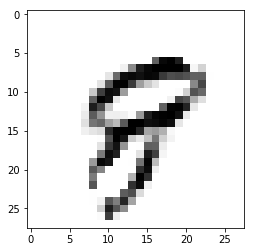

('Estimate:', array([[-0.85148436]], dtype=float32))
('Iteration:', 54900, 'at', datetime.datetime(2017, 10, 23, 5, 31, 5, 264437))


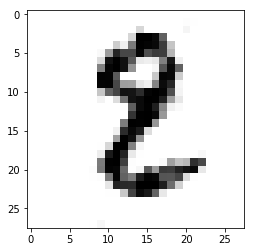

('Estimate:', array([[-4.21936035]], dtype=float32))
('Iteration:', 55000, 'at', datetime.datetime(2017, 10, 23, 5, 32, 12, 481110))


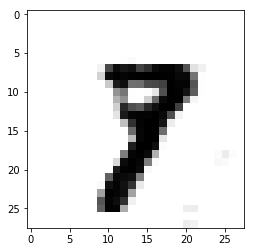

('Estimate:', array([[-11.28674412]], dtype=float32))
('Iteration:', 55100, 'at', datetime.datetime(2017, 10, 23, 5, 33, 19, 176665))


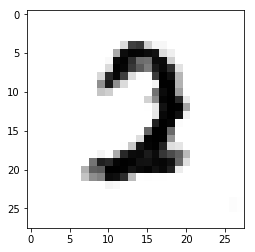

('Estimate:', array([[-4.9010005]], dtype=float32))
('Iteration:', 55200, 'at', datetime.datetime(2017, 10, 23, 5, 34, 25, 598121))


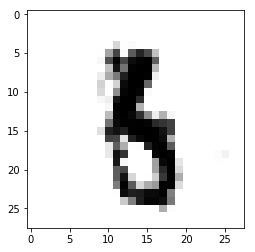

('Estimate:', array([[-11.33151913]], dtype=float32))
('Iteration:', 55300, 'at', datetime.datetime(2017, 10, 23, 5, 35, 32, 536472))


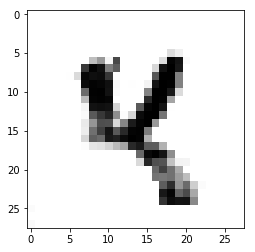

('Estimate:', array([[-2.61138439]], dtype=float32))
('Iteration:', 55400, 'at', datetime.datetime(2017, 10, 23, 5, 36, 40, 57556))


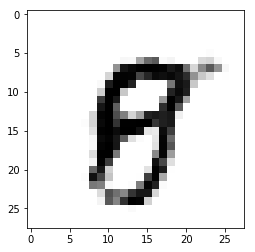

('Estimate:', array([[-13.74659061]], dtype=float32))
('Iteration:', 55500, 'at', datetime.datetime(2017, 10, 23, 5, 37, 46, 605964))


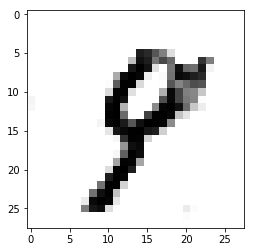

('Estimate:', array([[-8.86413193]], dtype=float32))
('Iteration:', 55600, 'at', datetime.datetime(2017, 10, 23, 5, 38, 52, 908954))


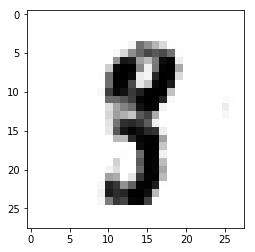

('Estimate:', array([[-7.20574474]], dtype=float32))
('Iteration:', 55700, 'at', datetime.datetime(2017, 10, 23, 5, 39, 59, 619065))


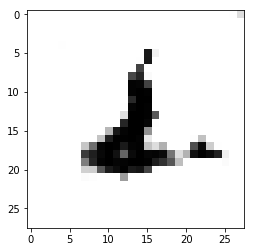

('Estimate:', array([[-0.28718498]], dtype=float32))
('Iteration:', 55800, 'at', datetime.datetime(2017, 10, 23, 5, 41, 6, 395705))


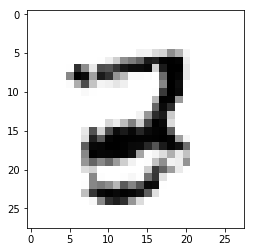

('Estimate:', array([[-9.07927895]], dtype=float32))
('Iteration:', 55900, 'at', datetime.datetime(2017, 10, 23, 5, 42, 13, 26599))


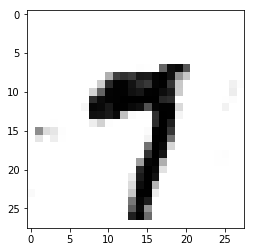

('Estimate:', array([[-12.89266586]], dtype=float32))
('Iteration:', 56000, 'at', datetime.datetime(2017, 10, 23, 5, 43, 20, 717631))


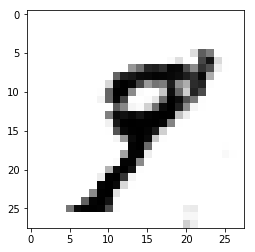

('Estimate:', array([[-12.17673302]], dtype=float32))
('Iteration:', 56100, 'at', datetime.datetime(2017, 10, 23, 5, 44, 28, 113693))


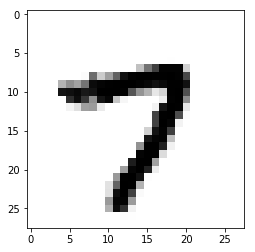

('Estimate:', array([[-6.54355526]], dtype=float32))
('Iteration:', 56200, 'at', datetime.datetime(2017, 10, 23, 5, 45, 34, 901636))


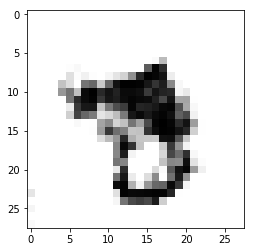

('Estimate:', array([[-13.54804897]], dtype=float32))
('Iteration:', 56300, 'at', datetime.datetime(2017, 10, 23, 5, 46, 41, 447147))


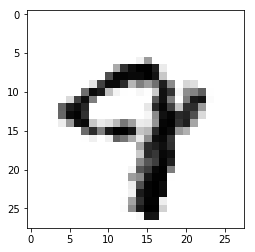

('Estimate:', array([[-5.95146084]], dtype=float32))
('Iteration:', 56400, 'at', datetime.datetime(2017, 10, 23, 5, 47, 48, 29022))


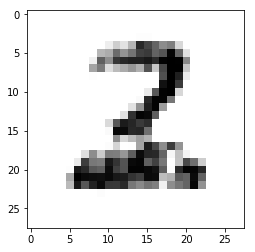

('Estimate:', array([[-3.17169809]], dtype=float32))
('Iteration:', 56500, 'at', datetime.datetime(2017, 10, 23, 5, 48, 54, 247291))


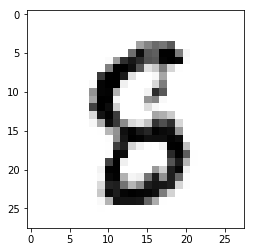

('Estimate:', array([[-11.33802032]], dtype=float32))
('Iteration:', 56600, 'at', datetime.datetime(2017, 10, 23, 5, 50, 0, 918331))


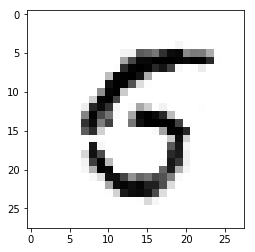

('Estimate:', array([[-14.10751152]], dtype=float32))
('Iteration:', 56700, 'at', datetime.datetime(2017, 10, 23, 5, 51, 8, 63481))


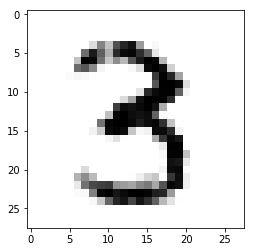

('Estimate:', array([[-7.58706665]], dtype=float32))
('Iteration:', 56800, 'at', datetime.datetime(2017, 10, 23, 5, 52, 14, 562986))


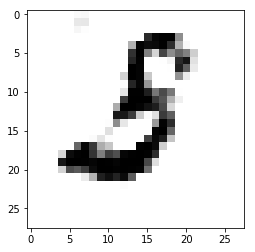

('Estimate:', array([[-12.01382923]], dtype=float32))
('Iteration:', 56900, 'at', datetime.datetime(2017, 10, 23, 5, 53, 22, 20746))


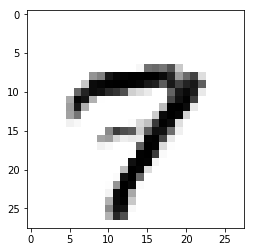

('Estimate:', array([[-7.10951853]], dtype=float32))
('Iteration:', 57000, 'at', datetime.datetime(2017, 10, 23, 5, 54, 28, 450005))


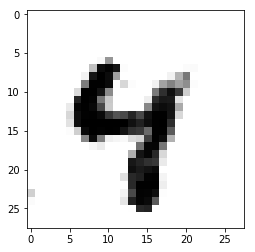

('Estimate:', array([[-9.6247282]], dtype=float32))
('Iteration:', 57100, 'at', datetime.datetime(2017, 10, 23, 5, 55, 35, 188655))


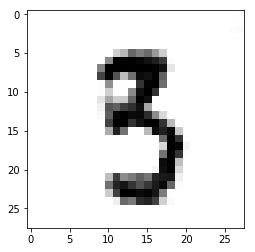

('Estimate:', array([[-14.98835373]], dtype=float32))
('Iteration:', 57200, 'at', datetime.datetime(2017, 10, 23, 5, 56, 41, 748555))


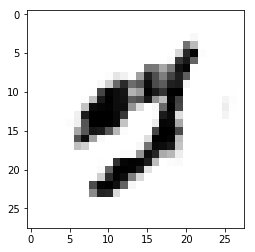

('Estimate:', array([[-10.68702602]], dtype=float32))
('Iteration:', 57300, 'at', datetime.datetime(2017, 10, 23, 5, 57, 48, 618631))


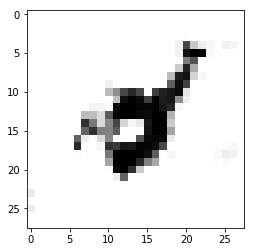

('Estimate:', array([[-15.72613811]], dtype=float32))
('Iteration:', 57400, 'at', datetime.datetime(2017, 10, 23, 5, 58, 55, 55695))


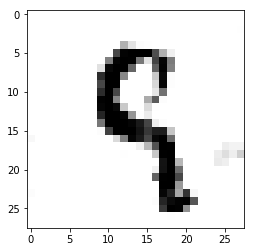

('Estimate:', array([[-11.48319149]], dtype=float32))
('Iteration:', 57500, 'at', datetime.datetime(2017, 10, 23, 6, 0, 2, 254213))


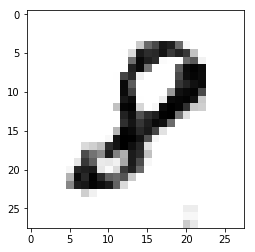

('Estimate:', array([[-10.71499348]], dtype=float32))
('Iteration:', 57600, 'at', datetime.datetime(2017, 10, 23, 6, 1, 10, 37278))


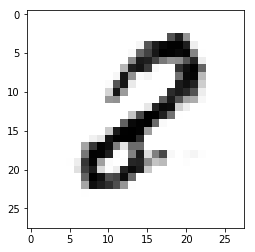

('Estimate:', array([[-14.64379978]], dtype=float32))
('Iteration:', 57700, 'at', datetime.datetime(2017, 10, 23, 6, 2, 17, 700740))


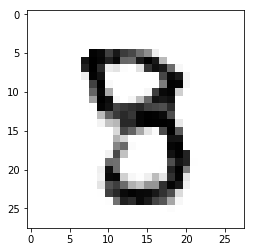

('Estimate:', array([[-9.35908508]], dtype=float32))
('Iteration:', 57800, 'at', datetime.datetime(2017, 10, 23, 6, 3, 25, 184301))


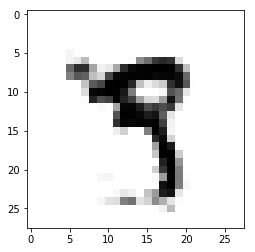

('Estimate:', array([[-16.17932892]], dtype=float32))
('Iteration:', 57900, 'at', datetime.datetime(2017, 10, 23, 6, 4, 32, 403256))


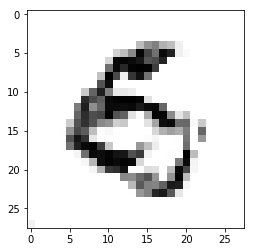

('Estimate:', array([[-9.33751965]], dtype=float32))
('Iteration:', 58000, 'at', datetime.datetime(2017, 10, 23, 6, 5, 39, 824993))


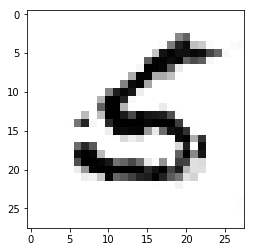

('Estimate:', array([[-17.01019859]], dtype=float32))
('Iteration:', 58100, 'at', datetime.datetime(2017, 10, 23, 6, 6, 46, 939983))


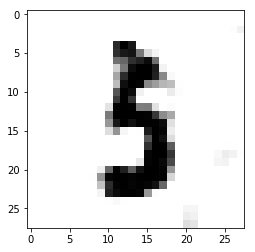

('Estimate:', array([[-9.17169189]], dtype=float32))
('Iteration:', 58200, 'at', datetime.datetime(2017, 10, 23, 6, 7, 54, 553347))


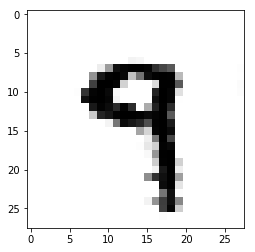

('Estimate:', array([[-13.76838684]], dtype=float32))
('Iteration:', 58300, 'at', datetime.datetime(2017, 10, 23, 6, 9, 2, 269778))


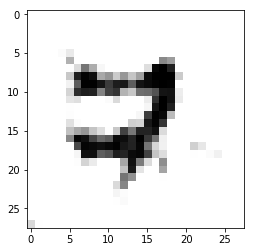

('Estimate:', array([[-9.31518936]], dtype=float32))
('Iteration:', 58400, 'at', datetime.datetime(2017, 10, 23, 6, 10, 9, 638832))


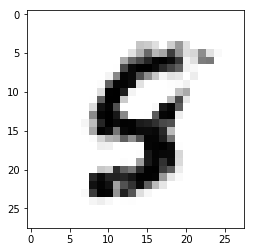

('Estimate:', array([[-13.55717182]], dtype=float32))
('Iteration:', 58500, 'at', datetime.datetime(2017, 10, 23, 6, 11, 17, 615750))


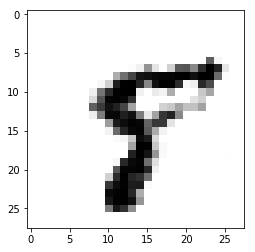

('Estimate:', array([[-15.04098129]], dtype=float32))
('Iteration:', 58600, 'at', datetime.datetime(2017, 10, 23, 6, 12, 25, 557644))


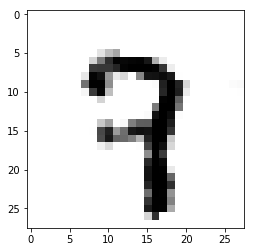

('Estimate:', array([[-11.90157223]], dtype=float32))
('Iteration:', 58700, 'at', datetime.datetime(2017, 10, 23, 6, 13, 34, 465631))


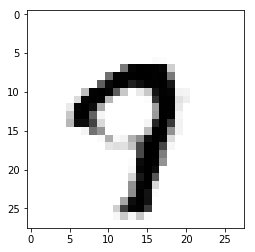

('Estimate:', array([[-11.79725838]], dtype=float32))
('Iteration:', 58800, 'at', datetime.datetime(2017, 10, 23, 6, 14, 43, 60367))


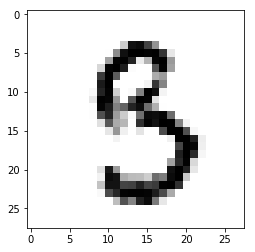

('Estimate:', array([[-14.4735136]], dtype=float32))
('Iteration:', 58900, 'at', datetime.datetime(2017, 10, 23, 6, 15, 52, 880818))


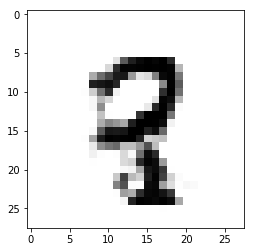

('Estimate:', array([[-13.88104248]], dtype=float32))
('Iteration:', 59000, 'at', datetime.datetime(2017, 10, 23, 6, 17, 2, 796378))


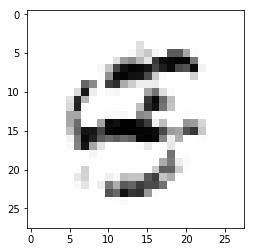

('Estimate:', array([[-15.89927769]], dtype=float32))
('Iteration:', 59100, 'at', datetime.datetime(2017, 10, 23, 6, 18, 13, 277393))


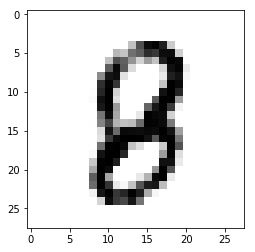

('Estimate:', array([[-12.08951092]], dtype=float32))
('Iteration:', 59200, 'at', datetime.datetime(2017, 10, 23, 6, 19, 21, 694256))


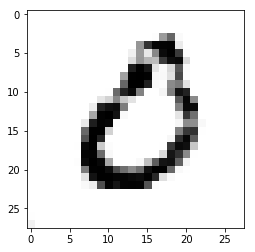

('Estimate:', array([[ 1.65367985]], dtype=float32))
('Iteration:', 59300, 'at', datetime.datetime(2017, 10, 23, 6, 20, 29, 770644))


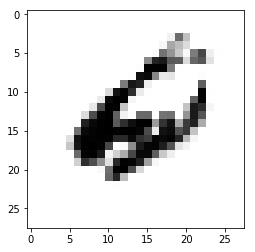

('Estimate:', array([[-11.38669586]], dtype=float32))
('Iteration:', 59400, 'at', datetime.datetime(2017, 10, 23, 6, 21, 39, 267797))


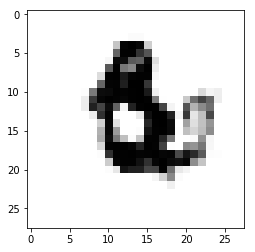

('Estimate:', array([[-11.01607895]], dtype=float32))
('Iteration:', 59500, 'at', datetime.datetime(2017, 10, 23, 6, 22, 48, 982960))


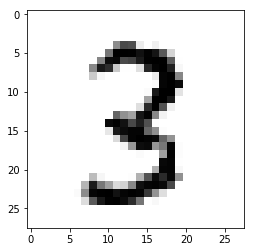

('Estimate:', array([[-10.78865242]], dtype=float32))
('Iteration:', 59600, 'at', datetime.datetime(2017, 10, 23, 6, 23, 57, 406963))


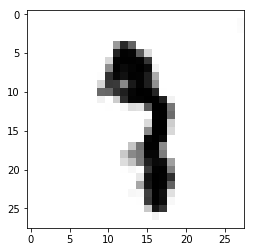

('Estimate:', array([[-7.04428625]], dtype=float32))
('Iteration:', 59700, 'at', datetime.datetime(2017, 10, 23, 6, 25, 6, 44589))


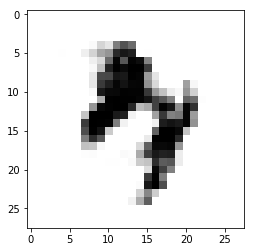

('Estimate:', array([[-16.45749092]], dtype=float32))
('Iteration:', 59800, 'at', datetime.datetime(2017, 10, 23, 6, 26, 16, 90947))


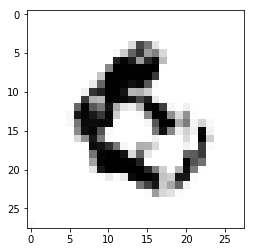

('Estimate:', array([[-18.48145866]], dtype=float32))
('Iteration:', 59900, 'at', datetime.datetime(2017, 10, 23, 6, 27, 24, 532327))


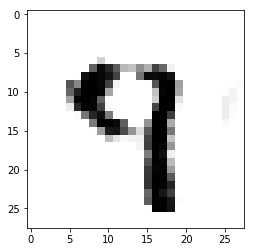

('Estimate:', array([[-13.55400753]], dtype=float32))
('Iteration:', 60000, 'at', datetime.datetime(2017, 10, 23, 6, 28, 32, 642504))


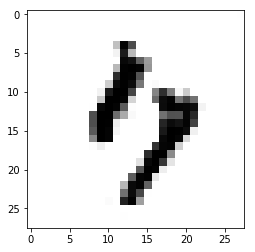

('Estimate:', array([[-13.85992241]], dtype=float32))
('Iteration:', 60100, 'at', datetime.datetime(2017, 10, 23, 6, 29, 41, 298637))


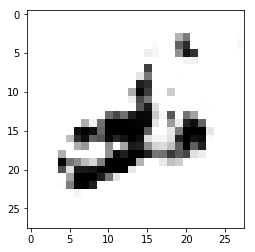

('Estimate:', array([[-16.94067192]], dtype=float32))
('Iteration:', 60200, 'at', datetime.datetime(2017, 10, 23, 6, 30, 49, 561415))


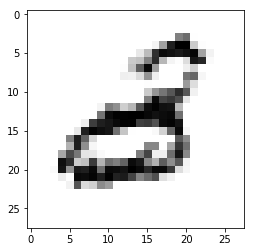

('Estimate:', array([[-5.94120407]], dtype=float32))
('Iteration:', 60300, 'at', datetime.datetime(2017, 10, 23, 6, 31, 57, 670969))


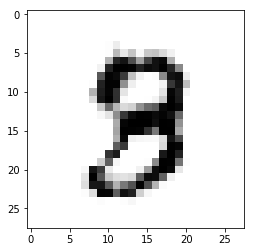

('Estimate:', array([[-14.76404381]], dtype=float32))
('Iteration:', 60400, 'at', datetime.datetime(2017, 10, 23, 6, 33, 6, 25686))


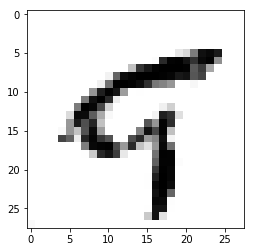

('Estimate:', array([[-16.37207031]], dtype=float32))
('Iteration:', 60500, 'at', datetime.datetime(2017, 10, 23, 6, 34, 14, 150870))


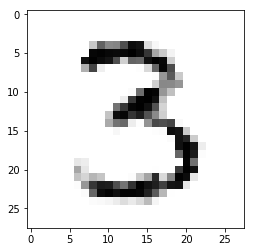

('Estimate:', array([[-13.4678278]], dtype=float32))
('Iteration:', 60600, 'at', datetime.datetime(2017, 10, 23, 6, 35, 22, 397059))


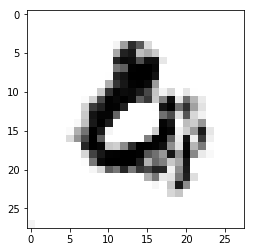

('Estimate:', array([[-12.20937538]], dtype=float32))
('Iteration:', 60700, 'at', datetime.datetime(2017, 10, 23, 6, 36, 30, 219604))


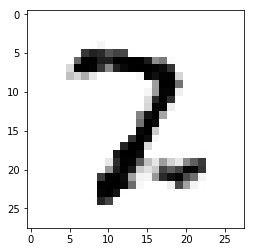

('Estimate:', array([[-2.17592502]], dtype=float32))
('Iteration:', 60800, 'at', datetime.datetime(2017, 10, 23, 6, 37, 40, 812712))


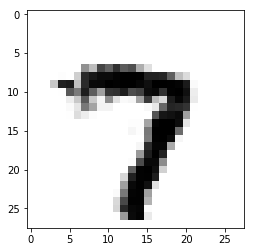

('Estimate:', array([[-6.45965719]], dtype=float32))
('Iteration:', 60900, 'at', datetime.datetime(2017, 10, 23, 6, 38, 49, 465652))


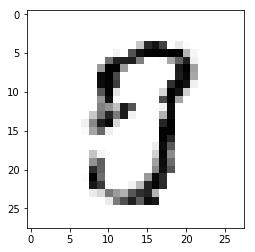

('Estimate:', array([[-13.96671677]], dtype=float32))
('Iteration:', 61000, 'at', datetime.datetime(2017, 10, 23, 6, 39, 58, 57569))


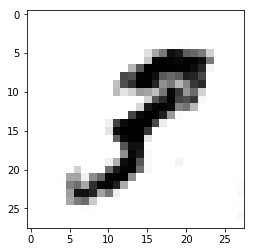

('Estimate:', array([[-12.0753355]], dtype=float32))
('Iteration:', 61100, 'at', datetime.datetime(2017, 10, 23, 6, 41, 6, 702840))


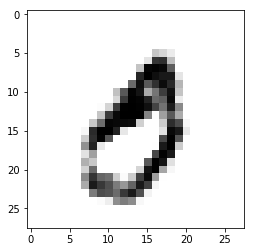

('Estimate:', array([[-12.54736614]], dtype=float32))
('Iteration:', 61200, 'at', datetime.datetime(2017, 10, 23, 6, 42, 15, 55519))


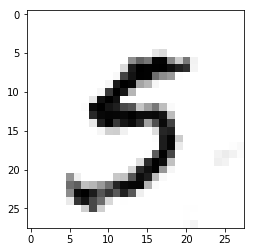

('Estimate:', array([[-8.4295578]], dtype=float32))
('Iteration:', 61300, 'at', datetime.datetime(2017, 10, 23, 6, 43, 23, 840938))


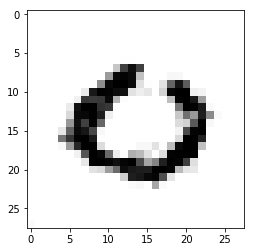

('Estimate:', array([[-3.17867374]], dtype=float32))
('Iteration:', 61400, 'at', datetime.datetime(2017, 10, 23, 6, 44, 32, 251901))


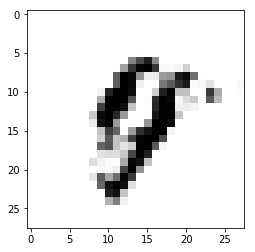

('Estimate:', array([[-20.52317238]], dtype=float32))
('Iteration:', 61500, 'at', datetime.datetime(2017, 10, 23, 6, 45, 41, 57844))


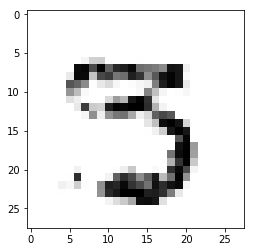

('Estimate:', array([[-12.65558338]], dtype=float32))
('Iteration:', 61600, 'at', datetime.datetime(2017, 10, 23, 6, 46, 49, 366971))


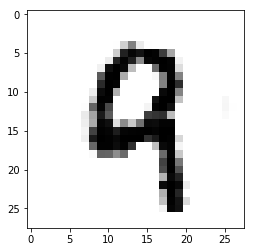

('Estimate:', array([[-12.93649197]], dtype=float32))
('Iteration:', 61700, 'at', datetime.datetime(2017, 10, 23, 6, 47, 57, 798707))


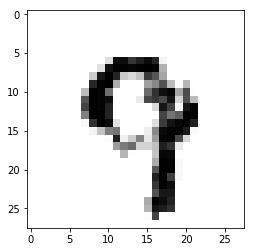

('Estimate:', array([[-12.80317116]], dtype=float32))
('Iteration:', 61800, 'at', datetime.datetime(2017, 10, 23, 6, 49, 6, 337484))


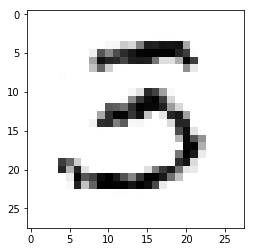

('Estimate:', array([[-14.44379616]], dtype=float32))
('Iteration:', 61900, 'at', datetime.datetime(2017, 10, 23, 6, 50, 14, 510693))


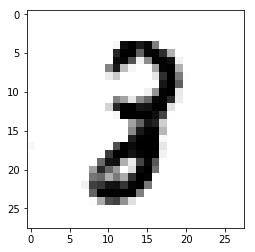

('Estimate:', array([[-8.99508572]], dtype=float32))
('Iteration:', 62000, 'at', datetime.datetime(2017, 10, 23, 6, 51, 22, 922294))


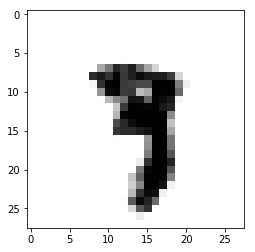

('Estimate:', array([[-14.88642788]], dtype=float32))
('Iteration:', 62100, 'at', datetime.datetime(2017, 10, 23, 6, 52, 31, 121581))


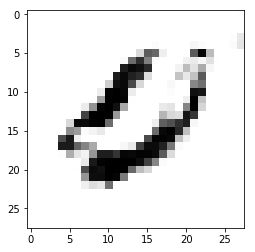

('Estimate:', array([[-6.05307102]], dtype=float32))
('Iteration:', 62200, 'at', datetime.datetime(2017, 10, 23, 6, 53, 40, 749072))


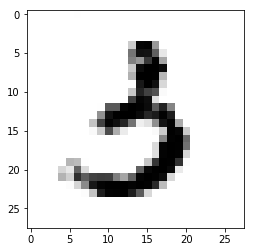

('Estimate:', array([[-16.4239502]], dtype=float32))
('Iteration:', 62300, 'at', datetime.datetime(2017, 10, 23, 6, 54, 50, 301726))


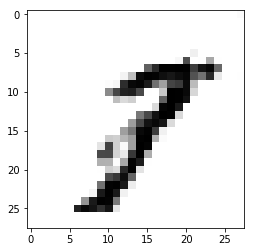

('Estimate:', array([[-10.51935291]], dtype=float32))
('Iteration:', 62400, 'at', datetime.datetime(2017, 10, 23, 6, 55, 59, 263991))


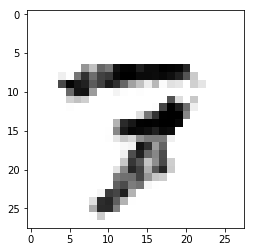

('Estimate:', array([[-11.96622849]], dtype=float32))
('Iteration:', 62500, 'at', datetime.datetime(2017, 10, 23, 6, 57, 8, 147444))


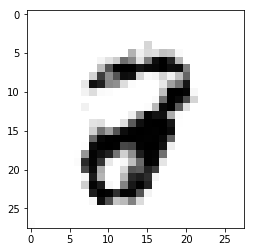

('Estimate:', array([[-20.01555634]], dtype=float32))
('Iteration:', 62600, 'at', datetime.datetime(2017, 10, 23, 6, 58, 16, 604129))


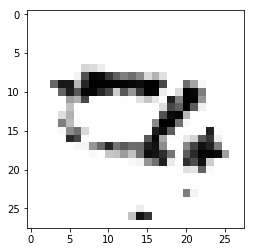

('Estimate:', array([[-17.90353775]], dtype=float32))
('Iteration:', 62700, 'at', datetime.datetime(2017, 10, 23, 6, 59, 25, 356466))


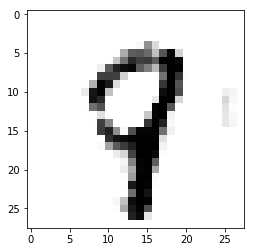

('Estimate:', array([[-15.75704956]], dtype=float32))
('Iteration:', 62800, 'at', datetime.datetime(2017, 10, 23, 7, 0, 33, 992484))


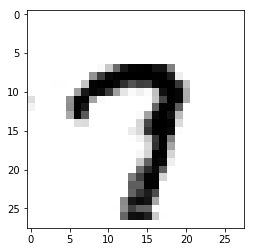

('Estimate:', array([[-10.25715637]], dtype=float32))
('Iteration:', 62900, 'at', datetime.datetime(2017, 10, 23, 7, 1, 42, 786729))


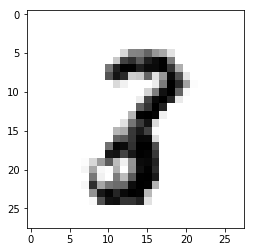

('Estimate:', array([[-15.0906868]], dtype=float32))
('Iteration:', 63000, 'at', datetime.datetime(2017, 10, 23, 7, 2, 51, 207800))


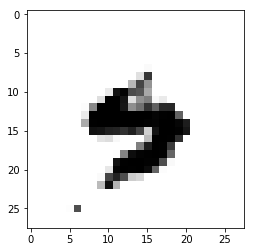

('Estimate:', array([[-21.66549683]], dtype=float32))
('Iteration:', 63100, 'at', datetime.datetime(2017, 10, 23, 7, 3, 59, 757042))


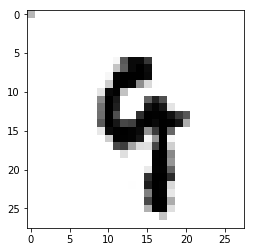

('Estimate:', array([[-13.09586525]], dtype=float32))
('Iteration:', 63200, 'at', datetime.datetime(2017, 10, 23, 7, 5, 8, 776533))


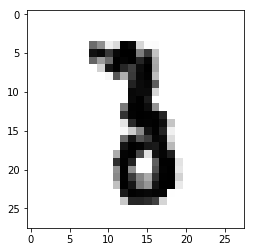

('Estimate:', array([[-9.89614296]], dtype=float32))
('Iteration:', 63300, 'at', datetime.datetime(2017, 10, 23, 7, 6, 17, 104902))


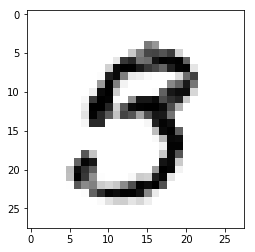

('Estimate:', array([[-11.86281109]], dtype=float32))
('Iteration:', 63400, 'at', datetime.datetime(2017, 10, 23, 7, 7, 25, 270480))


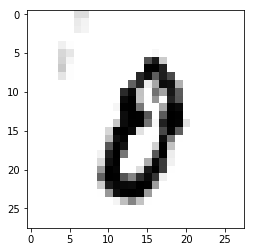

('Estimate:', array([[-9.48736763]], dtype=float32))
('Iteration:', 63500, 'at', datetime.datetime(2017, 10, 23, 7, 8, 33, 605839))


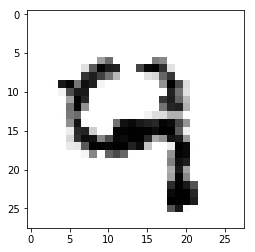

('Estimate:', array([[-7.77536869]], dtype=float32))
('Iteration:', 63600, 'at', datetime.datetime(2017, 10, 23, 7, 9, 42, 213959))


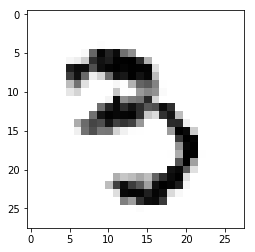

('Estimate:', array([[-4.20091391]], dtype=float32))
('Iteration:', 63700, 'at', datetime.datetime(2017, 10, 23, 7, 10, 50, 916637))


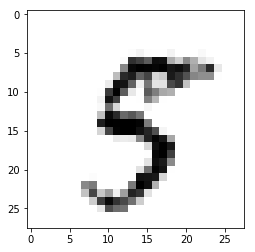

('Estimate:', array([[-6.20988321]], dtype=float32))
('Iteration:', 63800, 'at', datetime.datetime(2017, 10, 23, 7, 12, 0, 500710))


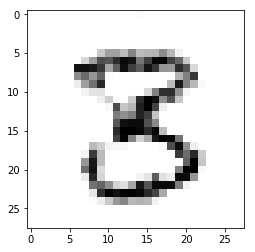

('Estimate:', array([[-11.84724236]], dtype=float32))
('Iteration:', 63900, 'at', datetime.datetime(2017, 10, 23, 7, 13, 9, 919981))


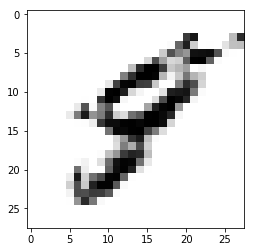

('Estimate:', array([[-12.58930779]], dtype=float32))
('Iteration:', 64000, 'at', datetime.datetime(2017, 10, 23, 7, 14, 21, 218666))


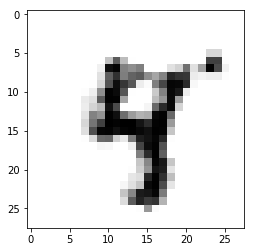

('Estimate:', array([[-8.60876179]], dtype=float32))
('Iteration:', 64100, 'at', datetime.datetime(2017, 10, 23, 7, 15, 30, 894544))


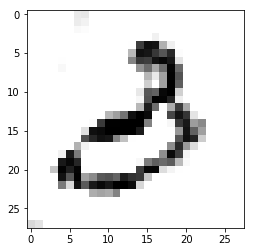

('Estimate:', array([[-7.37207937]], dtype=float32))
('Iteration:', 64200, 'at', datetime.datetime(2017, 10, 23, 7, 16, 39, 658022))


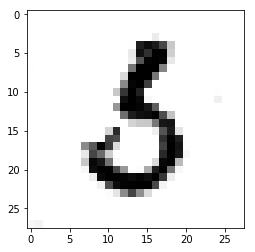

('Estimate:', array([[-14.08669758]], dtype=float32))
('Iteration:', 64300, 'at', datetime.datetime(2017, 10, 23, 7, 17, 49, 472704))


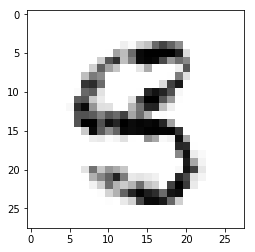

('Estimate:', array([[-13.14889908]], dtype=float32))
('Iteration:', 64400, 'at', datetime.datetime(2017, 10, 23, 7, 19, 0, 44959))


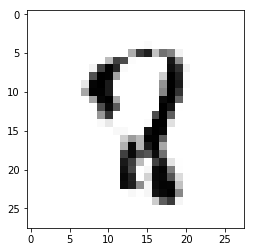

('Estimate:', array([[-9.80803967]], dtype=float32))
('Iteration:', 64500, 'at', datetime.datetime(2017, 10, 23, 7, 20, 9, 7411))


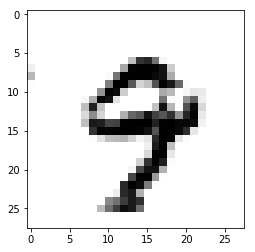

('Estimate:', array([[-5.96114397]], dtype=float32))
('Iteration:', 64600, 'at', datetime.datetime(2017, 10, 23, 7, 21, 17, 935161))


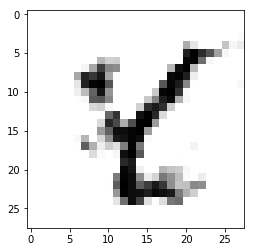

('Estimate:', array([[-11.55016804]], dtype=float32))
('Iteration:', 64700, 'at', datetime.datetime(2017, 10, 23, 7, 22, 27, 22096))


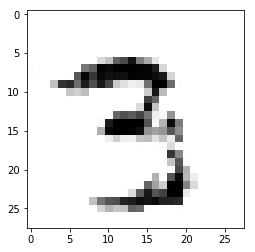

('Estimate:', array([[-14.91403484]], dtype=float32))
('Iteration:', 64800, 'at', datetime.datetime(2017, 10, 23, 7, 23, 35, 894322))


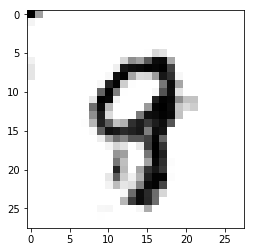

('Estimate:', array([[-17.36958313]], dtype=float32))
('Iteration:', 64900, 'at', datetime.datetime(2017, 10, 23, 7, 24, 44, 943447))


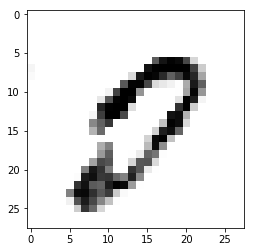

('Estimate:', array([[-4.64933538]], dtype=float32))
('Iteration:', 65000, 'at', datetime.datetime(2017, 10, 23, 7, 25, 53, 454307))


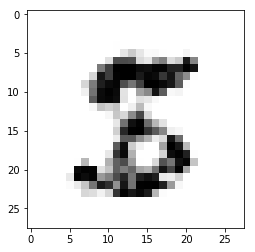

('Estimate:', array([[-11.8779707]], dtype=float32))
('Iteration:', 65100, 'at', datetime.datetime(2017, 10, 23, 7, 27, 2, 562382))


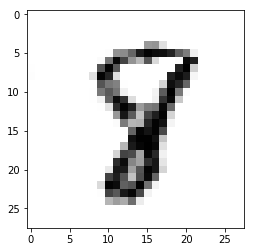

('Estimate:', array([[-10.37567139]], dtype=float32))
('Iteration:', 65200, 'at', datetime.datetime(2017, 10, 23, 7, 28, 11, 210534))


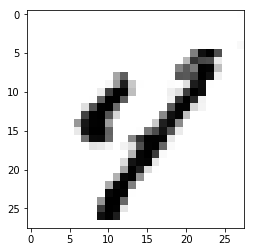

('Estimate:', array([[-6.14487791]], dtype=float32))
('Iteration:', 65300, 'at', datetime.datetime(2017, 10, 23, 7, 29, 20, 639517))


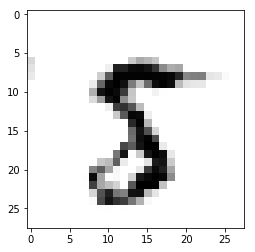

('Estimate:', array([[-8.93807411]], dtype=float32))
('Iteration:', 65400, 'at', datetime.datetime(2017, 10, 23, 7, 30, 30, 331770))


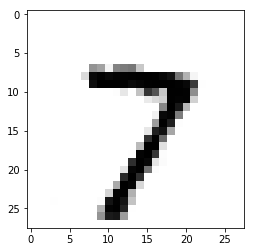

('Estimate:', array([[-6.75718927]], dtype=float32))
('Iteration:', 65500, 'at', datetime.datetime(2017, 10, 23, 7, 31, 40, 469843))


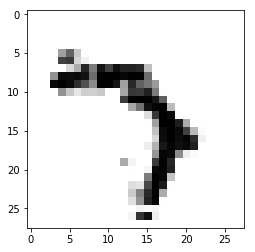

('Estimate:', array([[-15.7105751]], dtype=float32))
('Iteration:', 65600, 'at', datetime.datetime(2017, 10, 23, 7, 32, 50, 70050))


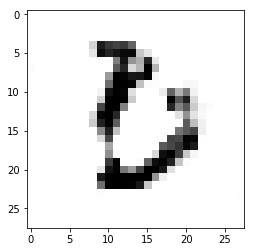

('Estimate:', array([[-15.41128063]], dtype=float32))
('Iteration:', 65700, 'at', datetime.datetime(2017, 10, 23, 7, 34, 0, 542925))


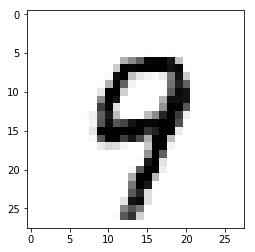

('Estimate:', array([[-10.2077961]], dtype=float32))
('Iteration:', 65800, 'at', datetime.datetime(2017, 10, 23, 7, 35, 9, 669839))


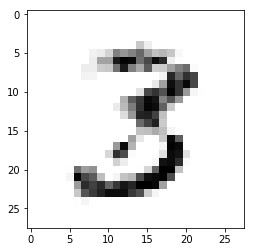

('Estimate:', array([[-17.1000843]], dtype=float32))
('Iteration:', 65900, 'at', datetime.datetime(2017, 10, 23, 7, 36, 18, 380303))


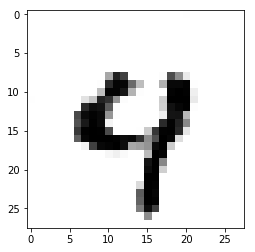

('Estimate:', array([[-10.49048042]], dtype=float32))
('Iteration:', 66000, 'at', datetime.datetime(2017, 10, 23, 7, 37, 27, 488823))


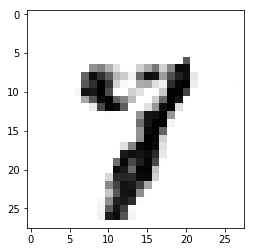

('Estimate:', array([[-7.0652113]], dtype=float32))
('Iteration:', 66100, 'at', datetime.datetime(2017, 10, 23, 7, 38, 36, 75228))


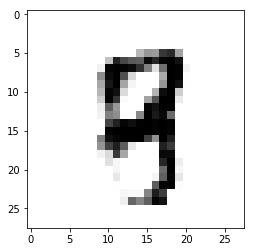

('Estimate:', array([[-14.83567429]], dtype=float32))
('Iteration:', 66200, 'at', datetime.datetime(2017, 10, 23, 7, 39, 45, 93355))


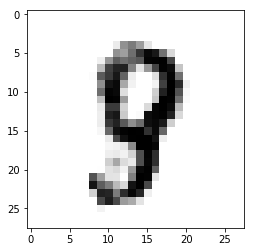

('Estimate:', array([[-15.61785698]], dtype=float32))
('Iteration:', 66300, 'at', datetime.datetime(2017, 10, 23, 7, 40, 53, 515384))


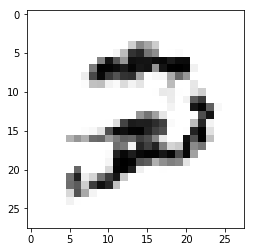

('Estimate:', array([[-14.62384319]], dtype=float32))
('Iteration:', 66400, 'at', datetime.datetime(2017, 10, 23, 7, 42, 2, 383337))


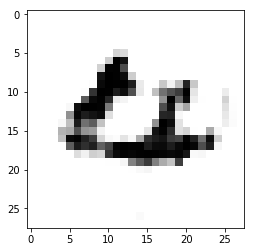

('Estimate:', array([[-12.41872215]], dtype=float32))
('Iteration:', 66500, 'at', datetime.datetime(2017, 10, 23, 7, 43, 11, 895258))


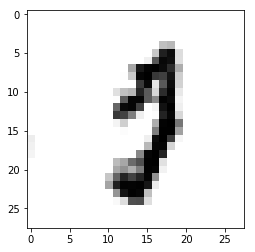

('Estimate:', array([[-13.02544498]], dtype=float32))
('Iteration:', 66600, 'at', datetime.datetime(2017, 10, 23, 7, 44, 20, 878303))


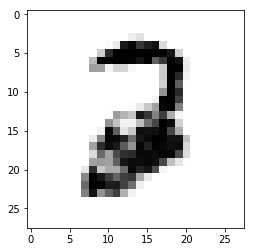

('Estimate:', array([[-11.60383797]], dtype=float32))
('Iteration:', 66700, 'at', datetime.datetime(2017, 10, 23, 7, 45, 30, 149223))


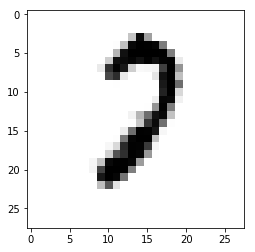

('Estimate:', array([[-17.32072258]], dtype=float32))
('Iteration:', 66800, 'at', datetime.datetime(2017, 10, 23, 7, 46, 39, 184911))


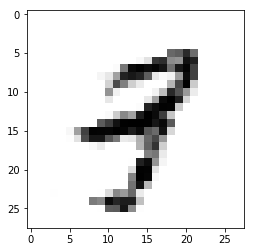

('Estimate:', array([[-18.59408188]], dtype=float32))
('Iteration:', 66900, 'at', datetime.datetime(2017, 10, 23, 7, 47, 48, 258160))


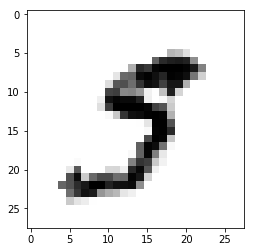

('Estimate:', array([[-19.26699066]], dtype=float32))
('Iteration:', 67000, 'at', datetime.datetime(2017, 10, 23, 7, 48, 57, 818853))


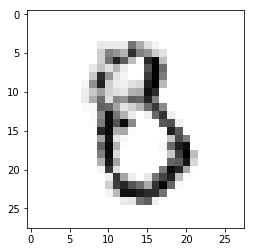

('Estimate:', array([[-15.00946426]], dtype=float32))
('Iteration:', 67100, 'at', datetime.datetime(2017, 10, 23, 7, 50, 7, 359239))


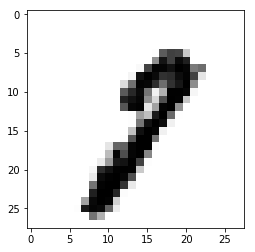

('Estimate:', array([[-15.74092007]], dtype=float32))
('Iteration:', 67200, 'at', datetime.datetime(2017, 10, 23, 7, 51, 18, 676232))


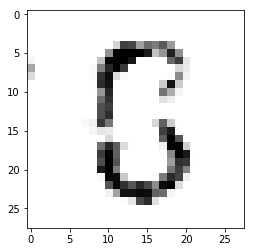

('Estimate:', array([[-18.43412781]], dtype=float32))
('Iteration:', 67300, 'at', datetime.datetime(2017, 10, 23, 7, 52, 27, 259591))


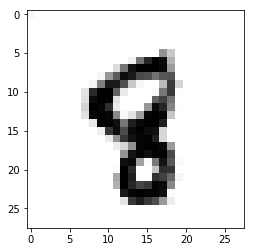

('Estimate:', array([[-13.17124557]], dtype=float32))
('Iteration:', 67400, 'at', datetime.datetime(2017, 10, 23, 7, 53, 36, 510037))


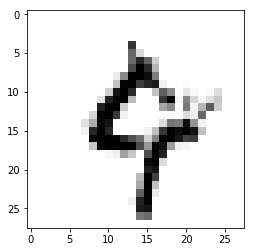

('Estimate:', array([[-11.6538887]], dtype=float32))
('Iteration:', 67500, 'at', datetime.datetime(2017, 10, 23, 7, 54, 45, 219188))


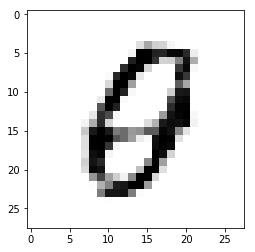

('Estimate:', array([[-12.90610695]], dtype=float32))
('Iteration:', 67600, 'at', datetime.datetime(2017, 10, 23, 7, 55, 54, 364677))


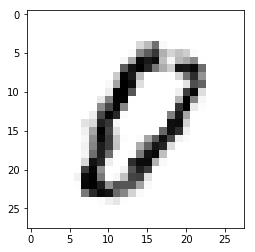

('Estimate:', array([[-17.11395836]], dtype=float32))
('Iteration:', 67700, 'at', datetime.datetime(2017, 10, 23, 7, 57, 3, 203963))


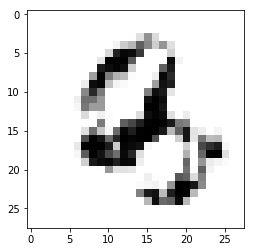

('Estimate:', array([[-11.44576454]], dtype=float32))
('Iteration:', 67800, 'at', datetime.datetime(2017, 10, 23, 7, 58, 11, 978285))


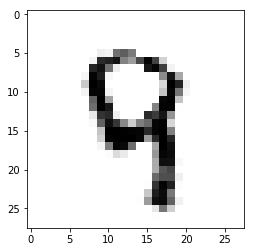

('Estimate:', array([[-13.2948885]], dtype=float32))
('Iteration:', 67900, 'at', datetime.datetime(2017, 10, 23, 7, 59, 21, 220398))


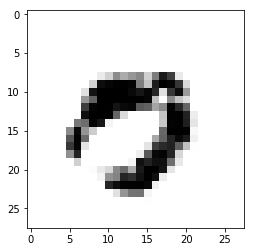

('Estimate:', array([[-12.77172756]], dtype=float32))
('Iteration:', 68000, 'at', datetime.datetime(2017, 10, 23, 8, 0, 30, 265994))


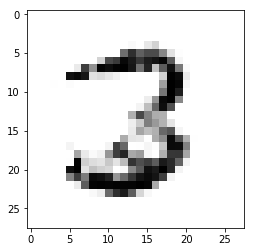

('Estimate:', array([[-15.94304848]], dtype=float32))
('Iteration:', 68100, 'at', datetime.datetime(2017, 10, 23, 8, 1, 39, 196111))


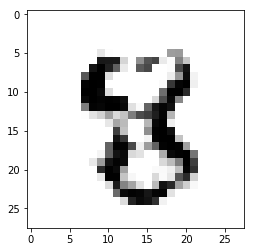

('Estimate:', array([[-13.70400429]], dtype=float32))
('Iteration:', 68200, 'at', datetime.datetime(2017, 10, 23, 8, 2, 48, 466587))


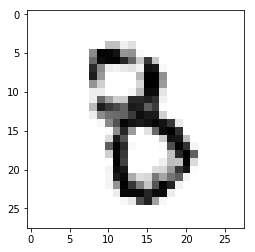

('Estimate:', array([[-12.03171349]], dtype=float32))
('Iteration:', 68300, 'at', datetime.datetime(2017, 10, 23, 8, 3, 57, 696995))


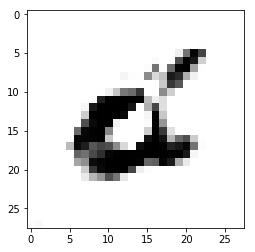

('Estimate:', array([[-18.30629539]], dtype=float32))
('Iteration:', 68400, 'at', datetime.datetime(2017, 10, 23, 8, 5, 6, 890189))


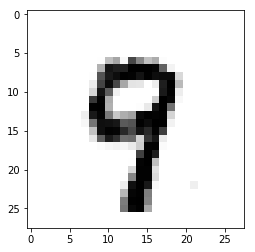

('Estimate:', array([[-11.2624855]], dtype=float32))
('Iteration:', 68500, 'at', datetime.datetime(2017, 10, 23, 8, 6, 15, 489419))


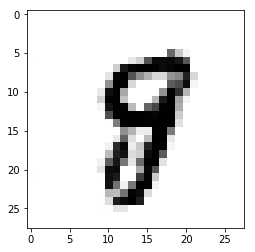

('Estimate:', array([[-13.95781612]], dtype=float32))
('Iteration:', 68600, 'at', datetime.datetime(2017, 10, 23, 8, 7, 25, 862438))


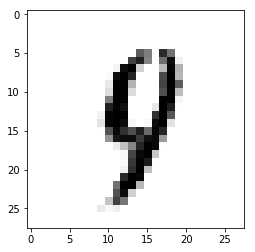

('Estimate:', array([[-10.1429491]], dtype=float32))
('Iteration:', 68700, 'at', datetime.datetime(2017, 10, 23, 8, 8, 34, 920690))


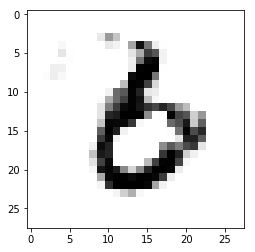

('Estimate:', array([[-16.52206612]], dtype=float32))
('Iteration:', 68800, 'at', datetime.datetime(2017, 10, 23, 8, 9, 44, 682286))


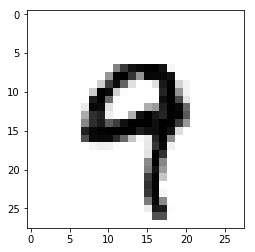

('Estimate:', array([[-8.37901974]], dtype=float32))
('Iteration:', 68900, 'at', datetime.datetime(2017, 10, 23, 8, 10, 53, 246943))


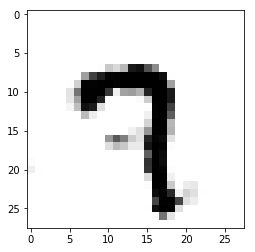

('Estimate:', array([[-12.57738304]], dtype=float32))
('Iteration:', 69000, 'at', datetime.datetime(2017, 10, 23, 8, 12, 2, 296806))


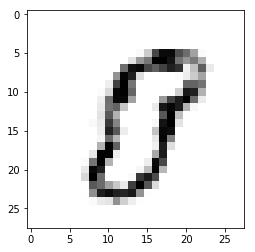

('Estimate:', array([[-12.97261524]], dtype=float32))
('Iteration:', 69100, 'at', datetime.datetime(2017, 10, 23, 8, 13, 15, 437304))


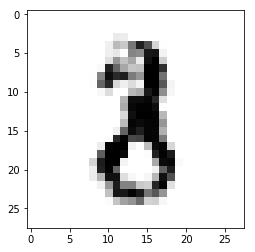

('Estimate:', array([[-12.67123127]], dtype=float32))
('Iteration:', 69200, 'at', datetime.datetime(2017, 10, 23, 8, 14, 24, 18736))


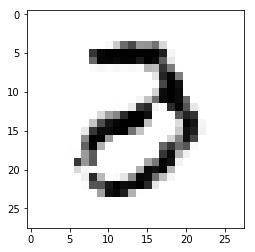

('Estimate:', array([[-11.02504921]], dtype=float32))
('Iteration:', 69300, 'at', datetime.datetime(2017, 10, 23, 8, 15, 33, 789010))


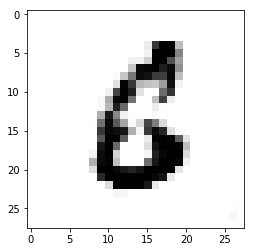

('Estimate:', array([[-15.00327873]], dtype=float32))
('Iteration:', 69400, 'at', datetime.datetime(2017, 10, 23, 8, 16, 42, 452112))


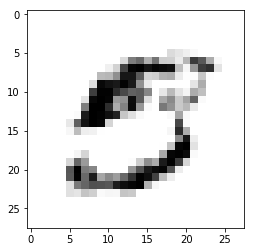

('Estimate:', array([[-10.58049774]], dtype=float32))
('Iteration:', 69500, 'at', datetime.datetime(2017, 10, 23, 8, 17, 52, 976844))


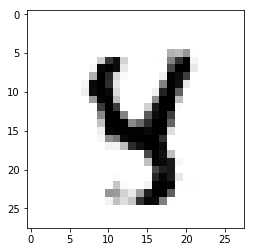

('Estimate:', array([[-10.88498878]], dtype=float32))
('Iteration:', 69600, 'at', datetime.datetime(2017, 10, 23, 8, 19, 2, 256839))


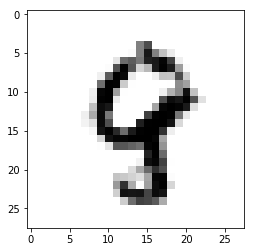

('Estimate:', array([[-13.67127037]], dtype=float32))
('Iteration:', 69700, 'at', datetime.datetime(2017, 10, 23, 8, 20, 11, 440602))


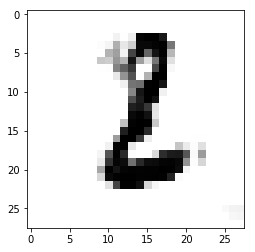

('Estimate:', array([[-15.46995068]], dtype=float32))
('Iteration:', 69800, 'at', datetime.datetime(2017, 10, 23, 8, 21, 21, 295141))


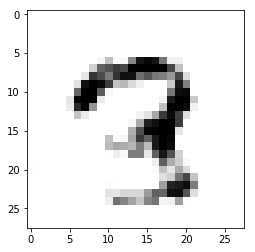

('Estimate:', array([[-14.58244419]], dtype=float32))
('Iteration:', 69900, 'at', datetime.datetime(2017, 10, 23, 8, 22, 30, 260917))


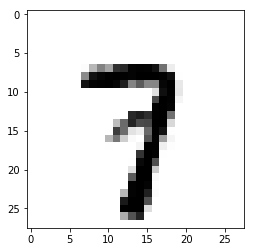

('Estimate:', array([[-15.86143112]], dtype=float32))
('Iteration:', 70000, 'at', datetime.datetime(2017, 10, 23, 8, 23, 39, 852625))


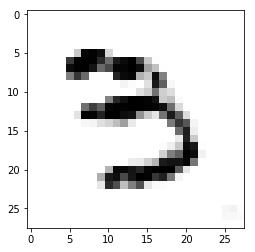

('Estimate:', array([[ 0.99911547]], dtype=float32))
('Iteration:', 70100, 'at', datetime.datetime(2017, 10, 23, 8, 24, 49, 72814))


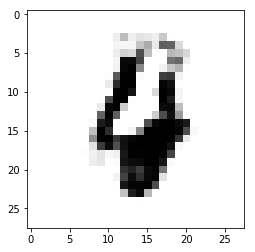

('Estimate:', array([[-16.63432884]], dtype=float32))
('Iteration:', 70200, 'at', datetime.datetime(2017, 10, 23, 8, 25, 58, 515352))


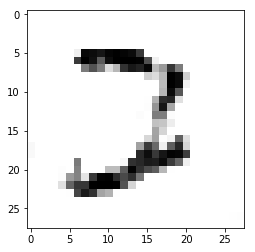

('Estimate:', array([[-14.71865845]], dtype=float32))
('Iteration:', 70300, 'at', datetime.datetime(2017, 10, 23, 8, 27, 8, 593363))


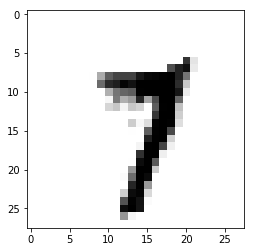

('Estimate:', array([[-15.51204777]], dtype=float32))
('Iteration:', 70400, 'at', datetime.datetime(2017, 10, 23, 8, 28, 22, 91163))


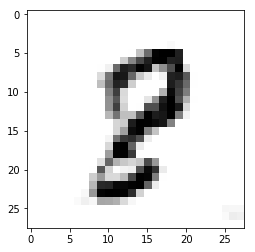

('Estimate:', array([[-10.9732666]], dtype=float32))
('Iteration:', 70500, 'at', datetime.datetime(2017, 10, 23, 8, 29, 38, 657718))


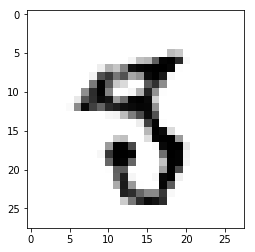

('Estimate:', array([[-11.44426346]], dtype=float32))
('Iteration:', 70600, 'at', datetime.datetime(2017, 10, 23, 8, 30, 53, 570625))


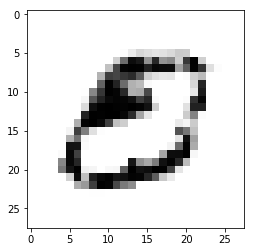

('Estimate:', array([[-19.13805389]], dtype=float32))
('Iteration:', 70700, 'at', datetime.datetime(2017, 10, 23, 8, 32, 9, 239482))


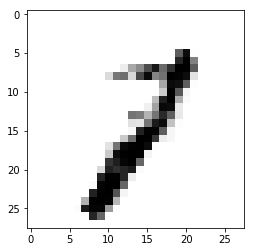

('Estimate:', array([[-16.24708939]], dtype=float32))
('Iteration:', 70800, 'at', datetime.datetime(2017, 10, 23, 8, 33, 25, 190712))


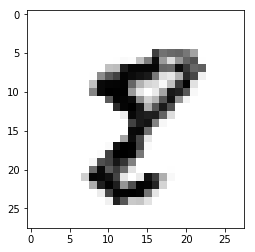

('Estimate:', array([[-8.36123943]], dtype=float32))
('Iteration:', 70900, 'at', datetime.datetime(2017, 10, 23, 8, 34, 40, 921115))


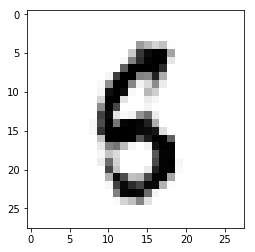

('Estimate:', array([[-16.20580864]], dtype=float32))


KeyboardInterrupt: 

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)